In [1]:
from __future__ import print_function, division
import argparse
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import os, shutil
import math
import fnmatch
import nets
from collections import OrderedDict

import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
import random
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
import time
import copy
import seaborn as sns
from pytorch_model_summary import summary
from torch.nn.utils import weight_norm
from matplotlib import pyplot as plt

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

PyTorch Version:  1.10.0
Torchvision Version:  0.11.1
cuda:0
NVIDIA GeForce RTX 3080 Ti


In [2]:
class CAE_Fused(nn.Module):
    def __init__(self, input_shape=[80,80,80,1], latent_channels=512, filters=[32, 64, 128, 256]):
        super(CAE_Fused, self).__init__()
        self.pretrained = False
        self.latent_channels = latent_channels
        self.input_shape = input_shape
        self.filters = filters
        
        self.encoder3d = nn.Sequential(OrderedDict([
            ('conv3d1_1', weight_norm(nn.Conv3d(input_shape[3], filters[0]//2, 3, padding=1))),
          ('relu3d1_1', nn.ReLU()),
          ('maxpool3d1_1', nn.MaxPool3d(2)),
          ('bn3d1_1', nn.BatchNorm3d(filters[0]//2)),
            ('conv3d2_1', weight_norm(nn.Conv3d(filters[0]//2, filters[1]//2, 3, padding=1))),
          ('relu3d2_1', nn.ReLU()),
          ('maxpool3d2_1', nn.MaxPool3d(2)),
          ('bn3d2_1', nn.BatchNorm3d(filters[1]//2)),
            ('conv3d3_1', weight_norm(nn.Conv3d(filters[1]//2, filters[2]//2, 3, padding=1))),
          ('relu3d3_1', nn.ReLU()),
          ('maxpool3d3_1', nn.MaxPool3d(2)),
          ('bn3d3_1', nn.BatchNorm3d(filters[2]//2)),
            ('conv3d4_1', weight_norm(nn.Conv3d(filters[2]//2, filters[3]//2, 3, padding=1))),
          ('relu3d4_1', nn.ReLU()),
          ('maxpool3d4_1', nn.MaxPool3d(2))
        ]))
        lin_features_len_3d = (filters[3]//2)*(input_shape[0]//2//2//2//2)*(input_shape[1]//2//2//2//2)*(input_shape[2]//2//2//2//2)
        self.embedding3d = nn.Linear(lin_features_len_3d, latent_channels)
        self.deembedding3d = nn.Linear(latent_channels, lin_features_len_3d)
        self.relu = nn.ReLU()
        
        self.decoder3d = nn.Sequential(OrderedDict([
            ('upsample3d1_2', nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)),
            ('upsample3d2_2', nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)),
            ('conv3d1_2', weight_norm(nn.Conv3d(filters[3]//2, filters[2]//2, 3, padding=1))),
          ('relu3d1_2', nn.ReLU()),
          ('bn3d1_2', nn.BatchNorm3d(filters[2]//2)),
            ('upsample3d3_2', nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)),
            ('conv3d2_2', weight_norm(nn.Conv3d(filters[2]//2, filters[1]//2, 3, padding=1))),
          ('relu3d2_2', nn.ReLU()),
          ('bn3d2_2', nn.BatchNorm3d(filters[1]//2)),
            ('upsample3d4_2', nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)),
            ('conv3d3_2', weight_norm(nn.Conv3d(filters[1]//2, filters[0]//2, 3, padding=1))),
          ('relu3d3_2', nn.ReLU()),
          ('bn3d3_2', nn.BatchNorm3d(filters[0]//2)),
            ('conv3d4_2', nn.Conv3d(filters[0]//2, input_shape[3], 1)),
          ('relu3d4_2', nn.ReLU())
        ]))
        
        self.encoder2d = nn.Sequential(OrderedDict([
            ('conv2d1_1', nn.Conv2d(input_shape[3], filters[0], 5, stride=2, padding=2, bias=False)),
          ('relu2d1_1', nn.ReLU()),
          ('bn2d1_1', nn.BatchNorm2d(filters[0])),
            ('conv2d2_1', nn.Conv2d(filters[0], filters[1], 5, stride=2, padding=2, bias=False)),
          ('relu2d2_1', nn.ReLU()),
          ('bn2d2_1', nn.BatchNorm2d(filters[1])),
            ('conv2d3_1', nn.Conv2d(filters[1], filters[2], 5, stride=2, padding=2, bias=False)),
          ('relu2d3_1', nn.ReLU()),
          ('bn2d3_1', nn.BatchNorm2d(filters[2])),
            ('conv2d4_1', nn.Conv2d(filters[2], filters[3], 3, stride=2, padding=0, bias=False)),
          ('relu2d4_1', nn.ReLU()),
        ]))
        lin_features_len = ((input_shape[0] // 2 // 2 // 2 - 1) // 2) * ((input_shape[1] // 2 // 2 // 2 - 1) // 2) * \
                           filters[3]
        self.embedding2d = nn.Linear(lin_features_len, latent_channels, bias=False)
        self.deembedding2d = nn.Linear(latent_channels, lin_features_len, bias=False)
        
        out_pad1 = 1 if input_shape[0] // 2 // 2 // 2 % 2 == 0 else 0
        out_pad2 = 1 if input_shape[0] // 2 // 2 % 2 == 0 else 0
        out_pad3 = 1 if input_shape[0] // 2 % 2 == 0 else 0
        out_pad4 = 1 if input_shape[0] % 2 == 0 else 0
        self.decoder2d = nn.Sequential(OrderedDict([
            ('conv2d1_2', nn.ConvTranspose2d(filters[3], filters[2], 3, stride=2, padding=0, output_padding=out_pad1, bias=False)),
          ('relu2d1_2', nn.ReLU()),
          ('bn2d1_2', nn.BatchNorm2d(filters[2])),
            ('conv2d2_2', nn.ConvTranspose2d(filters[2], filters[1], 5, stride=2, padding=2, output_padding=out_pad2, bias=False)),
          ('relu2d2_2', nn.ReLU()),
          ('bn2d2_2', nn.BatchNorm2d(filters[1])),
            ('conv2d3_2', nn.ConvTranspose2d(filters[1], filters[0], 5, stride=2, padding=2, output_padding=out_pad3, bias=False)),
          ('relu2d3_2', nn.ReLU()),
          ('bn2d3_2', nn.BatchNorm2d(filters[0])),
            ('conv2d4_2', nn.ConvTranspose2d(filters[0], input_shape[3], 5, stride=2, padding=2, output_padding=out_pad4, bias=False)),
          ('relu2d4_2', nn.ReLU())
        ]))

    def forward(self, x_input):
        x1, x = x_input
        
        # tansmission
        x = self.encoder2d(x)
        x = x.view(x.size(0), -1)
        x = self.embedding2d(x)
        x_out = x
        
        x = self.deembedding2d(x)
        x = self.relu(x)
        x = x.view(x.size(0), self.filters[3], ((self.input_shape[0]//2//2//2-1) // 2), ((self.input_shape[1]//2//2//2-1) // 2))
        
        x = self.decoder2d(x)
            
            
        # SSC
        x1 = self.encoder3d(x1)
        x1 = x1.view(x1.size(0),-1)
        x1 = self.embedding3d(x1)
        
        x1_out = x1
        
        x1 = self.deembedding3d(x1)
        x1 = x1.view(x1.size(0), self.filters[3]//2, self.input_shape[0]//2//2//2//2, self.input_shape[1]//2//2//2//2, self.input_shape[2]//2//2//2//2) # 128 5^3
        
        x1 = self.decoder3d(x1)
        
        extra_out = (x_out, x1_out)
        
        return (x1, x), extra_out 

In [3]:
print(summary(CAE_Fused(latent_channels=512),(torch.zeros((1,1,80,80,80)),torch.zeros((1,1,80,80))), show_input=False))

-------------------------------------------------------------------------------
         Layer (type)             Output Shape         Param #     Tr. Param #
             Conv2d-1          [1, 32, 40, 40]             800             800
               ReLU-2          [1, 32, 40, 40]               0               0
        BatchNorm2d-3          [1, 32, 40, 40]              64              64
             Conv2d-4          [1, 64, 20, 20]          51,200          51,200
               ReLU-5          [1, 64, 20, 20]               0               0
        BatchNorm2d-6          [1, 64, 20, 20]             128             128
             Conv2d-7         [1, 128, 10, 10]         204,800         204,800
               ReLU-8         [1, 128, 10, 10]               0               0
        BatchNorm2d-9         [1, 128, 10, 10]             256             256
            Conv2d-10           [1, 256, 4, 4]         294,912         294,912
              ReLU-11           [1, 256, 4, 4]     

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
#     print(output.size())
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def save_checkpoint(state, is_best_loss, filename='checkpoint.pth.tar', dirname='.'):
    fpath = os.path.join(dirname, filename + '_latest.pth.tar')
    torch.save(state, fpath)
    if is_best_loss:
        bpath = os.path.join(dirname, filename + '_best_loss.pth.tar')
        shutil.copyfile(fpath, bpath)
        
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          my_dpi=100,
                          title=None,
                          saved=True,
                          save_name='Unsupervised Learning.png'):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.1%}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.tile(np.sum(cf,axis = 0),(3,))]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
#         accuracy  = np.trace(cf) / 3
        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nBalanced Accuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize, dpi=my_dpi)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    if saved:
        plt.savefig(save_name, dpi=my_dpi*10, bbox_inches='tight')

In [5]:
def pretraining(model, dataloaders, criterion, optimizers, schedulers, params):
    # Note the time
    since = time.time()

    best_val_loss = np.inf
    losses_tr = []
    losses_val = []
    learning_rate = []

    # Unpack parameters
    pretrained = params['model_files'][1]
    print_freq = params['print_freq']
    dataset_size = params['dataset_size']
    device = params['device']
    batch = params['batch']
    num_epochs = params['pretrain_epochs']
    fused = params['fused']

    # Prep variables for weights and accuracy of the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # optionally resume from a checkpoint
    if params['resume']:
        if os.path.isfile(params['resume']):
            print("=> loading checkpoint '{}'".format(params['resume']))
            checkpoint = torch.load(params['resume'])
            args.start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']

            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(params['resume']))
            
    ckpt_dir = params['ckpt_dir']
    
    optimizer1, optimizer2 = optimizers
    scheduler1, scheduler2 = schedulers
    dataloader_train, dataloader_val = dataloaders
    
    # Go through all epochs
    print('\nPretraining')
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('\n\nEpoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        if epoch < 5:
            for param_group in optimizer1.param_groups:
                print("\nLR:", param_group['lr'], '\n---------------------')
                lr = param_group['lr']
        else:
            for param_group in optimizer2.param_groups:
                print("\nLR:", param_group['lr'], '\n---------------------')
                lr = param_group['lr']
        if fused:
            loss_tr = pretrain_train_fused(dataloader_train, model, criterion, optimizers, params, epoch)
            loss_val = pretrain_validate_fused(dataloader_val, model, criterion, params, epoch)
        else:
            raise('Not Implemented!')
        
        # learning scheduler
        if epoch < 5:
            scheduler1.step(loss_val)
        elif epoch > num_epochs * (1/3):
            scheduler2.step(loss_val)
            
        # append values
        losses_tr.append(loss_tr)
        losses_val.append(loss_val)
        learning_rate.append(lr)
        
        is_best_loss = loss_val < best_val_loss
        if is_best_loss:
            best_val_loss = min(loss_val, best_val_loss)
            print('Best val loss reached at epoch: {:.0f}\t Loss: {:.3f}'.format(epoch+1, best_val_loss))
            best_model_wts = copy.deepcopy(model.state_dict())
        
            
        dict_checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'losses_tr': losses_tr,
            'losses_val': losses_val,
            'learning_rate' : learning_rate,
        }
        
        save_checkpoint(dict_checkpoint, is_best_loss, 'Pretrain_'+str(params['boundary']), dirname=ckpt_dir)
        epoch_time = time.time()-epoch_start
        print('\nEpoch {} Training Time: {:.0f}m {:.0f}s'.format(epoch+1, epoch_time // 60, epoch_time % 60))
    time_elapsed = time.time() - since
    print('Pretraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model_wts)
    model.pretrained = True
    torch.save(model.state_dict(), pretrained)

    return model

def pretrain_train_fused(dataloader, model, criterion, optimizers, params, epoch):
    # Note the time
    since = time.time()
    
    losses = AverageMeter()
    epoch_samples = 0
    
    device = params['device']
    print_freq = params['print_freq']
    SSC_loss_weight = params['gamma_SSC']
    optimizer1, optimizer2 = optimizers
    
    model.train()
    print('\nTraining:')
    for i, (inputs, labels) in enumerate(dataloader):
        inputs_SSC, inputs_tm = inputs
        batch_size = inputs_SSC.shape[0]
        inputs_SSC = inputs_SSC.to(device)
        inputs_tm = inputs_tm.to(device)
        inputs = (inputs_SSC, inputs_tm)
        labels = labels.to(device)
        epoch_samples += batch_size
        
        # compute outputs
        outputs, _ = model(inputs)
        outputs_SSC, outputs_tm = outputs
        
        loss_SSC = criterion(outputs_SSC*65535, inputs_SSC*65535)
        loss_tm = criterion(outputs_tm*65535, inputs_tm*65535)
        loss = loss_SSC * SSC_loss_weight + (1-SSC_loss_weight) * loss_tm
        
        losses.update(loss.item(), batch_size)
        
        # compute gradient and do SGD step
        if epoch < 5:
            optimizer1.zero_grad()
        else:
            optimizer2.zero_grad()
        
        loss.backward()
        
        if epoch < 5:
            optimizer1.step()
        else:
            optimizer2.step()
            
        if (i+1) % print_freq == 0:
            print('Train: Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                   epoch+1, i+1, len(dataloader), loss=losses))
    print('Loss {loss.avg:.4f}, \t Time: {time}'.format(loss=losses, time=time.time()-since))
    return losses.avg

def pretrain_validate_fused(dataloader, model, criterion, params, epoch, mode='valid'):
    # Note the time
    since = time.time()
    
    losses = AverageMeter()
    epoch_samples = 0
    
    device = params['device']
    print_freq = params['print_freq']
    SSC_loss_weight = params['gamma_SSC']
    model.eval()
    
    print('\n')
    print(mode,':')
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs_SSC, inputs_tm = inputs
            batch_size = inputs_SSC.shape[0]
            inputs_SSC = inputs_SSC.to(device)
            inputs_tm = inputs_tm.to(device)
            inputs = (inputs_SSC, inputs_tm)
            labels = labels.to(device)
            epoch_samples += batch_size

            # compute outputs
            outputs, _ = model(inputs)
            outputs_SSC, outputs_tm = outputs
        
            loss_SSC = criterion(outputs_SSC*65535, inputs_SSC*65535)
            loss_tm = criterion(outputs_tm*65535, inputs_tm*65535)
            loss = loss_SSC * SSC_loss_weight + (1-SSC_loss_weight) * loss_tm
            
            losses.update(loss.item(), batch_size)


            if (i+1) % print_freq == 0:
                print('Validation: Epoch: [{0}][{1}/{2}]\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                       epoch+1, i+1, len(dataloader), loss=losses))
    
    
    print('Loss {loss.avg:.4f}, \t Time: {time}'.format(loss=losses, time=time.time()-since))
    return losses.avg

In [6]:
import os
from skimage import io
import skimage.transform
import scipy
import scipy.io as sio
from torch.utils.data.dataset import Dataset

class MyDataset_mat(Dataset):
    def __init__(self, ssc_paths, tm_paths, transforms_ssc=None, transforms_tm=None):
        self.paths_ssc = ssc_paths
        self.paths_tm = tm_paths
        self.transforms_ssc = transforms_ssc
        self.transforms_tm = transforms_tm
        
    def __getitem__(self, index):
        data_ssc = sio.loadmat(self.paths_ssc[index])['data']
        data_tm = sio.loadmat(self.paths_tm[index])['data']
        
        x_ssc = torch.from_numpy(data_ssc.astype(np.float32)/65535)
        x_ssc = x_ssc.unsqueeze(dim = 0)
        
        x_tm = torch.from_numpy(data_tm.astype(np.float32)/65535)
        x_tm = x_tm.unsqueeze(dim = 0)
        
        if 'Un' in self.paths_ssc[index]:
            label = int(1)
        else:
            label = int(0)
        if self.transforms_ssc:
            x_ssc = self.transforms_ssc(x_ssc)
        if self.transforms_tm:
            x_tm = self.transforms_ssc(x_tm)
        return (x_ssc, x_tm),label
    
    def __len__(self):
        return len(self.paths_ssc)
    

In [7]:
# important parameters
mode = 'pretrain' #'train_full' # 'pretrain'
pretrain = True # pretrain the model or not
pretrained_net = 4 # if loading the pretrained network, the index of the pretrained networks
fused = True # fused network for SSC and tm

rate = 1e-4 # clustering learning rate
rate_pretrain = 1e-3 # pretraining learning rate
rate_pretrain_init = 1e-5
epochs = 20 # clustering epoches
pretrain_epochs = 200 # training epoches
update_interval = 5000 # intercal to update the clustering for target distribution
gamma = 1 # Clustering loss weight
gamma_SSC = 1e-2
tol = 0 # Tolerance for label changes during clustering, determines when to stop the clustering training
num_clusters = 2 # Number of clusters
latent_channels = 512 # Number of latent channels


net_architecture = 'CAE_Fused'
weight = 0.5 # Adam params clustering weight decay
weight_pretrain = 0.5 # Adam params pretraining weight decay
dataset = '3D-IFC'
patience_step = 5 # clustering Scheduler patience steps for rate update
patience_step_pretrain = 5 # training Scheduler patience steps for rate update
print_freq = 50 # training stats printing frequency

if mode == 'pretrain' and not pretrain:
    print("Nothing to do :(")
    raise('Error: mode set to pretrain but pretrain disabled')

# parameters in dictionary
params = {}
params['resume'] = ''
params['pretrain'] = pretrain
params['net_arch'] = net_architecture
params['fused'] = fused
# Epochs
params['pretrain_epochs'] = pretrain_epochs
params['epochs'] = epochs
# Printing frequency
params['print_freq'] = print_freq
# Clustering loss gamma
params['gamma'] = gamma
params['gamma_SSC'] = gamma_SSC
# Update interval for target distribution:
params['update_interval'] = update_interval
# clustering tolerance for target distribution
params['tol'] = tol

params['ckpt_dir'] = ''

net_is_path = True
if not pretrain:
    try:
        int(pretrained_net)
        idx = pretrained_net
        net_is_path = False
    except:
        pass
dirs = ['runs', 'reports', 'nets']
list(map(lambda x: os.makedirs(x, exist_ok=True), dirs))

# Net architecture
model_name = net_architecture
# Indexing (for automated reports saving) - allows to run many trainings and get all the reports collected
if pretrain or (not pretrain and net_is_path):
    reports_list = sorted(os.listdir('nets'), reverse=True)
    if reports_list:
        for file in reports_list:
            # print(file)
            if fnmatch.fnmatch(file, model_name + '*' + 'pretrained.pt'):
                idx = int(str(file)[-17:-14]) + 1
                break
    try:
        idx
    except NameError:
        idx = 1
print(idx)
# Base filename
name = model_name + '_' + str(idx).zfill(3)
params['boundary'] = str(idx).zfill(3)

# Filenames for report and weights
# name_txt = name + '.txt'
name_net = name
pretrained = name + '_pretrained.pt'

# Arrange filenames for report, network weights, pretrained network weights
# name_txt = os.path.join('reports', name_txt)
name_net = os.path.join('nets', name_net)
name_pretrained = os.path.join('nets', pretrained)

if net_is_path and not pretrain:
    pretrained = pretrained_net
else:
    pretrained = os.path.join('nets', pretrained)
if not pretrain and not os.path.isfile(pretrained):
    print("No pretrained weights, try again choosing pretrained network or create new with pretrain=True")

model_files = [name_net, pretrained]
params['model_files'] = model_files
params['ckpt'] = os.path.join('nets', 'ckpt')



1


In [8]:
import pandas as pd

csv_path = './reports/PT_GroundTruthLabel.csv'
csv_data = pd.read_csv(csv_path)

sscpath = csv_data.name
tmpath = csv_data.tmname
# cluster_label = csv_data.cluster
# truth_label = csv_data.label

trainsscpath, traintmpath, valsscpath, valtmpath = [], [], [], []
train = list(range(1,len(sscpath)))
transtrain, transval = train_test_split(train, test_size=0.2, random_state=3)
for i in transtrain:
    trainsscpath.append(sscpath[i])
    traintmpath.append(tmpath[i])
for i in transval:
    valsscpath.append(sscpath[i])
    valtmpath.append(tmpath[i])


train_datasets = MyDataset_mat(trainsscpath, traintmpath)
val_datasets = MyDataset_mat(valsscpath, valtmpath)

print('Training data size: ', len(train_datasets))
print('Validation data size: ', len(val_datasets))

Training data size:  5989
Validation data size:  1498


In [13]:
print('Dataloader Initialization Start:')
# Number of classes in the dataset
num_classes = num_clusters

# Batch size for training (change depending on how much memory you have)
batch_size = 32
params['batch'] = batch_size

# dataloaders
dataloader_train = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
dataloader_val = torch.utils.data.DataLoader(val_datasets, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
dataloaders = [dataloader_train, dataloader_val]

dataset_size = {'train': len(train_datasets), 'val': len(val_datasets)}
params['dataset_size'] = dataset_size

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
params['device'] = device

print('Dataloader Initialized!')

Dataloader Initialization Start:
Dataloader Initialized!


In [9]:
ckpt_dir = params['ckpt'] + '_' + params['net_arch'] + '_' + params['boundary']
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
print(ckpt_dir)
params['ckpt_dir'] = ckpt_dir

# Evaluate the proper model
img_size = [80,80,80,1]
to_eval = model_name + "(img_size, latent_channels=latent_channels)"
model = eval(to_eval)

model = model.to(device)
# Reconstruction loss
criterion_1 = nn.MSELoss(reduction='mean')

# optimizer_pretrain = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=rate_pretrain, weight_decay=weight_pretrain)
optimizer_ft1 = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=rate_pretrain_init,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
optimizer_ft2 = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=rate_pretrain,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
exp_lr_scheduler1 = lr_scheduler.ReduceLROnPlateau(optimizer_ft1, mode='min', factor=0.5, patience=patience_step_pretrain, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=1e-7, eps=1e-08)
exp_lr_scheduler2 = lr_scheduler.ReduceLROnPlateau(optimizer_ft2, mode='min', factor=0.5, patience=patience_step_pretrain, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=1e-7, eps=1e-08)       


optimizers = [optimizer_ft1, optimizer_ft2]
schedulers = [exp_lr_scheduler1, exp_lr_scheduler2]

model = pretraining(model, dataloaders, criterion_1, optimizers, schedulers, params)

# Save final model
torch.save(model.state_dict(), name_pretrained)


nets\ckpt_CAE_Fused_001

Pretraining


Epoch 1/200
----------

LR: 1e-05 
---------------------

Training:
Train: Epoch: [1][50/234]	Loss 1466808192.0000 (2632076147.2000)	Prec @ 1 65.625 (62.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [1][100/234]	Loss 615386176.0000 (1770094816.0000)	Prec @ 1 62.500 (61.156)	Prec @ 2 100.000 (100.000)
Train: Epoch: [1][150/234]	Loss 421751232.0000 (1346251073.0667)	Prec @ 1 43.750 (60.854)	Prec @ 2 100.000 (100.000)
Train: Epoch: [1][200/234]	Loss 325631104.0000 (1103202321.6000)	Prec @ 1 56.250 (60.891)	Prec @ 2 100.000 (100.000)

Epoch: 1	 Balanced Accuracy: 0.5040173496677701	 Running Accuracy: 0.6085737179487181
Loss 989784737.5043, 	 Time: 237.32726407051086


valid :
Validation: Epoch: [1][50/58]	Loss 295981408.0000 (305941905.2800)	Prec @ 1 62.500 (60.938)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 1	 Balanced Accuracy: 0.4995567375886525	 Running Accuracy: 0.6072198275862069
Loss 306639143.1724, 	 Time: 27.039417505264282
Best loss reached at epoch: 1	 Accuracy: 0.500
Best val balanced accuracy: 0.500

Epoch 1 Training Time: 4m 25s


Epoch 2/200
----------

LR: 1e-05 
---------------------

Training:
Train: Epoch: [2][50/234]	Loss 258349600.0000 (280612261.1200)	Prec @ 1 62.500 (60.812)	Prec @ 2 100.000 (100.000)
Train: Epoch: [2][100/234]	Loss 246417648.0000 (265941433.2800)	Prec @ 1 62.500 (61.688)	Prec @ 2 100.000 (100.000)
Train: Epoch: [2][150/234]	Loss 209605568.0000 (253706742.1867)	Prec @ 1 62.500 (61.042)	Prec @ 2 100.000 (100.000)
Train: Epoch: [2][200/234]	Loss 199149664.0000 (243589347.7600)	Prec @ 1 71.875 (60.891)	Prec @ 2 100.000 (100.000)

Epoch: 2	 Balanced Accuracy: 0.4998902546093064	 Running Accuracy: 0.608306623931624
Loss 238430692.7179, 	 Time: 221.87561440467834


valid :
Validation: Epoch: [2][50/58]	Loss 205751440.0000 (203822931.2000)	Prec @ 1 

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 2	 Balanced Accuracy: 0.5	 Running Accuracy: 0.6066810344827586
Loss 202370162.7586, 	 Time: 24.21311902999878
Best loss reached at epoch: 2	 Accuracy: 0.500
Best val balanced accuracy: 0.500

Epoch 2 Training Time: 4m 6s


Epoch 3/200
----------

LR: 1e-05 
---------------------

Training:
Train: Epoch: [3][50/234]	Loss 178840336.0000 (198358204.4800)	Prec @ 1 78.125 (62.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [3][100/234]	Loss 199582208.0000 (193381792.1600)	Prec @ 1 59.375 (62.844)	Prec @ 2 100.000 (100.000)
Train: Epoch: [3][150/234]	Loss 186332720.0000 (192121805.2267)	Prec @ 1 53.125 (61.417)	Prec @ 2 100.000 (100.000)
Train: Epoch: [3][200/234]	Loss 194801776.0000 (190716567.2000)	Prec @ 1 68.750 (61.156)	Prec @ 2 100.000 (100.000)

Epoch: 3	 Balanced Accuracy: 0.5	 Running Accuracy: 0.6085737179487181
Loss 189589289.5726, 	 Time: 213.28741574287415


valid :
Validation: Epoch: [3][50/58]	Loss 176800992.0000 (181435983.6800)	Prec @ 1 59.375 (61.125)	Prec @ 2 100.00

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 3	 Balanced Accuracy: 0.5	 Running Accuracy: 0.6082974137931034
Loss 181054475.5862, 	 Time: 23.08746910095215
Best loss reached at epoch: 3	 Accuracy: 0.500

Epoch 3 Training Time: 3m 57s


Epoch 4/200
----------

LR: 1e-05 
---------------------

Training:
Train: Epoch: [4][50/234]	Loss 175598416.0000 (179455736.3200)	Prec @ 1 59.375 (60.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [4][100/234]	Loss 177896352.0000 (178448065.1200)	Prec @ 1 71.875 (61.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [4][150/234]	Loss 179493120.0000 (177215908.3733)	Prec @ 1 68.750 (61.292)	Prec @ 2 100.000 (100.000)
Train: Epoch: [4][200/234]	Loss 174380304.0000 (176844860.0800)	Prec @ 1 59.375 (60.656)	Prec @ 2 100.000 (100.000)

Epoch: 4	 Balanced Accuracy: 0.5	 Running Accuracy: 0.608707264957265
Loss 176773452.5128, 	 Time: 212.98633408546448


valid :
Validation: Epoch: [4][50/58]	Loss 183789696.0000 (173128255.6800)	Prec @ 1 71.875 (60.562)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 4	 Balanced Accuracy: 0.5	 Running Accuracy: 0.6104525862068966
Loss 172837271.1724, 	 Time: 22.939890146255493
Best loss reached at epoch: 4	 Accuracy: 0.500

Epoch 4 Training Time: 3m 56s


Epoch 5/200
----------

LR: 1e-05 
---------------------

Training:
Train: Epoch: [5][50/234]	Loss 183337904.0000 (172149964.1600)	Prec @ 1 43.750 (60.000)	Prec @ 2 100.000 (100.000)
Train: Epoch: [5][100/234]	Loss 188123760.0000 (171994594.2400)	Prec @ 1 53.125 (60.906)	Prec @ 2 100.000 (100.000)
Train: Epoch: [5][150/234]	Loss 164899968.0000 (171687008.1067)	Prec @ 1 68.750 (60.542)	Prec @ 2 100.000 (100.000)
Train: Epoch: [5][200/234]	Loss 174124592.0000 (170672052.8800)	Prec @ 1 71.875 (61.031)	Prec @ 2 100.000 (100.000)

Epoch: 5	 Balanced Accuracy: 0.5	 Running Accuracy: 0.6088408119658121
Loss 170618089.4359, 	 Time: 210.10772061347961


valid :
Validation: Epoch: [5][50/58]	Loss 174355232.0000 (167609200.3200)	Prec @ 1 68.750 (61.438)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 5	 Balanced Accuracy: 0.5	 Running Accuracy: 0.6077586206896551
Loss 167630278.6207, 	 Time: 22.93259906768799
Best loss reached at epoch: 5	 Accuracy: 0.500

Epoch 5 Training Time: 3m 53s


Epoch 6/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [6][50/234]	Loss 126634488.0000 (300252944.6400)	Prec @ 1 25.000 (37.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [6][100/234]	Loss 70689888.0000 (201333508.0000)	Prec @ 1 31.250 (38.594)	Prec @ 2 100.000 (100.000)
Train: Epoch: [6][150/234]	Loss 60308696.0000 (159078456.8267)	Prec @ 1 31.250 (38.354)	Prec @ 2 100.000 (100.000)
Train: Epoch: [6][200/234]	Loss 53853360.0000 (133222060.0000)	Prec @ 1 43.750 (38.719)	Prec @ 2 100.000 (100.000)

Epoch: 6	 Balanced Accuracy: 0.49473415829648054	 Running Accuracy: 0.3882211538461539
Loss 120806249.4530, 	 Time: 210.12405371665955


valid :
Validation: Epoch: [6][50/58]	Loss 32072968.0000 (39259358.6000)	Prec @ 1 34.375 (39.812)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 6	 Balanced Accuracy: 0.5	 Running Accuracy: 0.3922413793103448
Loss 39555683.4828, 	 Time: 22.89987850189209
Best loss reached at epoch: 6	 Accuracy: 0.500

Epoch 6 Training Time: 3m 53s


Epoch 7/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [7][50/234]	Loss 36039048.0000 (40241808.8800)	Prec @ 1 34.375 (39.375)	Prec @ 2 100.000 (100.000)
Train: Epoch: [7][100/234]	Loss 46592776.0000 (48755429.3800)	Prec @ 1 46.875 (39.469)	Prec @ 2 100.000 (100.000)
Train: Epoch: [7][150/234]	Loss 37808588.0000 (47017861.8267)	Prec @ 1 40.625 (39.104)	Prec @ 2 100.000 (100.000)
Train: Epoch: [7][200/234]	Loss 31624446.0000 (44560449.1300)	Prec @ 1 43.750 (39.609)	Prec @ 2 100.000 (100.000)

Epoch: 7	 Balanced Accuracy: 0.5077220441450262	 Running Accuracy: 0.405048076923077
Loss 42881845.2479, 	 Time: 210.04674744606018


valid :
Validation: Epoch: [7][50/58]	Loss 28683400.0000 (30355571.3200)	Prec @ 1 43.750 (44.062)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 7	 Balanced Accuracy: 0.5313936949575248	 Running Accuracy: 0.44342672413793105
Loss 30223522.5517, 	 Time: 22.966171979904175
Best loss reached at epoch: 7	 Accuracy: 0.531
Best val balanced accuracy: 0.531

Epoch 7 Training Time: 3m 53s


Epoch 8/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [8][50/234]	Loss 29928528.0000 (31326750.5600)	Prec @ 1 46.875 (48.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [8][100/234]	Loss 26676968.0000 (30137062.5200)	Prec @ 1 43.750 (48.656)	Prec @ 2 100.000 (100.000)
Train: Epoch: [8][150/234]	Loss 24269794.0000 (29121966.2133)	Prec @ 1 46.875 (50.167)	Prec @ 2 100.000 (100.000)
Train: Epoch: [8][200/234]	Loss 24440814.0000 (28549631.5800)	Prec @ 1 56.250 (52.609)	Prec @ 2 100.000 (100.000)

Epoch: 8	 Balanced Accuracy: 0.5883090718099804	 Running Accuracy: 0.5438034188034189
Loss 28121251.2991, 	 Time: 209.9596426486969


valid :
Validation: Epoch: [8][50/58]	Loss 23362070.0000 (23732178.4800)	Prec @ 1 50.000 (64.

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 8	 Balanced Accuracy: 0.6157480113501377	 Running Accuracy: 0.6373922413793104
Loss 23604332.2759, 	 Time: 22.942309856414795
Best loss reached at epoch: 8	 Accuracy: 0.616
Best val balanced accuracy: 0.616

Epoch 8 Training Time: 3m 53s


Epoch 9/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [9][50/234]	Loss 24804946.0000 (24324652.0800)	Prec @ 1 65.625 (63.812)	Prec @ 2 100.000 (100.000)
Train: Epoch: [9][100/234]	Loss 20547312.0000 (24023583.8600)	Prec @ 1 75.000 (61.156)	Prec @ 2 100.000 (100.000)
Train: Epoch: [9][150/234]	Loss 18248226.0000 (23472194.2133)	Prec @ 1 53.125 (61.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [9][200/234]	Loss 18509544.0000 (23028292.5400)	Prec @ 1 65.625 (61.781)	Prec @ 2 100.000 (100.000)

Epoch: 9	 Balanced Accuracy: 0.5761732037880691	 Running Accuracy: 0.6204594017094017
Loss 23091908.1453, 	 Time: 209.9173390865326


valid :
Validation: Epoch: [9][50/58]	Loss 24564182.0000 (20132183.4400)	Prec @ 1 56.250 (60.6

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 9	 Balanced Accuracy: 0.6101265498919933	 Running Accuracy: 0.6147629310344828
Loss 20064594.6207, 	 Time: 23.036141395568848
Best loss reached at epoch: 9	 Accuracy: 0.610

Epoch 9 Training Time: 3m 53s


Epoch 10/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [10][50/234]	Loss 19454908.0000 (20855691.9600)	Prec @ 1 53.125 (61.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [10][100/234]	Loss 16663872.0000 (20580230.4700)	Prec @ 1 56.250 (60.281)	Prec @ 2 100.000 (100.000)
Train: Epoch: [10][150/234]	Loss 50670308.0000 (50985968.0200)	Prec @ 1 78.125 (61.167)	Prec @ 2 100.000 (100.000)
Train: Epoch: [10][200/234]	Loss 42977816.0000 (49298238.1950)	Prec @ 1 56.250 (60.922)	Prec @ 2 100.000 (100.000)

Epoch: 10	 Balanced Accuracy: 0.5254055926197203	 Running Accuracy: 0.607638888888889
Loss 47522296.5000, 	 Time: 209.94985365867615


valid :
Validation: Epoch: [10][50/58]	Loss 37928320.0000 (38874210.9600)	Prec @ 1 56.250 (60.000)	Prec @ 2 100.000 (100.0

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 10	 Balanced Accuracy: 0.5	 Running Accuracy: 0.6066810344827586
Loss 38656028.2069, 	 Time: 23.051093816757202

Epoch 10 Training Time: 3m 53s


Epoch 11/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [11][50/234]	Loss 30677992.0000 (32940708.9200)	Prec @ 1 62.500 (61.375)	Prec @ 2 100.000 (100.000)
Train: Epoch: [11][100/234]	Loss 23052496.0000 (30228068.0400)	Prec @ 1 53.125 (60.594)	Prec @ 2 100.000 (100.000)
Train: Epoch: [11][150/234]	Loss 19425252.0000 (28552831.1733)	Prec @ 1 65.625 (60.542)	Prec @ 2 100.000 (100.000)
Train: Epoch: [11][200/234]	Loss 21824658.0000 (27544259.7600)	Prec @ 1 53.125 (60.484)	Prec @ 2 100.000 (100.000)

Epoch: 11	 Balanced Accuracy: 0.5003412969283276	 Running Accuracy: 0.608974358974359
Loss 27002790.0769, 	 Time: 209.84783387184143


valid :
Validation: Epoch: [11][50/58]	Loss 31006644.0000 (23893819.4400)	Prec @ 1 50.000 (61.000)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 11	 Balanced Accuracy: 0.5	 Running Accuracy: 0.6072198275862069
Loss 23940764.0690, 	 Time: 22.94661545753479

Epoch 11 Training Time: 3m 53s


Epoch 12/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [12][50/234]	Loss 20057340.0000 (23596812.5600)	Prec @ 1 71.875 (58.250)	Prec @ 2 100.000 (100.000)
Train: Epoch: [12][100/234]	Loss 20134234.0000 (22654150.9000)	Prec @ 1 53.125 (59.781)	Prec @ 2 100.000 (100.000)
Train: Epoch: [12][150/234]	Loss 22201018.0000 (22099373.7333)	Prec @ 1 68.750 (60.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [12][200/234]	Loss 22079384.0000 (21682459.2500)	Prec @ 1 68.750 (60.578)	Prec @ 2 100.000 (100.000)

Epoch: 12	 Balanced Accuracy: 0.4997670343411743	 Running Accuracy: 0.607638888888889
Loss 21416371.1325, 	 Time: 210.01096630096436


valid :
Validation: Epoch: [12][50/58]	Loss 20351380.0000 (18864599.5200)	Prec @ 1 46.875 (60.250)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 12	 Balanced Accuracy: 0.49911504424778763	 Running Accuracy: 0.6077586206896551
Loss 18742058.0862, 	 Time: 23.005356311798096
Best loss reached at epoch: 12	 Accuracy: 0.499

Epoch 12 Training Time: 3m 53s


Epoch 13/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [13][50/234]	Loss 18990896.0000 (19528707.3800)	Prec @ 1 59.375 (60.875)	Prec @ 2 100.000 (100.000)
Train: Epoch: [13][100/234]	Loss 21809580.0000 (19555752.4900)	Prec @ 1 78.125 (60.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [13][150/234]	Loss 15548077.0000 (19328895.3267)	Prec @ 1 71.875 (60.771)	Prec @ 2 100.000 (100.000)
Train: Epoch: [13][200/234]	Loss 14843439.0000 (19170455.1250)	Prec @ 1 68.750 (60.672)	Prec @ 2 100.000 (100.000)

Epoch: 13	 Balanced Accuracy: 0.5002549746253085	 Running Accuracy: 0.608306623931624
Loss 19221846.6538, 	 Time: 209.82032227516174


valid :
Validation: Epoch: [13][50/58]	Loss 19006430.0000 (17359338.0800)	Prec @ 1 43.750 (60.812)	Prec @ 2 100.000 (1

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 13	 Balanced Accuracy: 0.49955634427684115	 Running Accuracy: 0.6066810344827586
Loss 17317980.4138, 	 Time: 23.018023014068604
Best loss reached at epoch: 13	 Accuracy: 0.500

Epoch 13 Training Time: 3m 53s


Epoch 14/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [14][50/234]	Loss 15830440.0000 (17773504.8200)	Prec @ 1 59.375 (60.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [14][100/234]	Loss 18571654.0000 (19489438.0600)	Prec @ 1 62.500 (60.656)	Prec @ 2 100.000 (100.000)
Train: Epoch: [14][150/234]	Loss 19308048.0000 (19773278.3600)	Prec @ 1 62.500 (61.417)	Prec @ 2 100.000 (100.000)
Train: Epoch: [14][200/234]	Loss 19418354.0000 (19428157.8200)	Prec @ 1 75.000 (61.500)	Prec @ 2 100.000 (100.000)

Epoch: 14	 Balanced Accuracy: 0.5053023824891762	 Running Accuracy: 0.6120459401709403
Loss 19201655.0598, 	 Time: 209.80262851715088


valid :
Validation: Epoch: [14][50/58]	Loss 16551596.0000 (17293785.6600)	Prec @ 1 68.750 (60.500)	Prec @ 2 100.000 (

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 14	 Balanced Accuracy: 0.5021481178396072	 Running Accuracy: 0.6082974137931034
Loss 17116526.9483, 	 Time: 23.03427791595459
Best loss reached at epoch: 14	 Accuracy: 0.502

Epoch 14 Training Time: 3m 53s


Epoch 15/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [15][50/234]	Loss 19137312.0000 (17543259.4000)	Prec @ 1 53.125 (63.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [15][100/234]	Loss 16368268.0000 (17353292.4400)	Prec @ 1 56.250 (61.656)	Prec @ 2 100.000 (100.000)
Train: Epoch: [15][150/234]	Loss 16935954.0000 (17284159.8467)	Prec @ 1 53.125 (61.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [15][200/234]	Loss 16406555.0000 (17180371.1000)	Prec @ 1 68.750 (61.094)	Prec @ 2 100.000 (100.000)

Epoch: 15	 Balanced Accuracy: 0.5041053962444092	 Running Accuracy: 0.6109775641025642
Loss 17122902.8974, 	 Time: 209.64903807640076


valid :
Validation: Epoch: [15][50/58]	Loss 17867032.0000 (16253516.2400)	Prec @ 1 56.250 (60.312)	Prec @ 2 100.000 (10

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 15	 Balanced Accuracy: 0.5023333901068152	 Running Accuracy: 0.6077586206896551
Loss 16214880.2241, 	 Time: 23.011457204818726
Best loss reached at epoch: 15	 Accuracy: 0.502

Epoch 15 Training Time: 3m 53s


Epoch 16/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [16][50/234]	Loss 14821469.0000 (16661389.6200)	Prec @ 1 56.250 (60.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [16][100/234]	Loss 16370564.0000 (16524886.4700)	Prec @ 1 59.375 (60.562)	Prec @ 2 100.000 (100.000)
Train: Epoch: [16][150/234]	Loss 15833147.0000 (16203740.1133)	Prec @ 1 56.250 (60.979)	Prec @ 2 100.000 (100.000)
Train: Epoch: [16][200/234]	Loss 16812646.0000 (16277151.6650)	Prec @ 1 75.000 (61.172)	Prec @ 2 100.000 (100.000)

Epoch: 16	 Balanced Accuracy: 0.5051469257325019	 Running Accuracy: 0.6119123931623932
Loss 16179947.5171, 	 Time: 209.69635438919067


valid :
Validation: Epoch: [16][50/58]	Loss 13747166.0000 (14906136.2400)	Prec @ 1 65.625 (60.875)	Prec @ 2 100.000 (1

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 16	 Balanced Accuracy: 0.5021042787000234	 Running Accuracy: 0.6088362068965517
Loss 14837805.8103, 	 Time: 22.98542809486389
Best loss reached at epoch: 16	 Accuracy: 0.502

Epoch 16 Training Time: 3m 53s


Epoch 17/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [17][50/234]	Loss 15532300.0000 (16071031.9400)	Prec @ 1 62.500 (62.562)	Prec @ 2 100.000 (100.000)
Train: Epoch: [17][100/234]	Loss 14922309.0000 (15965239.5900)	Prec @ 1 56.250 (62.000)	Prec @ 2 100.000 (100.000)
Train: Epoch: [17][150/234]	Loss 15611523.0000 (15798812.4800)	Prec @ 1 43.750 (61.083)	Prec @ 2 100.000 (100.000)
Train: Epoch: [17][200/234]	Loss 14910220.0000 (15554012.7350)	Prec @ 1 65.625 (60.797)	Prec @ 2 100.000 (100.000)

Epoch: 17	 Balanced Accuracy: 0.5024971985690634	 Running Accuracy: 0.6099091880341881
Loss 15543022.9017, 	 Time: 209.59293937683105


valid :
Validation: Epoch: [17][50/58]	Loss 12610523.0000 (15070522.3000)	Prec @ 1 59.375 (61.312)	Prec @ 2 100.000 (10

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 17	 Balanced Accuracy: 0.5002462273580536	 Running Accuracy: 0.6088362068965517
Loss 15198428.0690, 	 Time: 23.06907844543457

Epoch 17 Training Time: 3m 53s


Epoch 18/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [18][50/234]	Loss 14089209.0000 (15966245.3600)	Prec @ 1 62.500 (59.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [18][100/234]	Loss 15637182.0000 (15467192.0000)	Prec @ 1 65.625 (61.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [18][150/234]	Loss 13722235.0000 (15304537.2733)	Prec @ 1 65.625 (60.958)	Prec @ 2 100.000 (100.000)
Train: Epoch: [18][200/234]	Loss 11723514.0000 (15098416.9800)	Prec @ 1 62.500 (60.750)	Prec @ 2 100.000 (100.000)

Epoch: 18	 Balanced Accuracy: 0.5028157370980326	 Running Accuracy: 0.6105769230769231
Loss 15481785.8675, 	 Time: 209.63141131401062


valid :
Validation: Epoch: [18][50/58]	Loss 17139258.0000 (16925496.2200)	Prec @ 1 59.375 (59.688)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 18	 Balanced Accuracy: 0.500106100795756	 Running Accuracy: 0.6082974137931034
Loss 16835007.4828, 	 Time: 23.09542155265808

Epoch 18 Training Time: 3m 53s


Epoch 19/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [19][50/234]	Loss 17205846.0000 (15771463.2800)	Prec @ 1 53.125 (60.375)	Prec @ 2 100.000 (100.000)
Train: Epoch: [19][100/234]	Loss 13193499.0000 (15327899.9000)	Prec @ 1 65.625 (60.688)	Prec @ 2 100.000 (100.000)
Train: Epoch: [19][150/234]	Loss 15320387.0000 (15173731.5800)	Prec @ 1 71.875 (60.562)	Prec @ 2 100.000 (100.000)
Train: Epoch: [19][200/234]	Loss 16113725.0000 (14986215.7300)	Prec @ 1 71.875 (60.750)	Prec @ 2 100.000 (100.000)

Epoch: 19	 Balanced Accuracy: 0.5005083023211524	 Running Accuracy: 0.6075053418803419
Loss 14968083.5256, 	 Time: 209.85058879852295


valid :
Validation: Epoch: [19][50/58]	Loss 12487613.0000 (16971338.4800)	Prec @ 1 53.125 (60.875)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 19	 Balanced Accuracy: 0.500049976840001	 Running Accuracy: 0.6082974137931034
Loss 16436747.3276, 	 Time: 23.19287419319153

Epoch 19 Training Time: 3m 53s


Epoch 20/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [20][50/234]	Loss 15665234.0000 (14108273.9600)	Prec @ 1 65.625 (59.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [20][100/234]	Loss 15309203.0000 (14468221.7900)	Prec @ 1 53.125 (59.406)	Prec @ 2 100.000 (100.000)
Train: Epoch: [20][150/234]	Loss 14318076.0000 (14195966.7000)	Prec @ 1 65.625 (60.229)	Prec @ 2 100.000 (100.000)
Train: Epoch: [20][200/234]	Loss 11211060.0000 (14111645.2450)	Prec @ 1 53.125 (60.078)	Prec @ 2 100.000 (100.000)

Epoch: 20	 Balanced Accuracy: 0.49922723406396274	 Running Accuracy: 0.6036324786324787
Loss 14026252.6581, 	 Time: 209.79479360580444


valid :
Validation: Epoch: [20][50/58]	Loss 11850366.0000 (12626663.4400)	Prec @ 1 75.000 (60.062)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 20	 Balanced Accuracy: 0.4999073600039006	 Running Accuracy: 0.6045258620689655
Loss 13026528.7931, 	 Time: 23.159148454666138
Best loss reached at epoch: 20	 Accuracy: 0.500

Epoch 20 Training Time: 3m 53s


Epoch 21/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [21][50/234]	Loss 14689936.0000 (13356421.4200)	Prec @ 1 59.375 (62.938)	Prec @ 2 100.000 (100.000)
Train: Epoch: [21][100/234]	Loss 13938984.0000 (13830639.5800)	Prec @ 1 50.000 (62.219)	Prec @ 2 100.000 (100.000)
Train: Epoch: [21][150/234]	Loss 29305500.0000 (26103963.1400)	Prec @ 1 65.625 (61.667)	Prec @ 2 100.000 (100.000)
Train: Epoch: [21][200/234]	Loss 21283902.0000 (25859388.4850)	Prec @ 1 59.375 (60.672)	Prec @ 2 100.000 (100.000)

Epoch: 21	 Balanced Accuracy: 0.4960662341131195	 Running Accuracy: 0.6006944444444445
Loss 25087089.8077, 	 Time: 209.72849941253662


valid :
Validation: Epoch: [21][50/58]	Loss 18200356.0000 (33857185.9800)	Prec @ 1 59.375 (58.250)	Prec @ 2 100.000 (1

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 21	 Balanced Accuracy: 0.4864098667290157	 Running Accuracy: 0.5862068965517241
Loss 32262522.5690, 	 Time: 23.171506881713867

Epoch 21 Training Time: 3m 53s


Epoch 22/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [22][50/234]	Loss 17444422.0000 (18069550.5400)	Prec @ 1 62.500 (58.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [22][100/234]	Loss 16284193.0000 (17375124.7200)	Prec @ 1 31.250 (57.656)	Prec @ 2 100.000 (100.000)
Train: Epoch: [22][150/234]	Loss 13458861.0000 (16824381.8333)	Prec @ 1 56.250 (57.958)	Prec @ 2 100.000 (100.000)
Train: Epoch: [22][200/234]	Loss 16004909.0000 (16562830.0550)	Prec @ 1 46.875 (58.453)	Prec @ 2 100.000 (100.000)

Epoch: 22	 Balanced Accuracy: 0.4885330564358341	 Running Accuracy: 0.5885416666666667
Loss 16381839.4402, 	 Time: 209.83087825775146


valid :
Validation: Epoch: [22][50/58]	Loss 15933438.0000 (20654569.5200)	Prec @ 1 59.375 (60.312)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 22	 Balanced Accuracy: 0.49512222137020845	 Running Accuracy: 0.5980603448275862
Loss 19771858.3103, 	 Time: 23.157934427261353

Epoch 22 Training Time: 3m 53s


Epoch 23/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [23][50/234]	Loss 14400002.0000 (14987183.0000)	Prec @ 1 53.125 (59.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [23][100/234]	Loss 13598494.0000 (14556556.8900)	Prec @ 1 68.750 (59.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [23][150/234]	Loss 15322412.0000 (14591749.9933)	Prec @ 1 59.375 (59.375)	Prec @ 2 100.000 (100.000)
Train: Epoch: [23][200/234]	Loss 16218094.0000 (14505644.9650)	Prec @ 1 65.625 (59.562)	Prec @ 2 100.000 (100.000)

Epoch: 23	 Balanced Accuracy: 0.4901091350793958	 Running Accuracy: 0.593349358974359
Loss 14467404.7222, 	 Time: 210.61768531799316


valid :
Validation: Epoch: [23][50/58]	Loss 14607416.0000 (13110098.0200)	Prec @ 1 53.125 (59.312)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 23	 Balanced Accuracy: 0.4956788317608913	 Running Accuracy: 0.599676724137931
Loss 12975566.5862, 	 Time: 23.00530433654785
Best loss reached at epoch: 23	 Accuracy: 0.496

Epoch 23 Training Time: 3m 54s


Epoch 24/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [24][50/234]	Loss 18932590.0000 (13965950.7200)	Prec @ 1 53.125 (58.938)	Prec @ 2 100.000 (100.000)
Train: Epoch: [24][100/234]	Loss 13164440.0000 (14538159.5500)	Prec @ 1 71.875 (58.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [24][150/234]	Loss 14688422.0000 (14244443.0867)	Prec @ 1 62.500 (58.542)	Prec @ 2 100.000 (100.000)
Train: Epoch: [24][200/234]	Loss 13878070.0000 (14017381.3200)	Prec @ 1 43.750 (58.844)	Prec @ 2 100.000 (100.000)

Epoch: 24	 Balanced Accuracy: 0.4850243329741842	 Running Accuracy: 0.5862713675213675
Loss 13836505.3889, 	 Time: 209.71253609657288


valid :
Validation: Epoch: [24][50/58]	Loss 11599909.0000 (12449041.1800)	Prec @ 1 71.875 (59.625)	Prec @ 2 100.000 (100

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 24	 Balanced Accuracy: 0.49585274061475443	 Running Accuracy: 0.599676724137931
Loss 12406554.1379, 	 Time: 23.050917387008667
Best loss reached at epoch: 24	 Accuracy: 0.496

Epoch 24 Training Time: 3m 53s


Epoch 25/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [25][50/234]	Loss 13839687.0000 (13281736.6600)	Prec @ 1 56.250 (60.250)	Prec @ 2 100.000 (100.000)
Train: Epoch: [25][100/234]	Loss 11265319.0000 (12931550.2300)	Prec @ 1 62.500 (59.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [25][150/234]	Loss 11450434.0000 (13004254.4667)	Prec @ 1 56.250 (59.333)	Prec @ 2 100.000 (100.000)
Train: Epoch: [25][200/234]	Loss 14732970.0000 (14597277.3450)	Prec @ 1 53.125 (58.828)	Prec @ 2 100.000 (100.000)

Epoch: 25	 Balanced Accuracy: 0.48579316825947866	 Running Accuracy: 0.5878739316239316
Loss 14647001.0000, 	 Time: 209.65967106819153


valid :
Validation: Epoch: [25][50/58]	Loss 69311552.0000 (46613879.0400)	Prec @ 1 46.875 (58.812)	Prec @ 2 100.000 (

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 25	 Balanced Accuracy: 0.4873217289548746	 Running Accuracy: 0.5889008620689655
Loss 42100731.2931, 	 Time: 23.058679342269897

Epoch 25 Training Time: 3m 53s


Epoch 26/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [26][50/234]	Loss 14983981.0000 (14211010.6200)	Prec @ 1 59.375 (58.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [26][100/234]	Loss 16890984.0000 (14082140.6500)	Prec @ 1 46.875 (57.969)	Prec @ 2 100.000 (100.000)
Train: Epoch: [26][150/234]	Loss 14267213.0000 (13738009.5000)	Prec @ 1 50.000 (58.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [26][200/234]	Loss 11566983.0000 (13359322.4150)	Prec @ 1 53.125 (58.422)	Prec @ 2 100.000 (100.000)

Epoch: 26	 Balanced Accuracy: 0.4825829243710567	 Running Accuracy: 0.5838675213675214
Loss 13242195.6624, 	 Time: 222.14086890220642


valid :
Validation: Epoch: [26][50/58]	Loss 13939087.0000 (19053438.2200)	Prec @ 1 71.875 (59.688)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 26	 Balanced Accuracy: 0.492950633724139	 Running Accuracy: 0.5964439655172413
Loss 18004967.7241, 	 Time: 23.10397219657898

Epoch 26 Training Time: 4m 5s


Epoch 27/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [27][50/234]	Loss 11770843.0000 (12474576.3200)	Prec @ 1 68.750 (60.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [27][100/234]	Loss 83131144.0000 (37706525.9100)	Prec @ 1 50.000 (59.938)	Prec @ 2 100.000 (100.000)
Train: Epoch: [27][150/234]	Loss 50989788.0000 (46546746.2333)	Prec @ 1 53.125 (58.396)	Prec @ 2 100.000 (100.000)
Train: Epoch: [27][200/234]	Loss 39549488.0000 (46505130.7750)	Prec @ 1 40.625 (53.844)	Prec @ 2 100.000 (100.000)

Epoch: 27	 Balanced Accuracy: 0.5106365380091874	 Running Accuracy: 0.5185630341880343
Loss 45116700.2949, 	 Time: 210.0524926185608


valid :
Validation: Epoch: [27][50/58]	Loss 32158124.0000 (33516924.1600)	Prec @ 1 40.625 (38.625)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 27	 Balanced Accuracy: 0.5002014403900763	 Running Accuracy: 0.3933189655172414
Loss 33701281.9655, 	 Time: 23.098410844802856

Epoch 27 Training Time: 3m 53s


Epoch 28/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [28][50/234]	Loss 28400932.0000 (33210190.9600)	Prec @ 1 40.625 (39.312)	Prec @ 2 100.000 (100.000)
Train: Epoch: [28][100/234]	Loss 28354014.0000 (31385932.3600)	Prec @ 1 34.375 (39.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [28][150/234]	Loss 25186856.0000 (29995318.7867)	Prec @ 1 43.750 (39.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [28][200/234]	Loss 26666180.0000 (29083566.2000)	Prec @ 1 40.625 (39.453)	Prec @ 2 100.000 (100.000)

Epoch: 28	 Balanced Accuracy: 0.5025852451457025	 Running Accuracy: 0.39516559829059833
Loss 28616212.4615, 	 Time: 210.16794753074646


valid :
Validation: Epoch: [28][50/58]	Loss 28834242.0000 (25011692.0800)	Prec @ 1 31.250 (39.500)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 28	 Balanced Accuracy: 0.5065961405146061	 Running Accuracy: 0.40032327586206895
Loss 25005392.4483, 	 Time: 23.035215616226196

Epoch 28 Training Time: 3m 53s


Epoch 29/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [29][50/234]	Loss 21608662.0000 (24994581.4800)	Prec @ 1 34.375 (40.312)	Prec @ 2 100.000 (100.000)
Train: Epoch: [29][100/234]	Loss 24473538.0000 (24736291.3600)	Prec @ 1 40.625 (39.344)	Prec @ 2 100.000 (100.000)
Train: Epoch: [29][150/234]	Loss 23552340.0000 (24423151.3733)	Prec @ 1 43.750 (40.646)	Prec @ 2 100.000 (100.000)
Train: Epoch: [29][200/234]	Loss 20644058.0000 (24168304.2700)	Prec @ 1 28.125 (40.828)	Prec @ 2 100.000 (100.000)

Epoch: 29	 Balanced Accuracy: 0.5096954554265328	 Running Accuracy: 0.40611645299145305
Loss 23979201.0940, 	 Time: 210.08797526359558


valid :
Validation: Epoch: [29][50/58]	Loss 22789746.0000 (21643363.9600)	Prec @ 1 43.750 (41.312)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 29	 Balanced Accuracy: 0.5108749604613251	 Running Accuracy: 0.4100215517241379
Loss 21517584.2414, 	 Time: 24.030481100082397

Epoch 29 Training Time: 3m 54s


Epoch 30/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [30][50/234]	Loss 21347736.0000 (22125238.1600)	Prec @ 1 43.750 (41.688)	Prec @ 2 100.000 (100.000)
Train: Epoch: [30][100/234]	Loss 18352782.0000 (21747203.2200)	Prec @ 1 34.375 (40.375)	Prec @ 2 100.000 (100.000)
Train: Epoch: [30][150/234]	Loss 18370792.0000 (21779238.6267)	Prec @ 1 25.000 (40.312)	Prec @ 2 100.000 (100.000)
Train: Epoch: [30][200/234]	Loss 20769654.0000 (21646935.2000)	Prec @ 1 34.375 (40.656)	Prec @ 2 100.000 (100.000)

Epoch: 30	 Balanced Accuracy: 0.51105130532419	 Running Accuracy: 0.4099893162393163
Loss 21599912.1709, 	 Time: 256.9149236679077


valid :
Validation: Epoch: [30][50/58]	Loss 22841598.0000 (19723199.0200)	Prec @ 1 59.375 (40.562)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 30	 Balanced Accuracy: 0.5094610819358492	 Running Accuracy: 0.4067887931034483
Loss 19724102.8448, 	 Time: 24.396256923675537

Epoch 30 Training Time: 4m 41s


Epoch 31/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [31][50/234]	Loss 25051038.0000 (20437620.5600)	Prec @ 1 56.250 (41.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [31][100/234]	Loss 18405334.0000 (20227752.8600)	Prec @ 1 34.375 (40.594)	Prec @ 2 100.000 (100.000)
Train: Epoch: [31][150/234]	Loss 20235324.0000 (19893134.9467)	Prec @ 1 31.250 (41.208)	Prec @ 2 100.000 (100.000)
Train: Epoch: [31][200/234]	Loss 19049852.0000 (19790003.0500)	Prec @ 1 59.375 (41.094)	Prec @ 2 100.000 (100.000)

Epoch: 31	 Balanced Accuracy: 0.5110543364477864	 Running Accuracy: 0.41105769230769235
Loss 19750775.5897, 	 Time: 229.5834445953369


valid :
Validation: Epoch: [31][50/58]	Loss 17598104.0000 (17999397.5000)	Prec @ 1 34.375 (40.875)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 31	 Balanced Accuracy: 0.5081998586021113	 Running Accuracy: 0.4089439655172414
Loss 17884851.2586, 	 Time: 23.7989718914032

Epoch 31 Training Time: 4m 14s


Epoch 32/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [32][50/234]	Loss 16202637.0000 (19178213.8600)	Prec @ 1 37.500 (40.000)	Prec @ 2 100.000 (100.000)
Train: Epoch: [32][100/234]	Loss 18947702.0000 (18569773.0000)	Prec @ 1 50.000 (41.156)	Prec @ 2 100.000 (100.000)
Train: Epoch: [32][150/234]	Loss 15408363.0000 (18210073.5600)	Prec @ 1 46.875 (41.479)	Prec @ 2 100.000 (100.000)
Train: Epoch: [32][200/234]	Loss 16605606.0000 (17923194.0900)	Prec @ 1 37.500 (40.906)	Prec @ 2 100.000 (100.000)

Epoch: 32	 Balanced Accuracy: 0.49731738702018263	 Running Accuracy: 0.4083867521367522
Loss 17831172.0214, 	 Time: 232.81226134300232


valid :
Validation: Epoch: [32][50/58]	Loss 14710330.0000 (14731973.9000)	Prec @ 1 37.500 (40.438)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 32	 Balanced Accuracy: 0.47516756293352036	 Running Accuracy: 0.4040948275862069
Loss 14733244.7414, 	 Time: 24.12062358856201

Epoch 32 Training Time: 4m 17s


Epoch 33/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [33][50/234]	Loss 112099480.0000 (43199297.5400)	Prec @ 1 59.375 (38.875)	Prec @ 2 100.000 (100.000)
Train: Epoch: [33][100/234]	Loss 41518016.0000 (49227435.3300)	Prec @ 1 43.750 (39.875)	Prec @ 2 100.000 (100.000)
Train: Epoch: [33][150/234]	Loss 29178526.0000 (44726005.0467)	Prec @ 1 34.375 (40.646)	Prec @ 2 100.000 (100.000)
Train: Epoch: [33][200/234]	Loss 24867488.0000 (40561268.5750)	Prec @ 1 50.000 (40.688)	Prec @ 2 100.000 (100.000)

Epoch: 33	 Balanced Accuracy: 0.5009326872691164	 Running Accuracy: 0.40811965811965817
Loss 38321588.7991, 	 Time: 217.44910216331482


valid :
Validation: Epoch: [33][50/58]	Loss 26511470.0000 (26824948.2800)	Prec @ 1 50.000 (41.312)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 33	 Balanced Accuracy: 0.5121483126802275	 Running Accuracy: 0.4105603448275862
Loss 26421028.6207, 	 Time: 23.250306844711304

Epoch 33 Training Time: 4m 1s


Epoch 34/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [34][50/234]	Loss 21085294.0000 (23763794.5200)	Prec @ 1 65.625 (39.938)	Prec @ 2 100.000 (100.000)
Train: Epoch: [34][100/234]	Loss 20957522.0000 (23021578.9400)	Prec @ 1 28.125 (39.781)	Prec @ 2 100.000 (100.000)
Train: Epoch: [34][150/234]	Loss 21071894.0000 (22422446.2800)	Prec @ 1 40.625 (39.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [34][200/234]	Loss 24952046.0000 (22001205.5000)	Prec @ 1 53.125 (39.703)	Prec @ 2 100.000 (100.000)

Epoch: 34	 Balanced Accuracy: 0.5056794714165694	 Running Accuracy: 0.40184294871794873
Loss 21692550.2821, 	 Time: 212.17596888542175


valid :
Validation: Epoch: [34][50/58]	Loss 19724266.0000 (19103266.5400)	Prec @ 1 53.125 (41.000)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 34	 Balanced Accuracy: 0.5059239610963748	 Running Accuracy: 0.40086206896551724
Loss 19139157.0517, 	 Time: 22.993894577026367

Epoch 34 Training Time: 3m 55s


Epoch 35/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [35][50/234]	Loss 16716726.0000 (19256254.2400)	Prec @ 1 28.125 (38.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [35][100/234]	Loss 16404822.0000 (19190216.9600)	Prec @ 1 40.625 (38.000)	Prec @ 2 100.000 (100.000)
Train: Epoch: [35][150/234]	Loss 16687223.0000 (19040325.9200)	Prec @ 1 37.500 (39.292)	Prec @ 2 100.000 (100.000)
Train: Epoch: [35][200/234]	Loss 17234254.0000 (18909326.1650)	Prec @ 1 34.375 (39.453)	Prec @ 2 100.000 (100.000)

Epoch: 35	 Balanced Accuracy: 0.502284044994496	 Running Accuracy: 0.3978365384615385
Loss 18882636.3504, 	 Time: 209.28459239006042


valid :
Validation: Epoch: [35][50/58]	Loss 16941876.0000 (17796711.4800)	Prec @ 1 43.750 (39.938)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 35	 Balanced Accuracy: 0.5047005299664874	 Running Accuracy: 0.40032327586206895
Loss 17909014.5000, 	 Time: 22.957072019577026

Epoch 35 Training Time: 3m 52s


Epoch 36/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [36][50/234]	Loss 22182040.0000 (17794707.1800)	Prec @ 1 40.625 (41.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [36][100/234]	Loss 15961089.0000 (17842885.9100)	Prec @ 1 25.000 (41.344)	Prec @ 2 100.000 (100.000)
Train: Epoch: [36][150/234]	Loss 14479279.0000 (17549908.4533)	Prec @ 1 34.375 (40.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [36][200/234]	Loss 16940590.0000 (17389315.2850)	Prec @ 1 34.375 (39.812)	Prec @ 2 100.000 (100.000)

Epoch: 36	 Balanced Accuracy: 0.5033083725780734	 Running Accuracy: 0.3993055555555556
Loss 17172072.3590, 	 Time: 208.66612792015076


valid :
Validation: Epoch: [36][50/58]	Loss 13207263.0000 (25131415.2800)	Prec @ 1 31.250 (40.438)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 36	 Balanced Accuracy: 0.5072473479592048	 Running Accuracy: 0.4040948275862069
Loss 23653475.8103, 	 Time: 22.985342741012573

Epoch 36 Training Time: 3m 52s


Epoch 37/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [37][50/234]	Loss 41297444.0000 (20449837.4400)	Prec @ 1 25.000 (39.000)	Prec @ 2 100.000 (100.000)
Train: Epoch: [37][100/234]	Loss 20981072.0000 (24945541.5000)	Prec @ 1 43.750 (41.156)	Prec @ 2 100.000 (100.000)
Train: Epoch: [37][150/234]	Loss 16391014.0000 (22633830.8733)	Prec @ 1 37.500 (41.250)	Prec @ 2 100.000 (100.000)
Train: Epoch: [37][200/234]	Loss 14728899.0000 (20938827.4800)	Prec @ 1 25.000 (41.672)	Prec @ 2 100.000 (100.000)

Epoch: 37	 Balanced Accuracy: 0.5165755143789489	 Running Accuracy: 0.42000534188034194
Loss 20116599.8889, 	 Time: 208.8136613368988


valid :
Validation: Epoch: [37][50/58]	Loss 14071330.0000 (138824442.4800)	Prec @ 1 56.250 (42.188)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 37	 Balanced Accuracy: 0.5169458056022819	 Running Accuracy: 0.4234913793103448
Loss 121779435.5517, 	 Time: 22.907280206680298

Epoch 37 Training Time: 3m 52s


Epoch 38/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [38][50/234]	Loss 15301289.0000 (18240342.0400)	Prec @ 1 25.000 (42.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [38][100/234]	Loss 14746040.0000 (17044007.8200)	Prec @ 1 28.125 (42.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [38][150/234]	Loss 16738859.0000 (16877830.7600)	Prec @ 1 40.625 (43.396)	Prec @ 2 100.000 (100.000)
Train: Epoch: [38][200/234]	Loss 13986060.0000 (16428155.7700)	Prec @ 1 43.750 (43.594)	Prec @ 2 100.000 (100.000)

Epoch: 38	 Balanced Accuracy: 0.5242463875635108	 Running Accuracy: 0.4399038461538462
Loss 17022045.4786, 	 Time: 208.57216453552246


valid :
Validation: Epoch: [38][50/58]	Loss 31008144.0000 (28574836.1200)	Prec @ 1 75.000 (57.062)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 38	 Balanced Accuracy: 0.6168594863756609	 Running Accuracy: 0.5786637931034483
Loss 28797990.2069, 	 Time: 22.983803749084473
Best val balanced accuracy: 0.617

Epoch 38 Training Time: 3m 52s


Epoch 39/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [39][50/234]	Loss 18089406.0000 (19789334.6000)	Prec @ 1 56.250 (60.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [39][100/234]	Loss 18461826.0000 (18321990.9800)	Prec @ 1 62.500 (60.781)	Prec @ 2 100.000 (100.000)
Train: Epoch: [39][150/234]	Loss 25705918.0000 (22710348.3000)	Prec @ 1 43.750 (58.521)	Prec @ 2 100.000 (100.000)
Train: Epoch: [39][200/234]	Loss 17477480.0000 (22604599.0450)	Prec @ 1 40.625 (55.453)	Prec @ 2 100.000 (100.000)

Epoch: 39	 Balanced Accuracy: 0.5862254499977427	 Running Accuracy: 0.5452724358974359
Loss 21936859.7778, 	 Time: 208.64439392089844


valid :
Validation: Epoch: [39][50/58]	Loss 15676727.0000 (17450834.5400)	Prec @ 1 53.125 (46.062)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 39	 Balanced Accuracy: 0.5513320017575827	 Running Accuracy: 0.4698275862068965
Loss 17351572.7759, 	 Time: 22.911792993545532

Epoch 39 Training Time: 3m 52s


Epoch 40/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [40][50/234]	Loss 16706989.0000 (17517907.3600)	Prec @ 1 46.875 (48.562)	Prec @ 2 100.000 (100.000)
Train: Epoch: [40][100/234]	Loss 14423500.0000 (16977170.6500)	Prec @ 1 31.250 (48.344)	Prec @ 2 100.000 (100.000)
Train: Epoch: [40][150/234]	Loss 13729203.0000 (16478878.6533)	Prec @ 1 34.375 (47.271)	Prec @ 2 100.000 (100.000)
Train: Epoch: [40][200/234]	Loss 13724540.0000 (16154390.9900)	Prec @ 1 50.000 (47.281)	Prec @ 2 100.000 (100.000)

Epoch: 40	 Balanced Accuracy: 0.5576010824458965	 Running Accuracy: 0.48063568376068383
Loss 15964021.3675, 	 Time: 239.17024970054626


valid :
Validation: Epoch: [40][50/58]	Loss 14569561.0000 (16029108.5400)	Prec @ 1 43.750 (47.938)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 40	 Balanced Accuracy: 0.5616091954022988	 Running Accuracy: 0.4865301724137931
Loss 15920323.8448, 	 Time: 24.094393253326416

Epoch 40 Training Time: 4m 23s


Epoch 41/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [41][50/234]	Loss 14149061.0000 (14426126.4800)	Prec @ 1 53.125 (49.312)	Prec @ 2 100.000 (100.000)
Train: Epoch: [41][100/234]	Loss 13810291.0000 (14289973.9300)	Prec @ 1 50.000 (48.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [41][150/234]	Loss 15153514.0000 (14248308.6200)	Prec @ 1 53.125 (48.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [41][200/234]	Loss 15619735.0000 (14186614.4750)	Prec @ 1 65.625 (48.438)	Prec @ 2 100.000 (100.000)

Epoch: 41	 Balanced Accuracy: 0.5625822488667934	 Running Accuracy: 0.4921207264957265
Loss 14144869.6581, 	 Time: 220.32084560394287


valid :
Validation: Epoch: [41][50/58]	Loss 11384711.0000 (13666726.4800)	Prec @ 1 37.500 (48.875)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 41	 Balanced Accuracy: 0.5648580257427188	 Running Accuracy: 0.4956896551724138
Loss 13581724.6034, 	 Time: 25.392898321151733

Epoch 41 Training Time: 4m 6s


Epoch 42/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [42][50/234]	Loss 13740197.0000 (13757740.2000)	Prec @ 1 53.125 (50.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [42][100/234]	Loss 18458144.0000 (13817851.7700)	Prec @ 1 43.750 (50.406)	Prec @ 2 100.000 (100.000)
Train: Epoch: [42][150/234]	Loss 13379265.0000 (13714652.4933)	Prec @ 1 53.125 (49.521)	Prec @ 2 100.000 (100.000)
Train: Epoch: [42][200/234]	Loss 12837600.0000 (13611558.7550)	Prec @ 1 56.250 (49.781)	Prec @ 2 100.000 (100.000)

Epoch: 42	 Balanced Accuracy: 0.5708491389702987	 Running Accuracy: 0.5050747863247864
Loss 13490870.5897, 	 Time: 217.52597856521606


valid :
Validation: Epoch: [42][50/58]	Loss 15494408.0000 (551393154.4200)	Prec @ 1 53.125 (50.375)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 42	 Balanced Accuracy: 0.57211996577407	 Running Accuracy: 0.5091594827586207
Loss 477055067.3276, 	 Time: 23.369611024856567

Epoch 42 Training Time: 4m 1s


Epoch 43/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [43][50/234]	Loss 12255208.0000 (12916238.5200)	Prec @ 1 62.500 (51.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [43][100/234]	Loss 12961974.0000 (13102253.8900)	Prec @ 1 46.875 (51.312)	Prec @ 2 100.000 (100.000)
Train: Epoch: [43][150/234]	Loss 21344104.0000 (13023458.3267)	Prec @ 1 50.000 (50.896)	Prec @ 2 100.000 (100.000)
Train: Epoch: [43][200/234]	Loss 13227869.0000 (12966754.6100)	Prec @ 1 75.000 (50.703)	Prec @ 2 100.000 (100.000)

Epoch: 43	 Balanced Accuracy: 0.5728775215966797	 Running Accuracy: 0.5096153846153847
Loss 12931980.2735, 	 Time: 209.1083402633667


valid :
Validation: Epoch: [43][50/58]	Loss 9674602.0000 (545856943.3400)	Prec @ 1 43.750 (49.562)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 43	 Balanced Accuracy: 0.5654001804042029	 Running Accuracy: 0.49838362068965514
Loss 472435828.6207, 	 Time: 23.395503282546997

Epoch 43 Training Time: 3m 53s


Epoch 44/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [44][50/234]	Loss 13615642.0000 (13002161.3000)	Prec @ 1 62.500 (50.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [44][100/234]	Loss 11186971.0000 (12560843.5800)	Prec @ 1 59.375 (50.156)	Prec @ 2 100.000 (100.000)
Train: Epoch: [44][150/234]	Loss 15232731.0000 (12394782.0267)	Prec @ 1 50.000 (50.104)	Prec @ 2 100.000 (100.000)
Train: Epoch: [44][200/234]	Loss 11745582.0000 (12357187.6250)	Prec @ 1 37.500 (50.750)	Prec @ 2 100.000 (100.000)

Epoch: 44	 Balanced Accuracy: 0.5723801258212533	 Running Accuracy: 0.5110844017094017
Loss 12380087.0085, 	 Time: 208.81906962394714


valid :
Validation: Epoch: [44][50/58]	Loss 12905832.0000 (989111715.4400)	Prec @ 1 56.250 (50.750)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 44	 Balanced Accuracy: 0.5697589984198016	 Running Accuracy: 0.5102370689655172
Loss 861869457.3793, 	 Time: 23.383913278579712

Epoch 44 Training Time: 3m 52s


Epoch 45/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [45][50/234]	Loss 12277620.0000 (12449179.5600)	Prec @ 1 43.750 (52.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [45][100/234]	Loss 14850257.0000 (12315884.3900)	Prec @ 1 71.875 (51.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [45][150/234]	Loss 12045703.0000 (12216422.7067)	Prec @ 1 46.875 (50.938)	Prec @ 2 100.000 (100.000)
Train: Epoch: [45][200/234]	Loss 11299160.0000 (12093931.1000)	Prec @ 1 50.000 (50.484)	Prec @ 2 100.000 (100.000)

Epoch: 45	 Balanced Accuracy: 0.567338003764899	 Running Accuracy: 0.5081463675213675
Loss 12062898.6838, 	 Time: 223.58899664878845


valid :
Validation: Epoch: [45][50/58]	Loss 10647893.0000 (559367577.5800)	Prec @ 1 40.625 (49.375)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 45	 Balanced Accuracy: 0.5641379310344827	 Running Accuracy: 0.5010775862068966
Loss 483841820.3621, 	 Time: 25.730493307113647

Epoch 45 Training Time: 4m 9s


Epoch 46/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [46][50/234]	Loss 11198351.0000 (11432464.4200)	Prec @ 1 46.875 (51.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [46][100/234]	Loss 12499363.0000 (11506640.0900)	Prec @ 1 37.500 (50.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [46][150/234]	Loss 10167936.0000 (11446235.2867)	Prec @ 1 53.125 (50.229)	Prec @ 2 100.000 (100.000)
Train: Epoch: [46][200/234]	Loss 11130953.0000 (11393779.3450)	Prec @ 1 53.125 (49.953)	Prec @ 2 100.000 (100.000)

Epoch: 46	 Balanced Accuracy: 0.5643964392786089	 Running Accuracy: 0.5045405982905984
Loss 11335303.5085, 	 Time: 245.77561497688293


valid :
Validation: Epoch: [46][50/58]	Loss 10147690.0000 (164837465.3000)	Prec @ 1 59.375 (48.312)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 46	 Balanced Accuracy: 0.5546697871717985	 Running Accuracy: 0.49461206896551724
Loss 143548411.2069, 	 Time: 24.508230209350586

Epoch 46 Training Time: 4m 30s


Epoch 47/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [47][50/234]	Loss 12540684.0000 (11222608.6400)	Prec @ 1 71.875 (52.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [47][100/234]	Loss 9994454.0000 (11246293.9700)	Prec @ 1 71.875 (51.219)	Prec @ 2 100.000 (100.000)
Train: Epoch: [47][150/234]	Loss 9439871.0000 (11275992.8000)	Prec @ 1 43.750 (50.583)	Prec @ 2 100.000 (100.000)
Train: Epoch: [47][200/234]	Loss 12921990.0000 (11364102.7800)	Prec @ 1 59.375 (50.750)	Prec @ 2 100.000 (100.000)

Epoch: 47	 Balanced Accuracy: 0.5659562312025459	 Running Accuracy: 0.5109508547008548
Loss 11351176.1154, 	 Time: 234.69452571868896


valid :
Validation: Epoch: [47][50/58]	Loss 10229598.0000 (648086951.7600)	Prec @ 1 59.375 (50.125)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 47	 Balanced Accuracy: 0.562263483642794	 Running Accuracy: 0.5075431034482758
Loss 560082700.7069, 	 Time: 24.014724493026733

Epoch 47 Training Time: 4m 19s


Epoch 48/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [48][50/234]	Loss 14906774.0000 (11044420.3000)	Prec @ 1 40.625 (49.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [48][100/234]	Loss 12647442.0000 (11073129.6800)	Prec @ 1 56.250 (50.969)	Prec @ 2 100.000 (100.000)
Train: Epoch: [48][150/234]	Loss 12950385.0000 (11048580.8433)	Prec @ 1 53.125 (50.708)	Prec @ 2 100.000 (100.000)
Train: Epoch: [48][200/234]	Loss 9534302.0000 (10919431.0975)	Prec @ 1 50.000 (50.953)	Prec @ 2 100.000 (100.000)

Epoch: 48	 Balanced Accuracy: 0.5614260760268712	 Running Accuracy: 0.5130876068376069
Loss 10829849.6688, 	 Time: 220.78219056129456


valid :
Validation: Epoch: [48][50/58]	Loss 9703673.0000 (387168376.0100)	Prec @ 1 43.750 (50.562)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 48	 Balanced Accuracy: 0.5585268265173171	 Running Accuracy: 0.5134698275862069
Loss 335129547.9569, 	 Time: 23.373775720596313

Epoch 48 Training Time: 4m 4s


Epoch 49/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [49][50/234]	Loss 10717275.0000 (10191759.1100)	Prec @ 1 37.500 (49.250)	Prec @ 2 100.000 (100.000)
Train: Epoch: [49][100/234]	Loss 11129330.0000 (10418873.5900)	Prec @ 1 50.000 (50.469)	Prec @ 2 100.000 (100.000)
Train: Epoch: [49][150/234]	Loss 9830229.0000 (10327502.2833)	Prec @ 1 50.000 (50.521)	Prec @ 2 100.000 (100.000)
Train: Epoch: [49][200/234]	Loss 9015598.0000 (10320647.8075)	Prec @ 1 40.625 (50.453)	Prec @ 2 100.000 (100.000)

Epoch: 49	 Balanced Accuracy: 0.5573418525279784	 Running Accuracy: 0.5094818376068376
Loss 10267541.9487, 	 Time: 248.19197344779968


valid :
Validation: Epoch: [49][50/58]	Loss 9487615.0000 (118883029.6800)	Prec @ 1 53.125 (50.938)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 49	 Balanced Accuracy: 0.5560655466337545	 Running Accuracy: 0.509698275862069
Loss 103751226.7414, 	 Time: 25.78429675102234

Epoch 49 Training Time: 4m 34s


Epoch 50/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [50][50/234]	Loss 9531020.0000 (10010539.9100)	Prec @ 1 43.750 (49.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [50][100/234]	Loss 8626473.0000 (10042268.5250)	Prec @ 1 53.125 (50.781)	Prec @ 2 100.000 (100.000)
Train: Epoch: [50][150/234]	Loss 9763358.0000 (10066776.0767)	Prec @ 1 56.250 (51.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [50][200/234]	Loss 10659245.0000 (10071202.7100)	Prec @ 1 65.625 (51.234)	Prec @ 2 100.000 (100.000)

Epoch: 50	 Balanced Accuracy: 0.5563162300612126	 Running Accuracy: 0.5157585470085471
Loss 10012800.6239, 	 Time: 228.13582611083984


valid :
Validation: Epoch: [50][50/58]	Loss 8297125.5000 (33239356.6600)	Prec @ 1 37.500 (50.000)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 50	 Balanced Accuracy: 0.5447723678816156	 Running Accuracy: 0.5026939655172413
Loss 29917067.2759, 	 Time: 23.292083501815796

Epoch 50 Training Time: 4m 12s


Epoch 51/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [51][50/234]	Loss 12291875.0000 (9880689.8800)	Prec @ 1 37.500 (52.688)	Prec @ 2 100.000 (100.000)
Train: Epoch: [51][100/234]	Loss 8799475.0000 (9824480.8100)	Prec @ 1 34.375 (51.875)	Prec @ 2 100.000 (100.000)
Train: Epoch: [51][150/234]	Loss 8986936.0000 (9697618.1567)	Prec @ 1 59.375 (51.896)	Prec @ 2 100.000 (100.000)
Train: Epoch: [51][200/234]	Loss 8346590.0000 (9668411.1125)	Prec @ 1 43.750 (51.641)	Prec @ 2 100.000 (100.000)

Epoch: 51	 Balanced Accuracy: 0.551047776525446	 Running Accuracy: 0.5193643162393163
Loss 9752989.1603, 	 Time: 215.69270825386047


valid :
Validation: Epoch: [51][50/58]	Loss 8956568.0000 (8844959.5700)	Prec @ 1 50.000 (50.438)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 51	 Balanced Accuracy: 0.5342182890855457	 Running Accuracy: 0.5053879310344828
Loss 8879483.0517, 	 Time: 23.28977870941162
Best loss reached at epoch: 51	 Accuracy: 0.534

Epoch 51 Training Time: 3m 59s


Epoch 52/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [52][50/234]	Loss 11949113.0000 (9541062.0300)	Prec @ 1 50.000 (51.250)	Prec @ 2 100.000 (100.000)
Train: Epoch: [52][100/234]	Loss 8694963.0000 (9280574.6400)	Prec @ 1 59.375 (51.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [52][150/234]	Loss 8819048.0000 (9192168.3567)	Prec @ 1 50.000 (51.375)	Prec @ 2 100.000 (100.000)
Train: Epoch: [52][200/234]	Loss 8350603.0000 (9211980.9650)	Prec @ 1 50.000 (51.328)	Prec @ 2 100.000 (100.000)

Epoch: 52	 Balanced Accuracy: 0.5414570189008712	 Running Accuracy: 0.5178952991452992
Loss 9197655.2628, 	 Time: 224.30027079582214


valid :
Validation: Epoch: [52][50/58]	Loss 7822402.5000 (8399201.9100)	Prec @ 1 50.000 (51.375)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 52	 Balanced Accuracy: 0.5241787415187693	 Running Accuracy: 0.5021551724137931
Loss 8398780.1724, 	 Time: 23.965463161468506
Best loss reached at epoch: 52	 Accuracy: 0.524

Epoch 52 Training Time: 4m 8s


Epoch 53/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [53][50/234]	Loss 8471794.0000 (8773118.2700)	Prec @ 1 43.750 (49.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [53][100/234]	Loss 9272133.0000 (8974508.4600)	Prec @ 1 56.250 (50.406)	Prec @ 2 100.000 (100.000)
Train: Epoch: [53][150/234]	Loss 9449308.0000 (9100451.2200)	Prec @ 1 46.875 (51.021)	Prec @ 2 100.000 (100.000)
Train: Epoch: [53][200/234]	Loss 8239434.0000 (9136624.1025)	Prec @ 1 46.875 (50.562)	Prec @ 2 100.000 (100.000)

Epoch: 53	 Balanced Accuracy: 0.5282805463746	 Running Accuracy: 0.5073450854700855
Loss 9074069.9103, 	 Time: 257.239364862442


valid :
Validation: Epoch: [53][50/58]	Loss 7328185.0000 (50224075.4800)	Prec @ 1 56.250 (48.375)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 53	 Balanced Accuracy: 0.511550871914341	 Running Accuracy: 0.49299568965517243
Loss 44433074.6810, 	 Time: 25.42273712158203

Epoch 53 Training Time: 4m 43s


Epoch 54/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [54][50/234]	Loss 7846136.5000 (8624818.4900)	Prec @ 1 37.500 (51.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [54][100/234]	Loss 7992789.0000 (8551465.3350)	Prec @ 1 50.000 (51.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [54][150/234]	Loss 8684552.0000 (8551952.4600)	Prec @ 1 50.000 (50.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [54][200/234]	Loss 7511101.5000 (8691870.6000)	Prec @ 1 50.000 (49.984)	Prec @ 2 100.000 (100.000)

Epoch: 54	 Balanced Accuracy: 0.5218203900579111	 Running Accuracy: 0.5013354700854701
Loss 8646037.3974, 	 Time: 241.24190306663513


valid :
Validation: Epoch: [54][50/58]	Loss 8071881.5000 (68361018.7200)	Prec @ 1 50.000 (49.312)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 54	 Balanced Accuracy: 0.5075513786294157	 Running Accuracy: 0.48760775862068967
Loss 60034608.3190, 	 Time: 25.277808904647827

Epoch 54 Training Time: 4m 27s


Epoch 55/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [55][50/234]	Loss 8393413.0000 (8191893.9400)	Prec @ 1 50.000 (49.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [55][100/234]	Loss 7787999.5000 (8281908.3950)	Prec @ 1 62.500 (50.094)	Prec @ 2 100.000 (100.000)
Train: Epoch: [55][150/234]	Loss 8149731.5000 (8229986.2833)	Prec @ 1 65.625 (49.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [55][200/234]	Loss 6997284.5000 (8225692.5350)	Prec @ 1 40.625 (49.766)	Prec @ 2 100.000 (100.000)

Epoch: 55	 Balanced Accuracy: 0.5210384525605671	 Running Accuracy: 0.49986645299145305
Loss 8179382.4594, 	 Time: 255.5800540447235


valid :
Validation: Epoch: [55][50/58]	Loss 7262473.5000 (255231015.4600)	Prec @ 1 59.375 (47.688)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 55	 Balanced Accuracy: 0.5030458720514436	 Running Accuracy: 0.4832974137931034
Loss 221088389.9138, 	 Time: 24.414746046066284

Epoch 55 Training Time: 4m 40s


Epoch 56/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [56][50/234]	Loss 7862894.0000 (8334502.1900)	Prec @ 1 37.500 (49.375)	Prec @ 2 100.000 (100.000)
Train: Epoch: [56][100/234]	Loss 7492082.5000 (8363162.7500)	Prec @ 1 46.875 (51.219)	Prec @ 2 100.000 (100.000)
Train: Epoch: [56][150/234]	Loss 9044869.0000 (8292358.5800)	Prec @ 1 62.500 (51.458)	Prec @ 2 100.000 (100.000)
Train: Epoch: [56][200/234]	Loss 8356432.5000 (8166255.7175)	Prec @ 1 71.875 (51.719)	Prec @ 2 100.000 (100.000)

Epoch: 56	 Balanced Accuracy: 0.5244025806181083	 Running Accuracy: 0.5204326923076924
Loss 8137622.9872, 	 Time: 229.01136350631714


valid :
Validation: Epoch: [56][50/58]	Loss 7046623.5000 (30337867.6300)	Prec @ 1 50.000 (50.000)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 56	 Balanced Accuracy: 0.5044159053001829	 Running Accuracy: 0.4956896551724138
Loss 27147958.6379, 	 Time: 25.337047338485718

Epoch 56 Training Time: 4m 14s


Epoch 57/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [57][50/234]	Loss 7153371.0000 (7670295.8700)	Prec @ 1 50.000 (50.688)	Prec @ 2 100.000 (100.000)
Train: Epoch: [57][100/234]	Loss 7982564.5000 (7846136.3700)	Prec @ 1 53.125 (51.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [57][150/234]	Loss 8167589.0000 (7806187.1067)	Prec @ 1 46.875 (50.292)	Prec @ 2 100.000 (100.000)
Train: Epoch: [57][200/234]	Loss 7072357.5000 (7801733.5150)	Prec @ 1 46.875 (50.141)	Prec @ 2 100.000 (100.000)

Epoch: 57	 Balanced Accuracy: 0.5183270310832484	 Running Accuracy: 0.5024038461538463
Loss 7764246.0449, 	 Time: 230.58847761154175


valid :
Validation: Epoch: [57][50/58]	Loss 7477826.5000 (44513823.9000)	Prec @ 1 50.000 (48.125)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 57	 Balanced Accuracy: 0.508197420707477	 Running Accuracy: 0.4832974137931034
Loss 39358774.9655, 	 Time: 23.444908618927002

Epoch 57 Training Time: 4m 14s


Epoch 58/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [58][50/234]	Loss 6130064.0000 (8039636.0100)	Prec @ 1 56.250 (46.375)	Prec @ 2 100.000 (100.000)
Train: Epoch: [58][100/234]	Loss 7538417.5000 (7685924.8100)	Prec @ 1 50.000 (47.656)	Prec @ 2 100.000 (100.000)
Train: Epoch: [58][150/234]	Loss 7105418.5000 (7686462.1167)	Prec @ 1 53.125 (47.292)	Prec @ 2 100.000 (100.000)
Train: Epoch: [58][200/234]	Loss 7680472.0000 (7705154.5150)	Prec @ 1 65.625 (47.422)	Prec @ 2 100.000 (100.000)

Epoch: 58	 Balanced Accuracy: 0.5078531988911968	 Running Accuracy: 0.4760950854700855
Loss 7673068.1774, 	 Time: 233.42799377441406


valid :
Validation: Epoch: [58][50/58]	Loss 6172396.5000 (120472243.6400)	Prec @ 1 40.625 (46.688)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 58	 Balanced Accuracy: 0.4959475899656926	 Running Accuracy: 0.46497844827586204
Loss 104751264.9052, 	 Time: 25.435075759887695

Epoch 58 Training Time: 4m 19s


Epoch 59/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [59][50/234]	Loss 6237535.5000 (7276557.9600)	Prec @ 1 50.000 (46.562)	Prec @ 2 100.000 (100.000)
Train: Epoch: [59][100/234]	Loss 10041054.0000 (7250487.0100)	Prec @ 1 59.375 (45.906)	Prec @ 2 100.000 (100.000)
Train: Epoch: [59][150/234]	Loss 7736887.0000 (7151882.5100)	Prec @ 1 59.375 (46.208)	Prec @ 2 100.000 (100.000)
Train: Epoch: [59][200/234]	Loss 6691674.5000 (7170960.8725)	Prec @ 1 40.625 (46.391)	Prec @ 2 100.000 (100.000)

Epoch: 59	 Balanced Accuracy: 0.5030426605878592	 Running Accuracy: 0.46314102564102566
Loss 7114987.6880, 	 Time: 227.90627264976501


valid :
Validation: Epoch: [59][50/58]	Loss 5275266.0000 (118918955.5700)	Prec @ 1 53.125 (46.125)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 59	 Balanced Accuracy: 0.5038800929270054	 Running Accuracy: 0.4579741379310345
Loss 392662291.7500, 	 Time: 30.441006183624268

Epoch 59 Training Time: 4m 19s


Epoch 60/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [60][50/234]	Loss 6869226.0000 (6925190.9400)	Prec @ 1 37.500 (46.688)	Prec @ 2 100.000 (100.000)
Train: Epoch: [60][100/234]	Loss 6284096.5000 (7131244.7300)	Prec @ 1 53.125 (46.906)	Prec @ 2 100.000 (100.000)
Train: Epoch: [60][150/234]	Loss 6648724.5000 (6923115.1500)	Prec @ 1 59.375 (46.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [60][200/234]	Loss 5421725.5000 (6820812.0525)	Prec @ 1 59.375 (45.797)	Prec @ 2 100.000 (100.000)

Epoch: 60	 Balanced Accuracy: 0.5053806306879701	 Running Accuracy: 0.45779914529914534
Loss 6841203.7628, 	 Time: 234.82311868667603


valid :
Validation: Epoch: [60][50/58]	Loss 6822998.0000 (192512860.7500)	Prec @ 1 50.000 (45.500)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 60	 Balanced Accuracy: 0.5052696728558798	 Running Accuracy: 0.4552801724137931
Loss 211665841.9914, 	 Time: 26.05167055130005

Epoch 60 Training Time: 4m 21s


Epoch 61/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [61][50/234]	Loss 6178209.5000 (6568037.2500)	Prec @ 1 40.625 (45.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [61][100/234]	Loss 5579040.0000 (6538998.5100)	Prec @ 1 53.125 (44.000)	Prec @ 2 100.000 (100.000)
Train: Epoch: [61][150/234]	Loss 5581158.5000 (6555874.3967)	Prec @ 1 28.125 (44.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [61][200/234]	Loss 8788950.0000 (6611059.1250)	Prec @ 1 50.000 (45.094)	Prec @ 2 100.000 (100.000)

Epoch: 61	 Balanced Accuracy: 0.5043676268011084	 Running Accuracy: 0.45112179487179493
Loss 6589114.0064, 	 Time: 265.43712520599365


valid :
Validation: Epoch: [61][50/58]	Loss 5098821.0000 (147136301.0800)	Prec @ 1 31.250 (45.312)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 61	 Balanced Accuracy: 0.5054403357589918	 Running Accuracy: 0.44935344827586204
Loss 127610535.6293, 	 Time: 23.429243326187134

Epoch 61 Training Time: 4m 49s


Epoch 62/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [62][50/234]	Loss 4981158.0000 (6428233.7300)	Prec @ 1 40.625 (43.000)	Prec @ 2 100.000 (100.000)
Train: Epoch: [62][100/234]	Loss 5531275.5000 (6408839.8700)	Prec @ 1 53.125 (45.812)	Prec @ 2 100.000 (100.000)
Train: Epoch: [62][150/234]	Loss 5535354.5000 (6517147.3667)	Prec @ 1 56.250 (45.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [62][200/234]	Loss 5919424.5000 (6388847.3575)	Prec @ 1 43.750 (45.281)	Prec @ 2 100.000 (100.000)

Epoch: 62	 Balanced Accuracy: 0.5051619850033021	 Running Accuracy: 0.4508547008547009
Loss 6393694.8654, 	 Time: 209.11822128295898


valid :
Validation: Epoch: [62][50/58]	Loss 8108312.0000 (6950295.1900)	Prec @ 1 37.500 (46.875)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 62	 Balanced Accuracy: 0.5107861702750718	 Running Accuracy: 0.46336206896551724
Loss 42310329.5948, 	 Time: 23.46740484237671

Epoch 62 Training Time: 3m 53s


Epoch 63/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [63][50/234]	Loss 4635458.5000 (6761398.6000)	Prec @ 1 43.750 (46.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [63][100/234]	Loss 5677367.5000 (6623408.6950)	Prec @ 1 56.250 (45.781)	Prec @ 2 100.000 (100.000)
Train: Epoch: [63][150/234]	Loss 6747962.0000 (6632831.8667)	Prec @ 1 65.625 (46.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [63][200/234]	Loss 6087462.0000 (6595287.5375)	Prec @ 1 59.375 (46.438)	Prec @ 2 100.000 (100.000)

Epoch: 63	 Balanced Accuracy: 0.5079155728142545	 Running Accuracy: 0.4634081196581197
Loss 6519233.9936, 	 Time: 208.45369911193848


valid :
Validation: Epoch: [63][50/58]	Loss 6068583.0000 (5657416.9700)	Prec @ 1 40.625 (46.875)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 63	 Balanced Accuracy: 0.4997639845251709	 Running Accuracy: 0.46551724137931033
Loss 5661270.7931, 	 Time: 23.372660160064697
Best loss reached at epoch: 63	 Accuracy: 0.500

Epoch 63 Training Time: 3m 52s


Epoch 64/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [64][50/234]	Loss 6512303.0000 (6223405.6900)	Prec @ 1 46.875 (45.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [64][100/234]	Loss 6637496.5000 (6278870.9500)	Prec @ 1 50.000 (46.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [64][150/234]	Loss 5430481.0000 (6233595.1267)	Prec @ 1 37.500 (46.333)	Prec @ 2 100.000 (100.000)
Train: Epoch: [64][200/234]	Loss 7547252.5000 (6130707.2650)	Prec @ 1 53.125 (46.219)	Prec @ 2 100.000 (100.000)

Epoch: 64	 Balanced Accuracy: 0.5135952049645216	 Running Accuracy: 0.46300747863247865
Loss 6070192.3996, 	 Time: 208.29079222679138


valid :
Validation: Epoch: [64][50/58]	Loss 5649669.0000 (7152436.7800)	Prec @ 1 50.000 (45.188)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 64	 Balanced Accuracy: 0.5055390642108081	 Running Accuracy: 0.4552801724137931
Loss 6902538.6724, 	 Time: 23.499853372573853

Epoch 64 Training Time: 3m 52s


Epoch 65/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [65][50/234]	Loss 7239464.0000 (6359226.2800)	Prec @ 1 50.000 (45.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [65][100/234]	Loss 4648913.0000 (6011374.9025)	Prec @ 1 43.750 (44.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [65][150/234]	Loss 4231108.0000 (5914889.1183)	Prec @ 1 62.500 (43.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [65][200/234]	Loss 5029092.0000 (5930243.8537)	Prec @ 1 28.125 (44.297)	Prec @ 2 100.000 (100.000)

Epoch: 65	 Balanced Accuracy: 0.5062019824146985	 Running Accuracy: 0.44270833333333337
Loss 5940335.4658, 	 Time: 208.5201976299286


valid :
Validation: Epoch: [65][50/58]	Loss 5692738.5000 (5568213.3400)	Prec @ 1 37.500 (42.938)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 65	 Balanced Accuracy: 0.4987286649520692	 Running Accuracy: 0.4348060344827586
Loss 5578351.4310, 	 Time: 23.48332929611206
Best loss reached at epoch: 65	 Accuracy: 0.499

Epoch 65 Training Time: 3m 52s


Epoch 66/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [66][50/234]	Loss 5524339.5000 (6352996.4000)	Prec @ 1 53.125 (43.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [66][100/234]	Loss 4748445.0000 (5894183.5150)	Prec @ 1 46.875 (43.812)	Prec @ 2 100.000 (100.000)
Train: Epoch: [66][150/234]	Loss 5766974.5000 (5830385.3150)	Prec @ 1 59.375 (44.271)	Prec @ 2 100.000 (100.000)
Train: Epoch: [66][200/234]	Loss 3895678.2500 (5691237.9638)	Prec @ 1 37.500 (43.547)	Prec @ 2 100.000 (100.000)

Epoch: 66	 Balanced Accuracy: 0.5036767667994015	 Running Accuracy: 0.4330929487179488
Loss 5701954.2853, 	 Time: 208.36820912361145


valid :
Validation: Epoch: [66][50/58]	Loss 5691908.5000 (7272216026.4100)	Prec @ 1 34.375 (42.938)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 66	 Balanced Accuracy: 0.5100088417329797	 Running Accuracy: 0.4348060344827586
Loss 6270156242.3103, 	 Time: 23.50217318534851

Epoch 66 Training Time: 3m 52s


Epoch 67/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [67][50/234]	Loss 6568889.5000 (6201791.4050)	Prec @ 1 37.500 (44.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [67][100/234]	Loss 5507243.5000 (5948687.3850)	Prec @ 1 53.125 (43.812)	Prec @ 2 100.000 (100.000)
Train: Epoch: [67][150/234]	Loss 6149138.0000 (5821087.9500)	Prec @ 1 34.375 (43.521)	Prec @ 2 100.000 (100.000)
Train: Epoch: [67][200/234]	Loss 5536221.5000 (5707002.7012)	Prec @ 1 40.625 (43.484)	Prec @ 2 100.000 (100.000)

Epoch: 67	 Balanced Accuracy: 0.5071535067220407	 Running Accuracy: 0.43442841880341887
Loss 5619905.0662, 	 Time: 208.6260163784027


valid :
Validation: Epoch: [67][50/58]	Loss 4800483.0000 (8424920.1200)	Prec @ 1 28.125 (42.875)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 67	 Balanced Accuracy: 0.5103293595650796	 Running Accuracy: 0.4364224137931034
Loss 7937476.3362, 	 Time: 23.460021257400513

Epoch 67 Training Time: 3m 52s


Epoch 68/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [68][50/234]	Loss 4221762.5000 (5503753.6300)	Prec @ 1 37.500 (44.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [68][100/234]	Loss 4403312.0000 (5426059.0050)	Prec @ 1 40.625 (43.719)	Prec @ 2 100.000 (100.000)
Train: Epoch: [68][150/234]	Loss 4834303.5000 (5577208.3867)	Prec @ 1 53.125 (43.896)	Prec @ 2 100.000 (100.000)
Train: Epoch: [68][200/234]	Loss 6335674.0000 (5576178.9925)	Prec @ 1 43.750 (43.859)	Prec @ 2 100.000 (100.000)

Epoch: 68	 Balanced Accuracy: 0.5121374391714535	 Running Accuracy: 0.44057158119658124
Loss 5520126.4519, 	 Time: 208.45164608955383


valid :
Validation: Epoch: [68][50/58]	Loss 5054485.0000 (10131144.1200)	Prec @ 1 50.000 (43.875)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 68	 Balanced Accuracy: 0.5168169761273209	 Running Accuracy: 0.44612068965517243
Loss 9488536.7672, 	 Time: 24.063392877578735

Epoch 68 Training Time: 3m 53s


Epoch 69/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [69][50/234]	Loss 4971405.0000 (5182820.8550)	Prec @ 1 50.000 (43.312)	Prec @ 2 100.000 (100.000)
Train: Epoch: [69][100/234]	Loss 4615420.0000 (5491560.6250)	Prec @ 1 50.000 (43.469)	Prec @ 2 100.000 (100.000)
Train: Epoch: [69][150/234]	Loss 4223401.5000 (5451461.8517)	Prec @ 1 50.000 (43.979)	Prec @ 2 100.000 (100.000)
Train: Epoch: [69][200/234]	Loss 5637562.5000 (5337175.7650)	Prec @ 1 25.000 (44.031)	Prec @ 2 100.000 (100.000)

Epoch: 69	 Balanced Accuracy: 0.5114398782261939	 Running Accuracy: 0.4401709401709402
Loss 5286861.0128, 	 Time: 209.87872123718262


valid :
Validation: Epoch: [69][50/58]	Loss 4656021.5000 (59607435.0050)	Prec @ 1 56.250 (45.250)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 69	 Balanced Accuracy: 0.5159233496999455	 Running Accuracy: 0.4509698275862069
Loss 52070069.5216, 	 Time: 23.49087882041931

Epoch 69 Training Time: 3m 54s


Epoch 70/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [70][50/234]	Loss 4553761.5000 (5523797.9300)	Prec @ 1 40.625 (43.562)	Prec @ 2 100.000 (100.000)
Train: Epoch: [70][100/234]	Loss 6712745.0000 (5271987.2375)	Prec @ 1 46.875 (44.281)	Prec @ 2 100.000 (100.000)
Train: Epoch: [70][150/234]	Loss 3994376.5000 (5115533.3533)	Prec @ 1 46.875 (43.917)	Prec @ 2 100.000 (100.000)
Train: Epoch: [70][200/234]	Loss 5164842.0000 (5102223.1125)	Prec @ 1 31.250 (43.891)	Prec @ 2 100.000 (100.000)

Epoch: 70	 Balanced Accuracy: 0.5097101147590329	 Running Accuracy: 0.44043803418803423
Loss 5114263.2073, 	 Time: 226.42010831832886


valid :
Validation: Epoch: [70][50/58]	Loss 3829018.2500 (319981240.1800)	Prec @ 1 43.750 (45.250)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 70	 Balanced Accuracy: 0.5150713546648966	 Running Accuracy: 0.44612068965517243
Loss 276471508.2198, 	 Time: 24.627692222595215

Epoch 70 Training Time: 4m 11s


Epoch 71/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [71][50/234]	Loss 4362591.5000 (4719825.2600)	Prec @ 1 56.250 (43.688)	Prec @ 2 100.000 (100.000)
Train: Epoch: [71][100/234]	Loss 4039366.7500 (4906937.9975)	Prec @ 1 43.750 (43.844)	Prec @ 2 100.000 (100.000)
Train: Epoch: [71][150/234]	Loss 4406521.5000 (4975628.2300)	Prec @ 1 34.375 (43.354)	Prec @ 2 100.000 (100.000)
Train: Epoch: [71][200/234]	Loss 3929430.5000 (4902114.7363)	Prec @ 1 37.500 (43.641)	Prec @ 2 100.000 (100.000)

Epoch: 71	 Balanced Accuracy: 0.509783346087665	 Running Accuracy: 0.4396367521367522
Loss 4919328.0470, 	 Time: 245.63421940803528


valid :
Validation: Epoch: [71][50/58]	Loss 4858652.5000 (2266267079.0750)	Prec @ 1 56.250 (44.750)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 71	 Balanced Accuracy: 0.5171942457426699	 Running Accuracy: 0.4504310344827586
Loss 2913113787.9655, 	 Time: 25.091015815734863

Epoch 71 Training Time: 4m 31s


Epoch 72/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [72][50/234]	Loss 4125208.0000 (5001711.7950)	Prec @ 1 43.750 (45.562)	Prec @ 2 100.000 (100.000)
Train: Epoch: [72][100/234]	Loss 4632935.0000 (4940653.9400)	Prec @ 1 53.125 (45.031)	Prec @ 2 100.000 (100.000)
Train: Epoch: [72][150/234]	Loss 4818130.0000 (5063633.1117)	Prec @ 1 53.125 (44.396)	Prec @ 2 100.000 (100.000)
Train: Epoch: [72][200/234]	Loss 9174814.0000 (5152548.4200)	Prec @ 1 31.250 (44.078)	Prec @ 2 100.000 (100.000)

Epoch: 72	 Balanced Accuracy: 0.5060538647122338	 Running Accuracy: 0.4330929487179488
Loss 5112820.1004, 	 Time: 237.8377091884613


valid :
Validation: Epoch: [72][50/58]	Loss 4753344.0000 (184699826.1450)	Prec @ 1 37.500 (43.375)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 72	 Balanced Accuracy: 0.5113422183451656	 Running Accuracy: 0.4245689655172414
Loss 162646171.7198, 	 Time: 25.624416828155518

Epoch 72 Training Time: 4m 24s


Epoch 73/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [73][50/234]	Loss 4959808.0000 (5229043.6950)	Prec @ 1 50.000 (41.000)	Prec @ 2 100.000 (100.000)
Train: Epoch: [73][100/234]	Loss 5719425.5000 (5007008.3775)	Prec @ 1 50.000 (41.906)	Prec @ 2 100.000 (100.000)
Train: Epoch: [73][150/234]	Loss 3976258.5000 (4880012.1617)	Prec @ 1 40.625 (41.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [73][200/234]	Loss 4640250.5000 (4915352.8087)	Prec @ 1 56.250 (41.938)	Prec @ 2 100.000 (100.000)

Epoch: 73	 Balanced Accuracy: 0.5059455901711277	 Running Accuracy: 0.42027243589743596
Loss 4936595.7618, 	 Time: 229.13300395011902


valid :
Validation: Epoch: [73][50/58]	Loss 4110052.5000 (123158838.3450)	Prec @ 1 46.875 (43.312)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 73	 Balanced Accuracy: 0.5171933385559886	 Running Accuracy: 0.43049568965517243
Loss 948594296.1379, 	 Time: 25.60664701461792

Epoch 73 Training Time: 4m 15s


Epoch 74/200
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [74][50/234]	Loss 4066204.5000 (4734807.5000)	Prec @ 1 28.125 (42.312)	Prec @ 2 100.000 (100.000)
Train: Epoch: [74][100/234]	Loss 4527995.0000 (4769435.8500)	Prec @ 1 46.875 (42.281)	Prec @ 2 100.000 (100.000)
Train: Epoch: [74][150/234]	Loss 5074229.5000 (4753296.2767)	Prec @ 1 40.625 (41.854)	Prec @ 2 100.000 (100.000)
Train: Epoch: [74][200/234]	Loss 7074366.0000 (4680022.6137)	Prec @ 1 59.375 (42.016)	Prec @ 2 100.000 (100.000)

Epoch: 74	 Balanced Accuracy: 0.5054694443564727	 Running Accuracy: 0.42534722222222227
Loss 4723105.7169, 	 Time: 242.2803156375885


valid :
Validation: Epoch: [74][50/58]	Loss 4122087.5000 (3599756315.3400)	Prec @ 1 46.875 (44.188)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 74	 Balanced Accuracy: 0.5194858754856218	 Running Accuracy: 0.4348060344827586
Loss 3103889873.3017, 	 Time: 24.524842500686646
Epoch     7: reducing learning rate of group 0 to 5.0000e-04.

Epoch 74 Training Time: 4m 27s


Epoch 75/200
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [75][50/234]	Loss 3630967.7500 (4357064.7500)	Prec @ 1 34.375 (41.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [75][100/234]	Loss 5417471.5000 (4320014.6200)	Prec @ 1 31.250 (42.875)	Prec @ 2 100.000 (100.000)
Train: Epoch: [75][150/234]	Loss 3708896.0000 (4338499.9700)	Prec @ 1 43.750 (43.167)	Prec @ 2 100.000 (100.000)
Train: Epoch: [75][200/234]	Loss 3592716.7500 (4309123.3150)	Prec @ 1 56.250 (42.484)	Prec @ 2 100.000 (100.000)

Epoch: 75	 Balanced Accuracy: 0.5072737129481675	 Running Accuracy: 0.4257478632478633
Loss 4324666.3483, 	 Time: 251.0226526260376


valid :
Validation: Epoch: [75][50/58]	Loss 3869253.2500 (4576216604.5550)	Prec @ 1 46.875 (43.688)	Prec @ 2 10

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 75	 Balanced Accuracy: 0.5177061413763542	 Running Accuracy: 0.4380387931034483
Loss 3947912616.6379, 	 Time: 23.81682848930359

Epoch 75 Training Time: 4m 35s


Epoch 76/200
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [76][50/234]	Loss 4186661.2500 (3919740.2100)	Prec @ 1 28.125 (42.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [76][100/234]	Loss 4168028.2500 (4093255.0050)	Prec @ 1 34.375 (41.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [76][150/234]	Loss 5056496.0000 (4205886.3267)	Prec @ 1 21.875 (41.875)	Prec @ 2 100.000 (100.000)
Train: Epoch: [76][200/234]	Loss 4118943.0000 (4320526.5600)	Prec @ 1 50.000 (42.469)	Prec @ 2 100.000 (100.000)

Epoch: 76	 Balanced Accuracy: 0.5065273803520716	 Running Accuracy: 0.4256143162393163
Loss 4326015.6656, 	 Time: 228.4668025970459


valid :
Validation: Epoch: [76][50/58]	Loss 4214627.0000 (585619372.9900)	Prec @ 1 46.875 (43.062)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 76	 Balanced Accuracy: 0.5163866817640513	 Running Accuracy: 0.4358836206896552
Loss 505370937.1379, 	 Time: 25.686322689056396

Epoch 76 Training Time: 4m 14s


Epoch 77/200
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [77][50/234]	Loss 4868000.0000 (4040144.8000)	Prec @ 1 56.250 (41.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [77][100/234]	Loss 4157780.7500 (4117435.1400)	Prec @ 1 53.125 (41.688)	Prec @ 2 100.000 (100.000)
Train: Epoch: [77][150/234]	Loss 3953858.5000 (4181417.3767)	Prec @ 1 40.625 (42.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [77][200/234]	Loss 3553885.5000 (4144725.1925)	Prec @ 1 34.375 (42.422)	Prec @ 2 100.000 (100.000)

Epoch: 77	 Balanced Accuracy: 0.5062991485761273	 Running Accuracy: 0.42694978632478636
Loss 4128210.1496, 	 Time: 272.48381662368774


valid :
Validation: Epoch: [77][50/58]	Loss 3184037.5000 (7881489.7200)	Prec @ 1 31.250 (44.312)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 77	 Balanced Accuracy: 0.5241563055062167	 Running Accuracy: 0.4439655172413793
Loss 15179138.6509, 	 Time: 26.84056782722473

Epoch 77 Training Time: 4m 59s


Epoch 78/200
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [78][50/234]	Loss 3765771.2500 (4032459.8550)	Prec @ 1 46.875 (41.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [78][100/234]	Loss 4128795.0000 (4280400.7675)	Prec @ 1 40.625 (41.281)	Prec @ 2 100.000 (100.000)
Train: Epoch: [78][150/234]	Loss 3929239.5000 (4341809.3900)	Prec @ 1 43.750 (41.396)	Prec @ 2 100.000 (100.000)
Train: Epoch: [78][200/234]	Loss 4974809.0000 (4286489.2425)	Prec @ 1 37.500 (42.062)	Prec @ 2 100.000 (100.000)

Epoch: 78	 Balanced Accuracy: 0.5067721739588711	 Running Accuracy: 0.4262820512820513
Loss 4257802.9391, 	 Time: 258.48515033721924


valid :
Validation: Epoch: [78][50/58]	Loss 4622242.0000 (59476015.5100)	Prec @ 1 50.000 (43.812)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 78	 Balanced Accuracy: 0.5262245800176835	 Running Accuracy: 0.44612068965517243
Loss 51762417.9698, 	 Time: 24.76496696472168

Epoch 78 Training Time: 4m 43s


Epoch 79/200
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [79][50/234]	Loss 4597399.5000 (4007626.9000)	Prec @ 1 59.375 (43.812)	Prec @ 2 100.000 (100.000)
Train: Epoch: [79][100/234]	Loss 5091396.5000 (4070356.4375)	Prec @ 1 40.625 (43.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [79][150/234]	Loss 5924173.5000 (4081883.6217)	Prec @ 1 34.375 (42.917)	Prec @ 2 100.000 (100.000)
Train: Epoch: [79][200/234]	Loss 3353729.7500 (4074829.8875)	Prec @ 1 34.375 (42.344)	Prec @ 2 100.000 (100.000)

Epoch: 79	 Balanced Accuracy: 0.50717220225826	 Running Accuracy: 0.4240117521367522
Loss 4067178.7991, 	 Time: 238.569073677063


valid :
Validation: Epoch: [79][50/58]	Loss 3734733.2500 (3812801.8400)	Prec @ 1 43.750 (43.438)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 79	 Balanced Accuracy: 0.5157709163079645	 Running Accuracy: 0.42995689655172414
Loss 3749416.2672, 	 Time: 25.331237077713013
Best loss reached at epoch: 79	 Accuracy: 0.516

Epoch 79 Training Time: 4m 24s


Epoch 80/200
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [80][50/234]	Loss 4414434.0000 (3913458.8000)	Prec @ 1 34.375 (41.375)	Prec @ 2 100.000 (100.000)
Train: Epoch: [80][100/234]	Loss 4981117.0000 (4108249.0300)	Prec @ 1 25.000 (41.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [80][150/234]	Loss 4348013.0000 (4074970.5467)	Prec @ 1 46.875 (41.917)	Prec @ 2 100.000 (100.000)
Train: Epoch: [80][200/234]	Loss 4022086.5000 (4024012.2462)	Prec @ 1 43.750 (42.422)	Prec @ 2 100.000 (100.000)

Epoch: 80	 Balanced Accuracy: 0.505319742715325	 Running Accuracy: 0.4222756410256411
Loss 4036145.8953, 	 Time: 244.4439995288849


valid :
Validation: Epoch: [80][50/58]	Loss 3668815.2500 (13213222.4350)	Prec @ 1 50.000 (43.438)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 80	 Balanced Accuracy: 0.5175699066286356	 Running Accuracy: 0.4353448275862069
Loss 11891649.4871, 	 Time: 23.611489057540894

Epoch 80 Training Time: 4m 28s


Epoch 81/200
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [81][50/234]	Loss 3743975.5000 (3911759.2250)	Prec @ 1 50.000 (41.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [81][100/234]	Loss 4734044.0000 (3959303.5625)	Prec @ 1 43.750 (41.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [81][150/234]	Loss 5830012.0000 (3915680.6150)	Prec @ 1 46.875 (41.833)	Prec @ 2 100.000 (100.000)
Train: Epoch: [81][200/234]	Loss 4800215.0000 (3962134.4213)	Prec @ 1 53.125 (42.422)	Prec @ 2 100.000 (100.000)

Epoch: 81	 Balanced Accuracy: 0.5068197913430899	 Running Accuracy: 0.4245459401709402
Loss 3953458.4167, 	 Time: 208.85963368415833


valid :
Validation: Epoch: [81][50/58]	Loss 3767714.5000 (3545878.4950)	Prec @ 1 53.125 (43.438)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 81	 Balanced Accuracy: 0.5133467092263262	 Running Accuracy: 0.4358836206896552
Loss 7908074.1034, 	 Time: 23.57820463180542

Epoch 81 Training Time: 3m 53s


Epoch 82/200
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [82][50/234]	Loss 8392826.0000 (4133334.8400)	Prec @ 1 15.625 (43.562)	Prec @ 2 100.000 (100.000)
Train: Epoch: [82][100/234]	Loss 3227348.7500 (4280437.7600)	Prec @ 1 56.250 (43.969)	Prec @ 2 100.000 (100.000)
Train: Epoch: [82][150/234]	Loss 4017854.0000 (4087478.0867)	Prec @ 1 50.000 (42.833)	Prec @ 2 100.000 (100.000)
Train: Epoch: [82][200/234]	Loss 3857288.0000 (4083140.5325)	Prec @ 1 40.625 (42.219)	Prec @ 2 100.000 (100.000)

Epoch: 82	 Balanced Accuracy: 0.5059816068061707	 Running Accuracy: 0.42521367521367526
Loss 4060790.4145, 	 Time: 208.55472826957703


valid :
Validation: Epoch: [82][50/58]	Loss 3491600.5000 (3639373.7000)	Prec @ 1 40.625 (43.812)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 82	 Balanced Accuracy: 0.5182670203359858	 Running Accuracy: 0.4364224137931034
Loss 3606322.8060, 	 Time: 23.561330795288086
Best loss reached at epoch: 82	 Accuracy: 0.518

Epoch 82 Training Time: 3m 52s


Epoch 83/200
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [83][50/234]	Loss 2975296.0000 (3734776.5100)	Prec @ 1 50.000 (43.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [83][100/234]	Loss 3722259.0000 (3779054.5350)	Prec @ 1 40.625 (43.000)	Prec @ 2 100.000 (100.000)
Train: Epoch: [83][150/234]	Loss 3505281.0000 (3780793.3300)	Prec @ 1 40.625 (43.458)	Prec @ 2 100.000 (100.000)
Train: Epoch: [83][200/234]	Loss 4320252.0000 (3813905.5688)	Prec @ 1 37.500 (42.875)	Prec @ 2 100.000 (100.000)

Epoch: 83	 Balanced Accuracy: 0.5076043686842912	 Running Accuracy: 0.4262820512820513
Loss 3806805.1239, 	 Time: 240.99005913734436


valid :
Validation: Epoch: [83][50/58]	Loss 3262134.7500 (3532849.2900)	Prec @ 1 46.875 (42.438)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 83	 Balanced Accuracy: 0.5163378755637116	 Running Accuracy: 0.43157327586206895
Loss 3540023.9698, 	 Time: 26.091407299041748
Best loss reached at epoch: 83	 Accuracy: 0.516

Epoch 83 Training Time: 4m 27s


Epoch 84/200
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [84][50/234]	Loss 2978893.7500 (3966282.4950)	Prec @ 1 46.875 (40.562)	Prec @ 2 100.000 (100.000)
Train: Epoch: [84][100/234]	Loss 3403832.5000 (3942607.7775)	Prec @ 1 37.500 (42.156)	Prec @ 2 100.000 (100.000)
Train: Epoch: [84][150/234]	Loss 3734353.2500 (3808839.7617)	Prec @ 1 53.125 (42.583)	Prec @ 2 100.000 (100.000)
Train: Epoch: [84][200/234]	Loss 3416554.5000 (3876245.4925)	Prec @ 1 40.625 (42.484)	Prec @ 2 100.000 (100.000)

Epoch: 84	 Balanced Accuracy: 0.5067982334626737	 Running Accuracy: 0.4262820512820513
Loss 3916266.6998, 	 Time: 251.00382280349731


valid :
Validation: Epoch: [84][50/58]	Loss 3335115.7500 (3357922.6400)	Prec @ 1 37.500 (43.500)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 84	 Balanced Accuracy: 0.5166931918656057	 Running Accuracy: 0.4348060344827586
Loss 3374721.5905, 	 Time: 24.459460020065308
Best loss reached at epoch: 84	 Accuracy: 0.517

Epoch 84 Training Time: 4m 36s


Epoch 85/200
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [85][50/234]	Loss 4596668.5000 (3962663.9900)	Prec @ 1 40.625 (42.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [85][100/234]	Loss 3082864.5000 (3938325.6675)	Prec @ 1 25.000 (42.562)	Prec @ 2 100.000 (100.000)
Train: Epoch: [85][150/234]	Loss 3355082.7500 (3858080.2350)	Prec @ 1 46.875 (42.417)	Prec @ 2 100.000 (100.000)
Train: Epoch: [85][200/234]	Loss 3527116.0000 (3809472.7175)	Prec @ 1 40.625 (42.375)	Prec @ 2 100.000 (100.000)

Epoch: 85	 Balanced Accuracy: 0.506245455971886	 Running Accuracy: 0.4246794871794872
Loss 3770277.1923, 	 Time: 216.59544944763184


valid :
Validation: Epoch: [85][50/58]	Loss 4090789.7500 (3352734.3350)	Prec @ 1 40.625 (43.000)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 85	 Balanced Accuracy: 0.5193987621573829	 Running Accuracy: 0.4375
Loss 3341182.4483, 	 Time: 23.42030119895935
Best loss reached at epoch: 85	 Accuracy: 0.519

Epoch 85 Training Time: 4m 0s


Epoch 86/200
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [86][50/234]	Loss 3346621.2500 (3840239.2450)	Prec @ 1 31.250 (42.938)	Prec @ 2 100.000 (100.000)
Train: Epoch: [86][100/234]	Loss 2708311.2500 (3781411.6200)	Prec @ 1 37.500 (43.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [86][150/234]	Loss 4249222.0000 (3998388.9550)	Prec @ 1 43.750 (42.208)	Prec @ 2 100.000 (100.000)
Train: Epoch: [86][200/234]	Loss 5647049.0000 (3992915.3237)	Prec @ 1 46.875 (42.016)	Prec @ 2 100.000 (100.000)

Epoch: 86	 Balanced Accuracy: 0.5048497267759563	 Running Accuracy: 0.4193376068376069
Loss 3959166.9412, 	 Time: 210.5483889579773


valid :
Validation: Epoch: [86][50/58]	Loss 2775706.5000 (3492361.6550)	Prec @ 1 21.875 (41.375)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 86	 Balanced Accuracy: 0.5040916530278232	 Running Accuracy: 0.41379310344827586
Loss 3481049.9310, 	 Time: 23.417163133621216

Epoch 86 Training Time: 3m 54s


Epoch 87/200
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [87][50/234]	Loss 3653559.2500 (3854420.1850)	Prec @ 1 46.875 (42.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [87][100/234]	Loss 4322660.5000 (3757563.1550)	Prec @ 1 50.000 (41.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [87][150/234]	Loss 6816276.5000 (3735895.2050)	Prec @ 1 43.750 (41.208)	Prec @ 2 100.000 (100.000)
Train: Epoch: [87][200/234]	Loss 3103826.5000 (3796029.8800)	Prec @ 1 21.875 (40.984)	Prec @ 2 100.000 (100.000)

Epoch: 87	 Balanced Accuracy: 0.5042486288563602	 Running Accuracy: 0.4135950854700855
Loss 3781463.0513, 	 Time: 213.93597102165222


valid :
Validation: Epoch: [87][50/58]	Loss 3292260.7500 (3382992.8400)	Prec @ 1 34.375 (42.000)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 87	 Balanced Accuracy: 0.5046907879354687	 Running Accuracy: 0.41540948275862066
Loss 3365761.5474, 	 Time: 23.506908178329468

Epoch 87 Training Time: 3m 58s


Epoch 88/200
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [88][50/234]	Loss 4418100.0000 (3784952.8300)	Prec @ 1 34.375 (41.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [88][100/234]	Loss 3666085.7500 (3778564.0725)	Prec @ 1 56.250 (41.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [88][150/234]	Loss 3799926.5000 (3813924.8333)	Prec @ 1 25.000 (41.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [88][200/234]	Loss 3745056.0000 (3835965.7487)	Prec @ 1 37.500 (41.344)	Prec @ 2 100.000 (100.000)

Epoch: 88	 Balanced Accuracy: 0.5053134012980002	 Running Accuracy: 0.41479700854700857
Loss 3777288.5118, 	 Time: 208.92307233810425


valid :
Validation: Epoch: [88][50/58]	Loss 3967846.5000 (6964872.4650)	Prec @ 1 37.500 (41.750)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 88	 Balanced Accuracy: 0.5050397877984084	 Running Accuracy: 0.41487068965517243
Loss 6479243.1810, 	 Time: 23.43135666847229

Epoch 88 Training Time: 3m 53s


Epoch 89/200
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [89][50/234]	Loss 3501110.0000 (3598433.5700)	Prec @ 1 40.625 (41.812)	Prec @ 2 100.000 (100.000)
Train: Epoch: [89][100/234]	Loss 4046616.5000 (3554001.9450)	Prec @ 1 28.125 (42.406)	Prec @ 2 100.000 (100.000)
Train: Epoch: [89][150/234]	Loss 3503765.0000 (3639189.8300)	Prec @ 1 40.625 (41.979)	Prec @ 2 100.000 (100.000)
Train: Epoch: [89][200/234]	Loss 2605076.5000 (3616834.0950)	Prec @ 1 37.500 (41.422)	Prec @ 2 100.000 (100.000)

Epoch: 89	 Balanced Accuracy: 0.5030814055737526	 Running Accuracy: 0.4133279914529915
Loss 3628938.4145, 	 Time: 208.6420292854309


valid :
Validation: Epoch: [89][50/58]	Loss 3313642.7500 (3188084.8700)	Prec @ 1 53.125 (41.000)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 89	 Balanced Accuracy: 0.5079933364507833	 Running Accuracy: 0.4197198275862069
Loss 3180055.5129, 	 Time: 23.499487161636353
Best loss reached at epoch: 89	 Accuracy: 0.508

Epoch 89 Training Time: 3m 52s


Epoch 90/200
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [90][50/234]	Loss 3872053.5000 (3728002.6950)	Prec @ 1 43.750 (42.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [90][100/234]	Loss 2610959.0000 (3700492.2950)	Prec @ 1 34.375 (41.469)	Prec @ 2 100.000 (100.000)
Train: Epoch: [90][150/234]	Loss 3087251.2500 (3598419.6500)	Prec @ 1 28.125 (41.396)	Prec @ 2 100.000 (100.000)
Train: Epoch: [90][200/234]	Loss 3301560.0000 (3552352.7237)	Prec @ 1 18.750 (40.922)	Prec @ 2 100.000 (100.000)

Epoch: 90	 Balanced Accuracy: 0.50405648456776	 Running Accuracy: 0.41452991452991456
Loss 3526888.3793, 	 Time: 209.77840518951416


valid :
Validation: Epoch: [90][50/58]	Loss 3563072.0000 (3142738.8150)	Prec @ 1 59.375 (41.562)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 90	 Balanced Accuracy: 0.5074965260001463	 Running Accuracy: 0.4191810344827586
Loss 3155270.5302, 	 Time: 23.418457746505737
Best loss reached at epoch: 90	 Accuracy: 0.507

Epoch 90 Training Time: 3m 53s


Epoch 91/200
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [91][50/234]	Loss 3383843.2500 (3570130.8200)	Prec @ 1 46.875 (43.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [91][100/234]	Loss 2986308.5000 (3421408.7150)	Prec @ 1 34.375 (41.844)	Prec @ 2 100.000 (100.000)
Train: Epoch: [91][150/234]	Loss 3421380.5000 (3463760.7917)	Prec @ 1 40.625 (42.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [91][200/234]	Loss 3158210.5000 (3470952.8512)	Prec @ 1 43.750 (41.719)	Prec @ 2 100.000 (100.000)

Epoch: 91	 Balanced Accuracy: 0.5061041194796422	 Running Accuracy: 0.4166666666666667
Loss 3483925.7959, 	 Time: 211.14930391311646


valid :
Validation: Epoch: [91][50/58]	Loss 2744750.7500 (150298954.5950)	Prec @ 1 46.875 (40.812)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 91	 Balanced Accuracy: 0.5034740842073263	 Running Accuracy: 0.41433189655172414
Loss 130023336.2457, 	 Time: 23.394083261489868

Epoch 91 Training Time: 3m 55s


Epoch 92/200
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [92][50/234]	Loss 2738386.7500 (3657748.1100)	Prec @ 1 40.625 (43.375)	Prec @ 2 100.000 (100.000)
Train: Epoch: [92][100/234]	Loss 2924443.0000 (3639587.1725)	Prec @ 1 50.000 (42.531)	Prec @ 2 100.000 (100.000)
Train: Epoch: [92][150/234]	Loss 3662329.2500 (3592741.4217)	Prec @ 1 53.125 (42.167)	Prec @ 2 100.000 (100.000)
Train: Epoch: [92][200/234]	Loss 5556031.0000 (3540718.7687)	Prec @ 1 62.500 (41.531)	Prec @ 2 100.000 (100.000)

Epoch: 92	 Balanced Accuracy: 0.5056770950200002	 Running Accuracy: 0.4155982905982906
Loss 3523069.8974, 	 Time: 208.51225900650024


valid :
Validation: Epoch: [92][50/58]	Loss 7297401.0000 (3340977.5300)	Prec @ 1 37.500 (42.375)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 92	 Balanced Accuracy: 0.5070191333489206	 Running Accuracy: 0.4197198275862069
Loss 3306076.9914, 	 Time: 23.397353649139404

Epoch 92 Training Time: 3m 52s


Epoch 93/200
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [93][50/234]	Loss 3664901.2500 (3479844.2200)	Prec @ 1 46.875 (41.375)	Prec @ 2 100.000 (100.000)
Train: Epoch: [93][100/234]	Loss 2914397.2500 (3427681.4175)	Prec @ 1 50.000 (41.656)	Prec @ 2 100.000 (100.000)
Train: Epoch: [93][150/234]	Loss 3510522.7500 (3408737.1200)	Prec @ 1 50.000 (41.354)	Prec @ 2 100.000 (100.000)
Train: Epoch: [93][200/234]	Loss 3478235.5000 (3393188.9013)	Prec @ 1 37.500 (41.234)	Prec @ 2 100.000 (100.000)

Epoch: 93	 Balanced Accuracy: 0.5031535049388065	 Running Accuracy: 0.41252670940170943
Loss 3368745.2447, 	 Time: 208.63508367538452


valid :
Validation: Epoch: [93][50/58]	Loss 3273016.2500 (10243554.5550)	Prec @ 1 34.375 (41.875)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 93	 Balanced Accuracy: 0.5065152734098832	 Running Accuracy: 0.41648706896551724
Loss 9253026.8405, 	 Time: 23.32987117767334

Epoch 93 Training Time: 3m 52s


Epoch 94/200
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [94][50/234]	Loss 5815239.5000 (3401192.7100)	Prec @ 1 31.250 (40.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [94][100/234]	Loss 2869063.0000 (3616267.1650)	Prec @ 1 18.750 (40.562)	Prec @ 2 100.000 (100.000)
Train: Epoch: [94][150/234]	Loss 4453857.5000 (3533167.5800)	Prec @ 1 43.750 (41.083)	Prec @ 2 100.000 (100.000)
Train: Epoch: [94][200/234]	Loss 3009707.7500 (3569307.1362)	Prec @ 1 50.000 (41.719)	Prec @ 2 100.000 (100.000)

Epoch: 94	 Balanced Accuracy: 0.5053977030222524	 Running Accuracy: 0.41426282051282054
Loss 3545651.2297, 	 Time: 208.34082555770874


valid :
Validation: Epoch: [94][50/58]	Loss 3276886.5000 (123981836.0700)	Prec @ 1 25.000 (41.312)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 94	 Balanced Accuracy: 0.50163179019562	 Running Accuracy: 0.4110991379310345
Loss 107443272.8664, 	 Time: 23.334917783737183

Epoch 94 Training Time: 3m 52s


Epoch 95/200
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [95][50/234]	Loss 3864054.7500 (3509962.3450)	Prec @ 1 53.125 (41.250)	Prec @ 2 100.000 (100.000)
Train: Epoch: [95][100/234]	Loss 3348966.0000 (3377955.0600)	Prec @ 1 71.875 (42.000)	Prec @ 2 100.000 (100.000)
Train: Epoch: [95][150/234]	Loss 3229124.0000 (3404540.3800)	Prec @ 1 37.500 (41.333)	Prec @ 2 100.000 (100.000)
Train: Epoch: [95][200/234]	Loss 3821568.7500 (3404327.5812)	Prec @ 1 40.625 (41.500)	Prec @ 2 100.000 (100.000)

Epoch: 95	 Balanced Accuracy: 0.5027770997099201	 Running Accuracy: 0.4115918803418804
Loss 3399978.2799, 	 Time: 208.634690284729


valid :
Validation: Epoch: [95][50/58]	Loss 3143383.7500 (5282879.9000)	Prec @ 1 37.500 (41.250)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 95	 Balanced Accuracy: 0.50163179019562	 Running Accuracy: 0.4110991379310345
Loss 4977140.2457, 	 Time: 23.36460542678833

Epoch 95 Training Time: 3m 52s


Epoch 96/200
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [96][50/234]	Loss 3644641.5000 (3327023.7850)	Prec @ 1 31.250 (40.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [96][100/234]	Loss 6895427.5000 (3324684.8225)	Prec @ 1 43.750 (40.156)	Prec @ 2 100.000 (100.000)
Train: Epoch: [96][150/234]	Loss 3367907.0000 (3326479.5133)	Prec @ 1 40.625 (40.708)	Prec @ 2 100.000 (100.000)
Train: Epoch: [96][200/234]	Loss 3002147.5000 (3313318.1837)	Prec @ 1 31.250 (40.938)	Prec @ 2 100.000 (100.000)

Epoch: 96	 Balanced Accuracy: 0.503350146088264	 Running Accuracy: 0.4106570512820513
Loss 3322022.7051, 	 Time: 208.53847980499268


valid :
Validation: Epoch: [96][50/58]	Loss 2769183.0000 (2952826.4850)	Prec @ 1 28.125 (40.438)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 96	 Balanced Accuracy: 0.5070733863837312	 Running Accuracy: 0.41433189655172414
Loss 101538046.9440, 	 Time: 23.32697606086731
Epoch    29: reducing learning rate of group 0 to 2.5000e-04.

Epoch 96 Training Time: 3m 52s


Epoch 97/200
----------

LR: 0.00025 
---------------------

Training:
Train: Epoch: [97][50/234]	Loss 4023482.7500 (3200443.1150)	Prec @ 1 37.500 (40.375)	Prec @ 2 100.000 (100.000)
Train: Epoch: [97][100/234]	Loss 2271123.5000 (3123013.1600)	Prec @ 1 40.625 (41.781)	Prec @ 2 100.000 (100.000)
Train: Epoch: [97][150/234]	Loss 3559103.2500 (3268791.1783)	Prec @ 1 43.750 (41.417)	Prec @ 2 100.000 (100.000)
Train: Epoch: [97][200/234]	Loss 2387724.2500 (3242766.8912)	Prec @ 1 46.875 (41.406)	Prec @ 2 100.000 (100.000)

Epoch: 97	 Balanced Accuracy: 0.5050322202870249	 Running Accuracy: 0.4122596153846154
Loss 3222067.3291, 	 Time: 208.4159712791443


valid :
Validation: Epoch: [97][50/58]	Loss 3823564.2500 (4842853.5750)	Prec @ 1 43.750 (41.312)	Prec @ 2 100.0

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 97	 Balanced Accuracy: 0.5061361626878869	 Running Accuracy: 0.41379310344827586
Loss 4566706.1466, 	 Time: 23.40355157852173

Epoch 97 Training Time: 3m 52s


Epoch 98/200
----------

LR: 0.00025 
---------------------

Training:
Train: Epoch: [98][50/234]	Loss 2679465.2500 (2818248.4600)	Prec @ 1 40.625 (41.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [98][100/234]	Loss 2974450.0000 (2899315.1700)	Prec @ 1 43.750 (40.531)	Prec @ 2 100.000 (100.000)
Train: Epoch: [98][150/234]	Loss 2981951.7500 (2976293.2700)	Prec @ 1 31.250 (40.979)	Prec @ 2 100.000 (100.000)
Train: Epoch: [98][200/234]	Loss 2506184.7500 (2970779.6237)	Prec @ 1 31.250 (41.109)	Prec @ 2 100.000 (100.000)

Epoch: 98	 Balanced Accuracy: 0.5053657853097258	 Running Accuracy: 0.4122596153846154
Loss 2991633.8814, 	 Time: 208.4000370502472


valid :
Validation: Epoch: [98][50/58]	Loss 2454826.7500 (2885864.3900)	Prec @ 1 37.500 (41.000)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 98	 Balanced Accuracy: 0.5071576586459933	 Running Accuracy: 0.41487068965517243
Loss 2933164.8190, 	 Time: 23.2282874584198
Best loss reached at epoch: 98	 Accuracy: 0.507

Epoch 98 Training Time: 3m 52s


Epoch 99/200
----------

LR: 0.00025 
---------------------

Training:
Train: Epoch: [99][50/234]	Loss 2626035.7500 (3405693.3500)	Prec @ 1 31.250 (40.250)	Prec @ 2 100.000 (100.000)
Train: Epoch: [99][100/234]	Loss 3129938.7500 (3150225.7650)	Prec @ 1 34.375 (39.594)	Prec @ 2 100.000 (100.000)
Train: Epoch: [99][150/234]	Loss 3000347.5000 (3154545.0283)	Prec @ 1 43.750 (40.792)	Prec @ 2 100.000 (100.000)
Train: Epoch: [99][200/234]	Loss 4303537.5000 (3157117.1612)	Prec @ 1 50.000 (40.906)	Prec @ 2 100.000 (100.000)

Epoch: 99	 Balanced Accuracy: 0.5038666065667159	 Running Accuracy: 0.4106570512820513
Loss 3148277.1987, 	 Time: 208.58042097091675


valid :
Validation: Epoch: [99][50/58]	Loss 2828676.5000 (7546488.8100)	Prec @ 1 46.875 (41.375)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 99	 Balanced Accuracy: 0.5077500670421025	 Running Accuracy: 0.41379310344827586
Loss 6917155.6552, 	 Time: 23.379703998565674

Epoch 99 Training Time: 3m 52s


Epoch 100/200
----------

LR: 0.00025 
---------------------

Training:
Train: Epoch: [100][50/234]	Loss 5309900.0000 (3056376.3050)	Prec @ 1 40.625 (41.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [100][100/234]	Loss 2490186.0000 (3162873.2600)	Prec @ 1 40.625 (41.156)	Prec @ 2 100.000 (100.000)
Train: Epoch: [100][150/234]	Loss 3026461.5000 (3153873.8050)	Prec @ 1 34.375 (40.979)	Prec @ 2 100.000 (100.000)
Train: Epoch: [100][200/234]	Loss 2935105.5000 (3123242.4044)	Prec @ 1 40.625 (41.078)	Prec @ 2 100.000 (100.000)

Epoch: 100	 Balanced Accuracy: 0.5052297496547437	 Running Accuracy: 0.4121260683760684
Loss 3159452.3381, 	 Time: 208.5851809978485


valid :
Validation: Epoch: [100][50/58]	Loss 2894126.0000 (4268204.8400)	Prec @ 1 46.875 (40.875)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 100	 Balanced Accuracy: 0.5041460867188567	 Running Accuracy: 0.4100215517241379
Loss 10416156.2845, 	 Time: 23.313903331756592

Epoch 100 Training Time: 3m 52s


Epoch 101/200
----------

LR: 0.00025 
---------------------

Training:
Train: Epoch: [101][50/234]	Loss 2535472.0000 (3159412.4000)	Prec @ 1 31.250 (38.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [101][100/234]	Loss 2774195.5000 (3210483.1500)	Prec @ 1 43.750 (41.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [101][150/234]	Loss 2282136.7500 (3074221.3625)	Prec @ 1 37.500 (40.958)	Prec @ 2 100.000 (100.000)
Train: Epoch: [101][200/234]	Loss 2691627.2500 (3145596.5762)	Prec @ 1 46.875 (41.234)	Prec @ 2 100.000 (100.000)

Epoch: 101	 Balanced Accuracy: 0.5043813279265548	 Running Accuracy: 0.41105769230769235
Loss 3205547.0160, 	 Time: 222.15634870529175


valid :
Validation: Epoch: [101][50/58]	Loss 2750262.2500 (17205606.0200)	Prec @ 1 46.875 (41.125)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 101	 Balanced Accuracy: 0.5070907901357606	 Running Accuracy: 0.41433189655172414
Loss 15240491.9784, 	 Time: 23.635124444961548

Epoch 101 Training Time: 4m 6s


Epoch 102/200
----------

LR: 0.00025 
---------------------

Training:
Train: Epoch: [102][50/234]	Loss 2643456.7500 (3055594.0050)	Prec @ 1 28.125 (40.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [102][100/234]	Loss 2852808.5000 (3148820.8625)	Prec @ 1 46.875 (39.969)	Prec @ 2 100.000 (100.000)
Train: Epoch: [102][150/234]	Loss 2714056.0000 (3093996.1000)	Prec @ 1 37.500 (40.542)	Prec @ 2 100.000 (100.000)
Train: Epoch: [102][200/234]	Loss 3027772.5000 (3086718.5300)	Prec @ 1 43.750 (41.094)	Prec @ 2 100.000 (100.000)

Epoch: 102	 Balanced Accuracy: 0.504744928055671	 Running Accuracy: 0.41105769230769235
Loss 3136163.2821, 	 Time: 223.5693736076355


valid :
Validation: Epoch: [102][50/58]	Loss 3076643.2500 (2953641.5000)	Prec @ 1 43.750 (41.625)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 102	 Balanced Accuracy: 0.509917387576962	 Running Accuracy: 0.4170258620689655
Loss 2938586.5172, 	 Time: 23.32411217689514

Epoch 102 Training Time: 4m 7s


Epoch 103/200
----------

LR: 0.00025 
---------------------

Training:
Train: Epoch: [103][50/234]	Loss 3503852.5000 (3068159.5650)	Prec @ 1 53.125 (42.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [103][100/234]	Loss 2942604.0000 (3264264.0600)	Prec @ 1 53.125 (41.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [103][150/234]	Loss 4802236.5000 (3285227.3150)	Prec @ 1 28.125 (41.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [103][200/234]	Loss 3486545.5000 (3271088.3200)	Prec @ 1 31.250 (41.312)	Prec @ 2 100.000 (100.000)

Epoch: 103	 Balanced Accuracy: 0.5058002506937508	 Running Accuracy: 0.4118589743589744
Loss 3242698.5962, 	 Time: 208.77630400657654


valid :
Validation: Epoch: [103][50/58]	Loss 2541308.7500 (37092766.1950)	Prec @ 1 46.875 (41.812)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 103	 Balanced Accuracy: 0.5106042007637752	 Running Accuracy: 0.4175646551724138
Loss 32377995.0366, 	 Time: 23.377164602279663

Epoch 103 Training Time: 3m 52s


Epoch 104/200
----------

LR: 0.00025 
---------------------

Training:
Train: Epoch: [104][50/234]	Loss 2848250.7500 (2974280.4050)	Prec @ 1 31.250 (40.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [104][100/234]	Loss 2772889.2500 (2974906.4400)	Prec @ 1 31.250 (40.969)	Prec @ 2 100.000 (100.000)
Train: Epoch: [104][150/234]	Loss 3075157.5000 (3018573.6950)	Prec @ 1 50.000 (41.208)	Prec @ 2 100.000 (100.000)
Train: Epoch: [104][200/234]	Loss 2633673.7500 (3033636.2612)	Prec @ 1 28.125 (41.047)	Prec @ 2 100.000 (100.000)

Epoch: 104	 Balanced Accuracy: 0.5036605902461195	 Running Accuracy: 0.40958867521367526
Loss 3014442.0422, 	 Time: 208.8129961490631


valid :
Validation: Epoch: [104][50/58]	Loss 2826642.7500 (5018632.6700)	Prec @ 1 37.500 (42.438)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 104	 Balanced Accuracy: 0.5098053542202479	 Running Accuracy: 0.41540948275862066
Loss 17909400.1853, 	 Time: 23.34757137298584
Epoch    37: reducing learning rate of group 0 to 1.2500e-04.

Epoch 104 Training Time: 3m 52s


Epoch 105/200
----------

LR: 0.000125 
---------------------

Training:
Train: Epoch: [105][50/234]	Loss 2657552.2500 (2919701.1650)	Prec @ 1 37.500 (40.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [105][100/234]	Loss 2540661.2500 (3040328.5975)	Prec @ 1 56.250 (40.688)	Prec @ 2 100.000 (100.000)
Train: Epoch: [105][150/234]	Loss 2834749.5000 (2972410.5550)	Prec @ 1 46.875 (40.667)	Prec @ 2 100.000 (100.000)
Train: Epoch: [105][200/234]	Loss 2744072.5000 (2991390.3425)	Prec @ 1 56.250 (41.047)	Prec @ 2 100.000 (100.000)

Epoch: 105	 Balanced Accuracy: 0.5046424019875791	 Running Accuracy: 0.4098557692307693
Loss 2964779.1576, 	 Time: 211.04977202415466


valid :
Validation: Epoch: [105][50/58]	Loss 2543868.5000 (16051048.5750)	Prec @ 1 37.500 (41.562)	Pre

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 105	 Balanced Accuracy: 0.5096438400892807	 Running Accuracy: 0.41594827586206895
Loss 14215806.9310, 	 Time: 23.33566117286682

Epoch 105 Training Time: 3m 55s


Epoch 106/200
----------

LR: 0.000125 
---------------------

Training:
Train: Epoch: [106][50/234]	Loss 3434175.0000 (3003107.1650)	Prec @ 1 56.250 (42.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [106][100/234]	Loss 2597457.2500 (2963365.1625)	Prec @ 1 34.375 (41.375)	Prec @ 2 100.000 (100.000)
Train: Epoch: [106][150/234]	Loss 2187266.2500 (2954112.4600)	Prec @ 1 34.375 (41.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [106][200/234]	Loss 2745676.2500 (2914557.4750)	Prec @ 1 31.250 (41.297)	Prec @ 2 100.000 (100.000)

Epoch: 106	 Balanced Accuracy: 0.505526607248704	 Running Accuracy: 0.4118589743589744
Loss 2928442.1522, 	 Time: 225.39888095855713


valid :
Validation: Epoch: [106][50/58]	Loss 3103159.0000 (12706418.6700)	Prec @ 1 43.750 (41.812)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 106	 Balanced Accuracy: 0.5086619367732779	 Running Accuracy: 0.41594827586206895
Loss 17111476.8922, 	 Time: 23.840016841888428

Epoch 106 Training Time: 4m 9s


Epoch 107/200
----------

LR: 0.000125 
---------------------

Training:
Train: Epoch: [107][50/234]	Loss 2546844.7500 (2823369.7800)	Prec @ 1 43.750 (39.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [107][100/234]	Loss 2241818.2500 (2817188.6525)	Prec @ 1 46.875 (40.406)	Prec @ 2 100.000 (100.000)
Train: Epoch: [107][150/234]	Loss 2227098.5000 (2833811.4033)	Prec @ 1 31.250 (40.979)	Prec @ 2 100.000 (100.000)
Train: Epoch: [107][200/234]	Loss 2389922.2500 (2837737.2588)	Prec @ 1 40.625 (40.844)	Prec @ 2 100.000 (100.000)

Epoch: 107	 Balanced Accuracy: 0.5050689857086591	 Running Accuracy: 0.4105235042735043
Loss 2872217.1154, 	 Time: 231.57667994499207


valid :
Validation: Epoch: [107][50/58]	Loss 1724884992.0000 (40818119.2850)	Prec @ 1 59.375 (41.188)	Prec @ 2 100.000 (100.000)

Epoch: 107	 Balanced Accuracy: 0.5

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\

Train: Epoch: [108][50/234]	Loss 2007945.2500 (2627043.8400)	Prec @ 1 37.500 (41.938)	Prec @ 2 100.000 (100.000)
Train: Epoch: [108][100/234]	Loss 3680248.0000 (2806151.2925)	Prec @ 1 43.750 (40.312)	Prec @ 2 100.000 (100.000)
Train: Epoch: [108][150/234]	Loss 2546508.2500 (2803548.7058)	Prec @ 1 40.625 (40.292)	Prec @ 2 100.000 (100.000)
Train: Epoch: [108][200/234]	Loss 2549843.5000 (2776993.2506)	Prec @ 1 56.250 (40.500)	Prec @ 2 100.000 (100.000)

Epoch: 108	 Balanced Accuracy: 0.5032216736531177	 Running Accuracy: 0.4083867521367522
Loss 2784648.2473, 	 Time: 222.4698851108551


valid :
Validation: Epoch: [108][50/58]	Loss 3000843.7500 (17006776.4650)	Prec @ 1 43.750 (41.375)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 108	 Balanced Accuracy: 0.5085601188133769	 Running Accuracy: 0.41433189655172414
Loss 15007274.1681, 	 Time: 26.27773952484131

Epoch 108 Training Time: 4m 9s


Epoch 109/200
----------

LR: 0.000125 
---------------------

Training:
Train: Epoch: [109][50/234]	Loss 3283109.7500 (2668408.4775)	Prec @ 1 40.625 (40.938)	Prec @ 2 100.000 (100.000)
Train: Epoch: [109][100/234]	Loss 2209393.0000 (2773426.2138)	Prec @ 1 46.875 (41.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [109][150/234]	Loss 2585996.5000 (2805345.9692)	Prec @ 1 53.125 (41.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [109][200/234]	Loss 2177897.0000 (2842007.1987)	Prec @ 1 53.125 (41.031)	Prec @ 2 100.000 (100.000)

Epoch: 109	 Balanced Accuracy: 0.5034232177528216	 Running Accuracy: 0.40918803418803423
Loss 2839676.8841, 	 Time: 239.46264004707336


valid :
Validation: Epoch: [109][50/58]	Loss 766867712.0000 (27772322.2700)	Prec @ 1 40.625 (41.438)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 109	 Balanced Accuracy: 0.5065437515153214	 Running Accuracy: 0.41217672413793105
Loss 24307804.5560, 	 Time: 25.735667943954468

Epoch 109 Training Time: 4m 25s


Epoch 110/200
----------

LR: 0.000125 
---------------------

Training:
Train: Epoch: [110][50/234]	Loss 2839195.2500 (2757090.0000)	Prec @ 1 50.000 (40.938)	Prec @ 2 100.000 (100.000)
Train: Epoch: [110][100/234]	Loss 2412525.2500 (2811552.5587)	Prec @ 1 28.125 (41.031)	Prec @ 2 100.000 (100.000)
Train: Epoch: [110][150/234]	Loss 2894109.0000 (2822276.6483)	Prec @ 1 40.625 (41.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [110][200/234]	Loss 2760191.0000 (2821038.3813)	Prec @ 1 50.000 (41.062)	Prec @ 2 100.000 (100.000)

Epoch: 110	 Balanced Accuracy: 0.5034411162688737	 Running Accuracy: 0.4086538461538462
Loss 2794498.7692, 	 Time: 240.91222548484802


valid :
Validation: Epoch: [110][50/58]	Loss 3180072.0000 (17810678.1050)	Prec @ 1 37.500 (41.625)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 110	 Balanced Accuracy: 0.508144337931572	 Running Accuracy: 0.41487068965517243
Loss 15727832.6164, 	 Time: 24.570985794067383

Epoch 110 Training Time: 4m 26s


Epoch 111/200
----------

LR: 0.000125 
---------------------

Training:
Train: Epoch: [111][50/234]	Loss 3013778.2500 (2856308.7200)	Prec @ 1 53.125 (41.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [111][100/234]	Loss 2285852.0000 (2928158.8225)	Prec @ 1 43.750 (41.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [111][150/234]	Loss 2739631.7500 (2894813.4500)	Prec @ 1 46.875 (41.042)	Prec @ 2 100.000 (100.000)
Train: Epoch: [111][200/234]	Loss 4650613.5000 (2894914.4725)	Prec @ 1 28.125 (40.922)	Prec @ 2 100.000 (100.000)

Epoch: 111	 Balanced Accuracy: 0.5024240468321086	 Running Accuracy: 0.40745192307692313
Loss 2897114.2147, 	 Time: 234.29680609703064


valid :
Validation: Epoch: [111][50/58]	Loss 2519530.2500 (18654847.9050)	Prec @ 1 46.875 (41.438)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 111	 Balanced Accuracy: 0.5059062776304156	 Running Accuracy: 0.4110991379310345
Loss 16486223.4181, 	 Time: 24.895357608795166
Epoch    44: reducing learning rate of group 0 to 6.2500e-05.

Epoch 111 Training Time: 4m 19s


Epoch 112/200
----------

LR: 6.25e-05 
---------------------

Training:
Train: Epoch: [112][50/234]	Loss 2266982.7500 (2753502.6400)	Prec @ 1 37.500 (40.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [112][100/234]	Loss 2467733.7500 (2820129.6387)	Prec @ 1 53.125 (41.531)	Prec @ 2 100.000 (100.000)
Train: Epoch: [112][150/234]	Loss 2510130.7500 (2795339.1417)	Prec @ 1 31.250 (40.396)	Prec @ 2 100.000 (100.000)
Train: Epoch: [112][200/234]	Loss 2695706.0000 (2850880.5038)	Prec @ 1 46.875 (40.438)	Prec @ 2 100.000 (100.000)

Epoch: 112	 Balanced Accuracy: 0.502282248125585	 Running Accuracy: 0.4066506410256411
Loss 2821462.2244, 	 Time: 238.85047364234924


valid :
Validation: Epoch: [112][50/58]	Loss 2793171.5000 (11616814.4850)	Prec @ 1 31.250 (40.625)	Prec

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 112	 Balanced Accuracy: 0.5039288991273451	 Running Accuracy: 0.4073275862068965
Loss 10400707.1099, 	 Time: 25.069756269454956

Epoch 112 Training Time: 4m 24s


Epoch 113/200
----------

LR: 6.25e-05 
---------------------

Training:
Train: Epoch: [113][50/234]	Loss 2645097.0000 (2729423.1900)	Prec @ 1 37.500 (41.875)	Prec @ 2 100.000 (100.000)
Train: Epoch: [113][100/234]	Loss 2247169.2500 (2717412.9275)	Prec @ 1 50.000 (41.375)	Prec @ 2 100.000 (100.000)
Train: Epoch: [113][150/234]	Loss 2820863.5000 (2771574.6025)	Prec @ 1 43.750 (40.792)	Prec @ 2 100.000 (100.000)
Train: Epoch: [113][200/234]	Loss 2490759.5000 (2773160.6269)	Prec @ 1 43.750 (40.484)	Prec @ 2 100.000 (100.000)

Epoch: 113	 Balanced Accuracy: 0.5012744404739768	 Running Accuracy: 0.405048076923077
Loss 2753680.0828, 	 Time: 248.88285541534424


valid :
Validation: Epoch: [113][50/58]	Loss 2340396.0000 (7749642.7900)	Prec @ 1 40.625 (40.812)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 113	 Balanced Accuracy: 0.5039562243502052	 Running Accuracy: 0.4105603448275862
Loss 7050335.2328, 	 Time: 33.11946129798889

Epoch 113 Training Time: 4m 42s


Epoch 114/200
----------

LR: 6.25e-05 
---------------------

Training:
Train: Epoch: [114][50/234]	Loss 2934930.2500 (2773260.9375)	Prec @ 1 40.625 (41.562)	Prec @ 2 100.000 (100.000)
Train: Epoch: [114][100/234]	Loss 2831446.0000 (2816965.5838)	Prec @ 1 37.500 (41.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [114][150/234]	Loss 4263342.0000 (2780856.4875)	Prec @ 1 53.125 (41.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [114][200/234]	Loss 3068521.2500 (2820352.1119)	Prec @ 1 31.250 (40.531)	Prec @ 2 100.000 (100.000)

Epoch: 114	 Balanced Accuracy: 0.5015009347138337	 Running Accuracy: 0.405582264957265
Loss 2799793.5262, 	 Time: 246.2745099067688


valid :
Validation: Epoch: [114][50/58]	Loss 2238800.7500 (7148896.5275)	Prec @ 1 50.000 (41.188)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 114	 Balanced Accuracy: 0.5046859169199595	 Running Accuracy: 0.40948275862068967
Loss 6541028.8599, 	 Time: 24.692809343338013

Epoch 114 Training Time: 4m 31s


Epoch 115/200
----------

LR: 6.25e-05 
---------------------

Training:
Train: Epoch: [115][50/234]	Loss 2890223.0000 (2804412.2575)	Prec @ 1 40.625 (39.375)	Prec @ 2 100.000 (100.000)
Train: Epoch: [115][100/234]	Loss 2625919.5000 (2738441.5362)	Prec @ 1 31.250 (40.094)	Prec @ 2 100.000 (100.000)
Train: Epoch: [115][150/234]	Loss 3039522.2500 (2737745.1908)	Prec @ 1 53.125 (40.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [115][200/234]	Loss 3738461.0000 (2779468.0519)	Prec @ 1 59.375 (40.453)	Prec @ 2 100.000 (100.000)

Epoch: 115	 Balanced Accuracy: 0.5011241661124449	 Running Accuracy: 0.405315170940171
Loss 2787087.8317, 	 Time: 237.67066979408264


valid :
Validation: Epoch: [115][50/58]	Loss 2925576.2500 (7958503.0650)	Prec @ 1 37.500 (40.188)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 115	 Balanced Accuracy: 0.5053414271435188	 Running Accuracy: 0.4105603448275862
Loss 7240029.6121, 	 Time: 24.28304624557495

Epoch 115 Training Time: 4m 22s


Epoch 116/200
----------

LR: 6.25e-05 
---------------------

Training:
Train: Epoch: [116][50/234]	Loss 2523342.5000 (2654703.8400)	Prec @ 1 56.250 (41.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [116][100/234]	Loss 2577735.7500 (2690173.8963)	Prec @ 1 37.500 (40.969)	Prec @ 2 100.000 (100.000)
Train: Epoch: [116][150/234]	Loss 2619987.5000 (2694410.3892)	Prec @ 1 31.250 (40.896)	Prec @ 2 100.000 (100.000)
Train: Epoch: [116][200/234]	Loss 2520635.5000 (2713213.3775)	Prec @ 1 31.250 (40.844)	Prec @ 2 100.000 (100.000)

Epoch: 116	 Balanced Accuracy: 0.5018756355326194	 Running Accuracy: 0.40611645299145305
Loss 2704295.2009, 	 Time: 243.64605522155762


valid :
Validation: Epoch: [116][50/58]	Loss 2440558.0000 (7129577.1025)	Prec @ 1 50.000 (40.750)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 116	 Balanced Accuracy: 0.5051534659310136	 Running Accuracy: 0.4110991379310345
Loss 6526669.6056, 	 Time: 25.052663803100586

Epoch 116 Training Time: 4m 29s


Epoch 117/200
----------

LR: 6.25e-05 
---------------------

Training:
Train: Epoch: [117][50/234]	Loss 3253449.2500 (2707575.0375)	Prec @ 1 43.750 (40.875)	Prec @ 2 100.000 (100.000)
Train: Epoch: [117][100/234]	Loss 3609867.7500 (2783943.9013)	Prec @ 1 21.875 (40.250)	Prec @ 2 100.000 (100.000)
Train: Epoch: [117][150/234]	Loss 2315153.5000 (2723142.9167)	Prec @ 1 31.250 (40.396)	Prec @ 2 100.000 (100.000)
Train: Epoch: [117][200/234]	Loss 2189720.2500 (2694514.2262)	Prec @ 1 40.625 (40.469)	Prec @ 2 100.000 (100.000)

Epoch: 117	 Balanced Accuracy: 0.4998978903731882	 Running Accuracy: 0.40438034188034194
Loss 2690164.2399, 	 Time: 245.64015865325928


valid :
Validation: Epoch: [117][50/58]	Loss 2888309.2500 (6773549.7950)	Prec @ 1 46.875 (40.500)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 117	 Balanced Accuracy: 0.5045064482313074	 Running Accuracy: 0.4089439655172414
Loss 6215872.2974, 	 Time: 23.876362323760986

Epoch 117 Training Time: 4m 30s


Epoch 118/200
----------

LR: 6.25e-05 
---------------------

Training:
Train: Epoch: [118][50/234]	Loss 2126608.0000 (2648388.6525)	Prec @ 1 37.500 (38.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [118][100/234]	Loss 2296009.5000 (2680746.9550)	Prec @ 1 37.500 (39.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [118][150/234]	Loss 4912053.5000 (2708711.5750)	Prec @ 1 31.250 (39.521)	Prec @ 2 100.000 (100.000)
Train: Epoch: [118][200/234]	Loss 2664522.2500 (2676625.6781)	Prec @ 1 40.625 (40.172)	Prec @ 2 100.000 (100.000)

Epoch: 118	 Balanced Accuracy: 0.5004049693308168	 Running Accuracy: 0.40451388888888895
Loss 2693014.2105, 	 Time: 227.8897669315338


valid :
Validation: Epoch: [118][50/58]	Loss 3197933.5000 (6230726.4150)	Prec @ 1 37.500 (41.125)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 118	 Balanced Accuracy: 0.5025402862088301	 Running Accuracy: 0.40625
Loss 5736136.7759, 	 Time: 23.843272924423218
Epoch    51: reducing learning rate of group 0 to 3.1250e-05.

Epoch 118 Training Time: 4m 12s


Epoch 119/200
----------

LR: 3.125e-05 
---------------------

Training:
Train: Epoch: [119][50/234]	Loss 3035076.0000 (2757579.0825)	Prec @ 1 37.500 (39.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [119][100/234]	Loss 3033777.5000 (2695909.4350)	Prec @ 1 40.625 (40.094)	Prec @ 2 100.000 (100.000)
Train: Epoch: [119][150/234]	Loss 2894201.5000 (2703465.5967)	Prec @ 1 40.625 (40.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [119][200/234]	Loss 2386981.7500 (2697091.5900)	Prec @ 1 21.875 (40.203)	Prec @ 2 100.000 (100.000)

Epoch: 119	 Balanced Accuracy: 0.5003072645837812	 Running Accuracy: 0.40424679487179493
Loss 2701036.0817, 	 Time: 250.88003134727478


valid :
Validation: Epoch: [119][50/58]	Loss 164184800.0000 (7372843.6100)	Prec @ 1 37.500 (41.062)	Prec @ 2 100

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 119	 Balanced Accuracy: 0.5062068965517241	 Running Accuracy: 0.4105603448275862
Loss 6736549.7974, 	 Time: 23.626794815063477

Epoch 119 Training Time: 4m 35s


Epoch 120/200
----------

LR: 3.125e-05 
---------------------

Training:
Train: Epoch: [120][50/234]	Loss 2455861.5000 (2742809.1075)	Prec @ 1 40.625 (40.688)	Prec @ 2 100.000 (100.000)
Train: Epoch: [120][100/234]	Loss 2357433.2500 (2695462.3225)	Prec @ 1 40.625 (40.844)	Prec @ 2 100.000 (100.000)
Train: Epoch: [120][150/234]	Loss 2580500.0000 (2687297.8525)	Prec @ 1 37.500 (40.854)	Prec @ 2 100.000 (100.000)
Train: Epoch: [120][200/234]	Loss 2611848.5000 (2656687.4519)	Prec @ 1 28.125 (40.578)	Prec @ 2 100.000 (100.000)

Epoch: 120	 Balanced Accuracy: 0.5000149364728227	 Running Accuracy: 0.4041132478632479
Loss 2653663.2078, 	 Time: 244.72139382362366


valid :
Validation: Epoch: [120][50/58]	Loss 2555911.0000 (8679648.2750)	Prec @ 1 31.250 (41.375)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 120	 Balanced Accuracy: 0.5053089549856661	 Running Accuracy: 0.40948275862068967
Loss 7877591.0129, 	 Time: 24.082316637039185

Epoch 120 Training Time: 4m 29s


Epoch 121/200
----------

LR: 3.125e-05 
---------------------

Training:
Train: Epoch: [121][50/234]	Loss 2206266.7500 (2623978.0950)	Prec @ 1 18.750 (39.875)	Prec @ 2 100.000 (100.000)
Train: Epoch: [121][100/234]	Loss 3679529.2500 (2667751.7287)	Prec @ 1 56.250 (39.844)	Prec @ 2 100.000 (100.000)
Train: Epoch: [121][150/234]	Loss 2348373.5000 (2710702.9108)	Prec @ 1 31.250 (40.250)	Prec @ 2 100.000 (100.000)
Train: Epoch: [121][200/234]	Loss 2146484.0000 (2698996.7369)	Prec @ 1 43.750 (40.438)	Prec @ 2 100.000 (100.000)

Epoch: 121	 Balanced Accuracy: 0.50027892300527	 Running Accuracy: 0.40424679487179493
Loss 2677192.9402, 	 Time: 258.52834725379944


valid :
Validation: Epoch: [121][50/58]	Loss 2990373.0000 (5984485.2075)	Prec @ 1 40.625 (40.875)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 121	 Balanced Accuracy: 0.5043705952404193	 Running Accuracy: 0.4078663793103448
Loss 5494390.5409, 	 Time: 24.60688591003418

Epoch 121 Training Time: 4m 43s


Epoch 122/200
----------

LR: 3.125e-05 
---------------------

Training:
Train: Epoch: [122][50/234]	Loss 3913197.2500 (2665638.0950)	Prec @ 1 37.500 (40.000)	Prec @ 2 100.000 (100.000)
Train: Epoch: [122][100/234]	Loss 2345437.5000 (2629381.7675)	Prec @ 1 43.750 (40.469)	Prec @ 2 100.000 (100.000)
Train: Epoch: [122][150/234]	Loss 2323127.7500 (2643170.6025)	Prec @ 1 37.500 (40.583)	Prec @ 2 100.000 (100.000)
Train: Epoch: [122][200/234]	Loss 3620179.7500 (2606124.3737)	Prec @ 1 56.250 (40.172)	Prec @ 2 100.000 (100.000)

Epoch: 122	 Balanced Accuracy: 0.5010632971780847	 Running Accuracy: 0.405315170940171
Loss 2602617.4877, 	 Time: 224.9957332611084


valid :
Validation: Epoch: [122][50/58]	Loss 2933346.0000 (6190408.1725)	Prec @ 1 37.500 (40.312)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 122	 Balanced Accuracy: 0.5039114254539786	 Running Accuracy: 0.4100215517241379
Loss 5722506.1659, 	 Time: 24.802903413772583

Epoch 122 Training Time: 4m 10s


Epoch 123/200
----------

LR: 3.125e-05 
---------------------

Training:
Train: Epoch: [123][50/234]	Loss 3365868.5000 (2739351.0350)	Prec @ 1 43.750 (39.688)	Prec @ 2 100.000 (100.000)
Train: Epoch: [123][100/234]	Loss 2910066.0000 (2709142.4175)	Prec @ 1 43.750 (40.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [123][150/234]	Loss 1971700.2500 (2669927.9550)	Prec @ 1 34.375 (40.104)	Prec @ 2 100.000 (100.000)
Train: Epoch: [123][200/234]	Loss 2231256.2500 (2665489.2656)	Prec @ 1 43.750 (40.375)	Prec @ 2 100.000 (100.000)

Epoch: 123	 Balanced Accuracy: 0.5003605278319102	 Running Accuracy: 0.40464743589743596
Loss 2650574.2420, 	 Time: 230.47612261772156


valid :
Validation: Epoch: [123][50/58]	Loss 2448073.7500 (5245570.5650)	Prec @ 1 50.000 (40.812)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 123	 Balanced Accuracy: 0.5048806366047746	 Running Accuracy: 0.4089439655172414
Loss 4900023.7414, 	 Time: 25.249187469482422

Epoch 123 Training Time: 4m 16s


Epoch 124/200
----------

LR: 3.125e-05 
---------------------

Training:
Train: Epoch: [124][50/234]	Loss 4307066.0000 (2610991.7900)	Prec @ 1 56.250 (41.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [124][100/234]	Loss 2209635.7500 (2623370.0762)	Prec @ 1 46.875 (40.531)	Prec @ 2 100.000 (100.000)
Train: Epoch: [124][150/234]	Loss 3052415.0000 (2650524.6558)	Prec @ 1 43.750 (40.542)	Prec @ 2 100.000 (100.000)
Train: Epoch: [124][200/234]	Loss 2465343.7500 (2641788.5725)	Prec @ 1 50.000 (40.203)	Prec @ 2 100.000 (100.000)

Epoch: 124	 Balanced Accuracy: 0.5000517722854982	 Running Accuracy: 0.40438034188034194
Loss 2651999.9530, 	 Time: 261.8684048652649


valid :
Validation: Epoch: [124][50/58]	Loss 2479900.2500 (4583635.9450)	Prec @ 1 56.250 (41.438)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 124	 Balanced Accuracy: 0.5082320162107397	 Running Accuracy: 0.41379310344827586
Loss 4309006.0776, 	 Time: 23.439920663833618

Epoch 124 Training Time: 4m 45s


Epoch 125/200
----------

LR: 3.125e-05 
---------------------

Training:
Train: Epoch: [125][50/234]	Loss 2420586.7500 (2558219.1675)	Prec @ 1 34.375 (39.375)	Prec @ 2 100.000 (100.000)
Train: Epoch: [125][100/234]	Loss 2496008.7500 (2587988.9912)	Prec @ 1 37.500 (40.000)	Prec @ 2 100.000 (100.000)
Train: Epoch: [125][150/234]	Loss 3743809.2500 (2583377.6467)	Prec @ 1 46.875 (40.333)	Prec @ 2 100.000 (100.000)
Train: Epoch: [125][200/234]	Loss 2122074.7500 (2574302.0056)	Prec @ 1 34.375 (40.453)	Prec @ 2 100.000 (100.000)

Epoch: 125	 Balanced Accuracy: 0.5003809362091322	 Running Accuracy: 0.40478098290598297
Loss 2574515.7788, 	 Time: 216.00344467163086


valid :
Validation: Epoch: [125][50/58]	Loss 3631203.7500 (2997357.4500)	Prec @ 1 46.875 (39.875)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 125	 Balanced Accuracy: 0.5049489261074137	 Running Accuracy: 0.40948275862068967
Loss 5792158.0000, 	 Time: 24.396615505218506
Epoch    58: reducing learning rate of group 0 to 1.5625e-05.

Epoch 125 Training Time: 4m 1s


Epoch 126/200
----------

LR: 1.5625e-05 
---------------------

Training:
Train: Epoch: [126][50/234]	Loss 2227752.2500 (2667978.5000)	Prec @ 1 28.125 (39.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [126][100/234]	Loss 3480232.2500 (2644637.9787)	Prec @ 1 43.750 (40.000)	Prec @ 2 100.000 (100.000)
Train: Epoch: [126][150/234]	Loss 3074511.5000 (2633949.5867)	Prec @ 1 50.000 (40.354)	Prec @ 2 100.000 (100.000)
Train: Epoch: [126][200/234]	Loss 2110135.2500 (2633291.2062)	Prec @ 1 50.000 (40.391)	Prec @ 2 100.000 (100.000)

Epoch: 126	 Balanced Accuracy: 0.5001735101542185	 Running Accuracy: 0.40438034188034194
Loss 2629135.1565, 	 Time: 220.00704407691956


valid :
Validation: Epoch: [126][50/58]	Loss 2876317.7500 (6551473.2325)	Prec @ 1 46.875 (41.375)	Pr

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 126	 Balanced Accuracy: 0.5045366067300907	 Running Accuracy: 0.4110991379310345
Loss 5998410.6315, 	 Time: 23.918612957000732

Epoch 126 Training Time: 4m 4s


Epoch 127/200
----------

LR: 1.5625e-05 
---------------------

Training:
Train: Epoch: [127][50/234]	Loss 2847299.0000 (2605494.1925)	Prec @ 1 46.875 (38.938)	Prec @ 2 100.000 (100.000)
Train: Epoch: [127][100/234]	Loss 1859279.6250 (2602134.1212)	Prec @ 1 28.125 (39.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [127][150/234]	Loss 2670721.7500 (2605284.9017)	Prec @ 1 53.125 (39.708)	Prec @ 2 100.000 (100.000)
Train: Epoch: [127][200/234]	Loss 2684554.0000 (2597382.5631)	Prec @ 1 50.000 (40.172)	Prec @ 2 100.000 (100.000)

Epoch: 127	 Balanced Accuracy: 0.4993647294559167	 Running Accuracy: 0.4035790598290599
Loss 2618980.0641, 	 Time: 213.275062084198


valid :
Validation: Epoch: [127][50/58]	Loss 2443480.5000 (6132319.4200)	Prec @ 1 28.125 (41.438)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 127	 Balanced Accuracy: 0.506965064969892	 Running Accuracy: 0.41163793103448276
Loss 5671505.0474, 	 Time: 23.401573419570923

Epoch 127 Training Time: 3m 57s


Epoch 128/200
----------

LR: 1.5625e-05 
---------------------

Training:
Train: Epoch: [128][50/234]	Loss 2063358.7500 (2687800.6150)	Prec @ 1 28.125 (42.875)	Prec @ 2 100.000 (100.000)
Train: Epoch: [128][100/234]	Loss 2596034.2500 (2603530.4888)	Prec @ 1 37.500 (41.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [128][150/234]	Loss 2227968.0000 (2546812.0683)	Prec @ 1 37.500 (40.938)	Prec @ 2 100.000 (100.000)
Train: Epoch: [128][200/234]	Loss 2156750.0000 (2583941.5688)	Prec @ 1 53.125 (40.578)	Prec @ 2 100.000 (100.000)

Epoch: 128	 Balanced Accuracy: 0.4996617394275041	 Running Accuracy: 0.4039797008547009
Loss 2577473.3253, 	 Time: 223.17595100402832


valid :
Validation: Epoch: [128][50/58]	Loss 2673309.0000 (6023849.3850)	Prec @ 1 43.750 (40.688)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 128	 Balanced Accuracy: 0.5060801092176797	 Running Accuracy: 0.4105603448275862
Loss 5549134.3362, 	 Time: 23.365158557891846

Epoch 128 Training Time: 4m 7s


Epoch 129/200
----------

LR: 1.5625e-05 
---------------------

Training:
Train: Epoch: [129][50/234]	Loss 4191938.7500 (2588902.7850)	Prec @ 1 37.500 (40.000)	Prec @ 2 100.000 (100.000)
Train: Epoch: [129][100/234]	Loss 2312518.2500 (2642894.6625)	Prec @ 1 43.750 (40.812)	Prec @ 2 100.000 (100.000)
Train: Epoch: [129][150/234]	Loss 2239390.5000 (2603781.0442)	Prec @ 1 43.750 (41.021)	Prec @ 2 100.000 (100.000)
Train: Epoch: [129][200/234]	Loss 2609210.2500 (2611926.1731)	Prec @ 1 50.000 (40.797)	Prec @ 2 100.000 (100.000)

Epoch: 129	 Balanced Accuracy: 0.5009415593093645	 Running Accuracy: 0.405315170940171
Loss 2608714.6560, 	 Time: 210.98511862754822


valid :
Validation: Epoch: [129][50/58]	Loss 2952277.2500 (6225724.8025)	Prec @ 1 40.625 (40.875)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 129	 Balanced Accuracy: 0.5049336870026525	 Running Accuracy: 0.4084051724137931
Loss 6304541.8987, 	 Time: 23.38126039505005

Epoch 129 Training Time: 3m 55s


Epoch 130/200
----------

LR: 1.5625e-05 
---------------------

Training:
Train: Epoch: [130][50/234]	Loss 2550675.7500 (2717519.9550)	Prec @ 1 56.250 (40.938)	Prec @ 2 100.000 (100.000)
Train: Epoch: [130][100/234]	Loss 2337002.7500 (2620237.0950)	Prec @ 1 25.000 (40.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [130][150/234]	Loss 3311548.0000 (2583945.7533)	Prec @ 1 46.875 (39.854)	Prec @ 2 100.000 (100.000)
Train: Epoch: [130][200/234]	Loss 2228592.5000 (2593141.4500)	Prec @ 1 40.625 (40.375)	Prec @ 2 100.000 (100.000)

Epoch: 130	 Balanced Accuracy: 0.49932055894302785	 Running Accuracy: 0.4037126068376069
Loss 2589738.4861, 	 Time: 213.102623462677


valid :
Validation: Epoch: [130][50/58]	Loss 2903959.2500 (6048292.0100)	Prec @ 1 34.375 (40.562)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 130	 Balanced Accuracy: 0.5037488947833776	 Running Accuracy: 0.4078663793103448
Loss 5827642.7522, 	 Time: 23.405849933624268

Epoch 130 Training Time: 3m 57s


Epoch 131/200
----------

LR: 1.5625e-05 
---------------------

Training:
Train: Epoch: [131][50/234]	Loss 2251411.2500 (2671241.7300)	Prec @ 1 40.625 (41.562)	Prec @ 2 100.000 (100.000)
Train: Epoch: [131][100/234]	Loss 2287304.0000 (2654234.1825)	Prec @ 1 34.375 (40.281)	Prec @ 2 100.000 (100.000)
Train: Epoch: [131][150/234]	Loss 2554715.0000 (2616789.6592)	Prec @ 1 50.000 (40.771)	Prec @ 2 100.000 (100.000)
Train: Epoch: [131][200/234]	Loss 2395845.7500 (2602343.5750)	Prec @ 1 34.375 (40.406)	Prec @ 2 100.000 (100.000)

Epoch: 131	 Balanced Accuracy: 0.49947442669154635	 Running Accuracy: 0.4037126068376069
Loss 2587195.7078, 	 Time: 210.6393370628357


valid :
Validation: Epoch: [131][50/58]	Loss 2124664.5000 (5342725.4900)	Prec @ 1 34.375 (39.875)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 131	 Balanced Accuracy: 0.5044238276001896	 Running Accuracy: 0.4073275862068965
Loss 5433578.0819, 	 Time: 23.333406448364258

Epoch 131 Training Time: 3m 54s


Epoch 132/200
----------

LR: 1.5625e-05 
---------------------

Training:
Train: Epoch: [132][50/234]	Loss 2484362.2500 (2699810.4100)	Prec @ 1 28.125 (41.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [132][100/234]	Loss 3212440.5000 (2657026.0612)	Prec @ 1 37.500 (40.781)	Prec @ 2 100.000 (100.000)
Train: Epoch: [132][150/234]	Loss 2826218.0000 (2610671.1367)	Prec @ 1 31.250 (40.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [132][200/234]	Loss 2419388.0000 (2611253.8000)	Prec @ 1 37.500 (40.562)	Prec @ 2 100.000 (100.000)

Epoch: 132	 Balanced Accuracy: 0.4996497228666618	 Running Accuracy: 0.4041132478632479
Loss 2611094.7927, 	 Time: 209.02921438217163


valid :
Validation: Epoch: [132][50/58]	Loss 2010555.7500 (6409546.4950)	Prec @ 1 53.125 (40.375)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 132	 Balanced Accuracy: 0.5043101977132548	 Running Accuracy: 0.4084051724137931
Loss 5901870.2802, 	 Time: 23.968349933624268
Epoch    65: reducing learning rate of group 0 to 7.8125e-06.

Epoch 132 Training Time: 3m 53s


Epoch 133/200
----------

LR: 7.8125e-06 
---------------------

Training:
Train: Epoch: [133][50/234]	Loss 2109055.0000 (2538729.1000)	Prec @ 1 37.500 (38.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [133][100/234]	Loss 2468474.5000 (2605271.3850)	Prec @ 1 53.125 (40.219)	Prec @ 2 100.000 (100.000)
Train: Epoch: [133][150/234]	Loss 2202951.2500 (2594328.6758)	Prec @ 1 34.375 (40.646)	Prec @ 2 100.000 (100.000)
Train: Epoch: [133][200/234]	Loss 2834410.7500 (2573739.9906)	Prec @ 1 46.875 (40.562)	Prec @ 2 100.000 (100.000)

Epoch: 133	 Balanced Accuracy: 0.49935252423447807	 Running Accuracy: 0.4037126068376069
Loss 2572519.1629, 	 Time: 209.31651663780212


valid :
Validation: Epoch: [133][50/58]	Loss 2481657.2500 (6232754.0950)	Prec @ 1 50.000 (40.562)	Pr

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 133	 Balanced Accuracy: 0.5045366067300907	 Running Accuracy: 0.4110991379310345
Loss 5758037.1724, 	 Time: 23.307527780532837

Epoch 133 Training Time: 3m 53s


Epoch 134/200
----------

LR: 7.8125e-06 
---------------------

Training:
Train: Epoch: [134][50/234]	Loss 2470368.7500 (2693777.2375)	Prec @ 1 34.375 (40.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [134][100/234]	Loss 2887288.7500 (2668301.0562)	Prec @ 1 34.375 (40.812)	Prec @ 2 100.000 (100.000)
Train: Epoch: [134][150/234]	Loss 2466323.7500 (2609259.0308)	Prec @ 1 46.875 (41.021)	Prec @ 2 100.000 (100.000)
Train: Epoch: [134][200/234]	Loss 2620840.2500 (2576695.7619)	Prec @ 1 28.125 (40.469)	Prec @ 2 100.000 (100.000)

Epoch: 134	 Balanced Accuracy: 0.4986502145349176	 Running Accuracy: 0.40304487179487186
Loss 2578461.2067, 	 Time: 212.86998581886292


valid :
Validation: Epoch: [134][50/58]	Loss 2200848.7500 (6110596.2525)	Prec @ 1 37.500 (40.812)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 134	 Balanced Accuracy: 0.5038396263080498	 Running Accuracy: 0.40948275862068967
Loss 6497205.3384, 	 Time: 23.389801502227783

Epoch 134 Training Time: 3m 56s


Epoch 135/200
----------

LR: 7.8125e-06 
---------------------

Training:
Train: Epoch: [135][50/234]	Loss 2780226.7500 (2673786.9200)	Prec @ 1 40.625 (39.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [135][100/234]	Loss 2744866.0000 (2656823.9575)	Prec @ 1 53.125 (40.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [135][150/234]	Loss 2231164.0000 (2602004.1808)	Prec @ 1 25.000 (39.854)	Prec @ 2 100.000 (100.000)
Train: Epoch: [135][200/234]	Loss 2562959.7500 (2585325.6088)	Prec @ 1 31.250 (40.047)	Prec @ 2 100.000 (100.000)

Epoch: 135	 Balanced Accuracy: 0.4985236923565362	 Running Accuracy: 0.40277777777777785
Loss 2572217.6261, 	 Time: 228.97475576400757


valid :
Validation: Epoch: [135][50/58]	Loss 2459716.7500 (5002718.2675)	Prec @ 1 43.750 (41.000)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 135	 Balanced Accuracy: 0.5038903625110521	 Running Accuracy: 0.4089439655172414
Loss 5918348.0539, 	 Time: 24.494195699691772

Epoch 135 Training Time: 4m 14s


Epoch 136/200
----------

LR: 7.8125e-06 
---------------------

Training:
Train: Epoch: [136][50/234]	Loss 2385133.7500 (2515170.8025)	Prec @ 1 28.125 (40.875)	Prec @ 2 100.000 (100.000)
Train: Epoch: [136][100/234]	Loss 3654124.0000 (2587115.1875)	Prec @ 1 28.125 (40.281)	Prec @ 2 100.000 (100.000)
Train: Epoch: [136][150/234]	Loss 2899520.2500 (2568814.2450)	Prec @ 1 37.500 (40.250)	Prec @ 2 100.000 (100.000)
Train: Epoch: [136][200/234]	Loss 2396511.7500 (2576732.8256)	Prec @ 1 28.125 (40.312)	Prec @ 2 100.000 (100.000)

Epoch: 136	 Balanced Accuracy: 0.49930377822738253	 Running Accuracy: 0.4035790598290599
Loss 2568347.4257, 	 Time: 229.19601488113403


valid :
Validation: Epoch: [136][50/58]	Loss 2445900.0000 (3890999.2000)	Prec @ 1 53.125 (40.938)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 136	 Balanced Accuracy: 0.5054600302394178	 Running Accuracy: 0.4105603448275862
Loss 5610057.1422, 	 Time: 23.457212686538696

Epoch 136 Training Time: 4m 13s


Epoch 137/200
----------

LR: 7.8125e-06 
---------------------

Training:
Train: Epoch: [137][50/234]	Loss 3242678.7500 (2452998.9425)	Prec @ 1 34.375 (37.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [137][100/234]	Loss 2014223.5000 (2507151.6350)	Prec @ 1 46.875 (39.094)	Prec @ 2 100.000 (100.000)
Train: Epoch: [137][150/234]	Loss 2599821.2500 (2548185.4400)	Prec @ 1 43.750 (40.312)	Prec @ 2 100.000 (100.000)
Train: Epoch: [137][200/234]	Loss 2326439.5000 (2551306.0438)	Prec @ 1 46.875 (40.016)	Prec @ 2 100.000 (100.000)

Epoch: 137	 Balanced Accuracy: 0.49964507515571016	 Running Accuracy: 0.4038461538461539
Loss 2543357.6907, 	 Time: 213.91761827468872


valid :
Validation: Epoch: [137][50/58]	Loss 2540525.5000 (5558597.1775)	Prec @ 1 53.125 (41.250)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 137	 Balanced Accuracy: 0.5025579233488023	 Running Accuracy: 0.4073275862068965
Loss 5341499.0711, 	 Time: 23.443087339401245

Epoch 137 Training Time: 3m 58s


Epoch 138/200
----------

LR: 7.8125e-06 
---------------------

Training:
Train: Epoch: [138][50/234]	Loss 2382641.0000 (2513547.4625)	Prec @ 1 34.375 (42.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [138][100/234]	Loss 2182378.5000 (2517605.2662)	Prec @ 1 50.000 (41.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [138][150/234]	Loss 2441287.7500 (2500917.1783)	Prec @ 1 50.000 (40.875)	Prec @ 2 100.000 (100.000)
Train: Epoch: [138][200/234]	Loss 2424659.7500 (2540850.2894)	Prec @ 1 53.125 (40.672)	Prec @ 2 100.000 (100.000)

Epoch: 138	 Balanced Accuracy: 0.4990721785346845	 Running Accuracy: 0.4034455128205129
Loss 2527696.3435, 	 Time: 208.83427476882935


valid :
Validation: Epoch: [138][50/58]	Loss 3589310.2500 (4541635.2500)	Prec @ 1 34.375 (40.688)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 138	 Balanced Accuracy: 0.5047979502766737	 Running Accuracy: 0.4110991379310345
Loss 4274488.8879, 	 Time: 23.416027069091797

Epoch 138 Training Time: 3m 52s


Epoch 139/200
----------

LR: 7.8125e-06 
---------------------

Training:
Train: Epoch: [139][50/234]	Loss 2602804.5000 (2467313.8675)	Prec @ 1 53.125 (40.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [139][100/234]	Loss 4099384.0000 (2504688.9987)	Prec @ 1 34.375 (40.406)	Prec @ 2 100.000 (100.000)
Train: Epoch: [139][150/234]	Loss 1920548.2500 (2497112.6683)	Prec @ 1 28.125 (40.708)	Prec @ 2 100.000 (100.000)
Train: Epoch: [139][200/234]	Loss 2277635.5000 (2495759.8919)	Prec @ 1 25.000 (40.375)	Prec @ 2 100.000 (100.000)

Epoch: 139	 Balanced Accuracy: 0.4991605550762151	 Running Accuracy: 0.40317841880341887
Loss 2519886.2457, 	 Time: 214.75461316108704


valid :
Validation: Epoch: [139][50/58]	Loss 2412014.2500 (5802259.0975)	Prec @ 1 62.500 (40.750)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 139	 Balanced Accuracy: 0.5041111370898606	 Running Accuracy: 0.4105603448275862
Loss 5359579.2263, 	 Time: 23.453123331069946
Epoch    72: reducing learning rate of group 0 to 3.9063e-06.

Epoch 139 Training Time: 3m 58s


Epoch 140/200
----------

LR: 3.90625e-06 
---------------------

Training:
Train: Epoch: [140][50/234]	Loss 2649611.2500 (2486724.6125)	Prec @ 1 34.375 (40.000)	Prec @ 2 100.000 (100.000)
Train: Epoch: [140][100/234]	Loss 2860557.0000 (2509902.2062)	Prec @ 1 25.000 (39.656)	Prec @ 2 100.000 (100.000)
Train: Epoch: [140][150/234]	Loss 2798463.5000 (2527335.9733)	Prec @ 1 34.375 (39.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [140][200/234]	Loss 3131886.2500 (2532129.8944)	Prec @ 1 21.875 (39.859)	Prec @ 2 100.000 (100.000)

Epoch: 140	 Balanced Accuracy: 0.4991988210743075	 Running Accuracy: 0.4037126068376069
Loss 2552700.8606, 	 Time: 208.93835854530334


valid :
Validation: Epoch: [140][50/58]	Loss 2504359.2500 (4576890.7550)	Prec @ 1 40.625 (41.438)	Pr

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 140	 Balanced Accuracy: 0.5036958443854995	 Running Accuracy: 0.4084051724137931
Loss 4336682.1293, 	 Time: 23.43636441230774

Epoch 140 Training Time: 3m 53s


Epoch 141/200
----------

LR: 3.90625e-06 
---------------------

Training:
Train: Epoch: [141][50/234]	Loss 1858839.8750 (2555803.5525)	Prec @ 1 37.500 (41.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [141][100/234]	Loss 2165463.2500 (2508391.5950)	Prec @ 1 25.000 (41.031)	Prec @ 2 100.000 (100.000)
Train: Epoch: [141][150/234]	Loss 2178713.5000 (2572440.4900)	Prec @ 1 46.875 (40.417)	Prec @ 2 100.000 (100.000)
Train: Epoch: [141][200/234]	Loss 2729131.2500 (2558969.7844)	Prec @ 1 40.625 (40.031)	Prec @ 2 100.000 (100.000)

Epoch: 141	 Balanced Accuracy: 0.4992062862131915	 Running Accuracy: 0.4033119658119659
Loss 2563164.7377, 	 Time: 209.07323575019836


valid :
Validation: Epoch: [141][50/58]	Loss 2489053.2500 (4961239.4400)	Prec @ 1 46.875 (41.812)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 141	 Balanced Accuracy: 0.50439852700491	 Running Accuracy: 0.4100215517241379
Loss 4677769.6121, 	 Time: 23.40301203727722

Epoch 141 Training Time: 3m 53s


Epoch 142/200
----------

LR: 3.90625e-06 
---------------------

Training:
Train: Epoch: [142][50/234]	Loss 2813109.5000 (2532158.5900)	Prec @ 1 34.375 (37.688)	Prec @ 2 100.000 (100.000)
Train: Epoch: [142][100/234]	Loss 2565836.2500 (2480298.2575)	Prec @ 1 46.875 (39.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [142][150/234]	Loss 2523142.7500 (2481435.3883)	Prec @ 1 43.750 (40.562)	Prec @ 2 100.000 (100.000)
Train: Epoch: [142][200/234]	Loss 1927154.3750 (2512912.8431)	Prec @ 1 53.125 (40.516)	Prec @ 2 100.000 (100.000)

Epoch: 142	 Balanced Accuracy: 0.4991379521399474	 Running Accuracy: 0.4037126068376069
Loss 2518516.1357, 	 Time: 208.7231125831604


valid :
Validation: Epoch: [142][50/58]	Loss 2984991.5000 (5650059.4725)	Prec @ 1 50.000 (40.625)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 142	 Balanced Accuracy: 0.5040239391516135	 Running Accuracy: 0.4100215517241379
Loss 5237890.1142, 	 Time: 23.416161060333252

Epoch 142 Training Time: 3m 52s


Epoch 143/200
----------

LR: 3.90625e-06 
---------------------

Training:
Train: Epoch: [143][50/234]	Loss 2693174.0000 (2456513.3850)	Prec @ 1 21.875 (38.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [143][100/234]	Loss 2696338.7500 (2486214.2763)	Prec @ 1 46.875 (40.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [143][150/234]	Loss 2687817.0000 (2513573.3250)	Prec @ 1 37.500 (39.667)	Prec @ 2 100.000 (100.000)
Train: Epoch: [143][200/234]	Loss 3085724.5000 (2526637.6862)	Prec @ 1 37.500 (39.969)	Prec @ 2 100.000 (100.000)

Epoch: 143	 Balanced Accuracy: 0.4991818757703142	 Running Accuracy: 0.4035790598290599
Loss 2532454.0299, 	 Time: 208.8586642742157


valid :
Validation: Epoch: [143][50/58]	Loss 3419414.0000 (5719717.7750)	Prec @ 1 43.750 (41.125)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 143	 Balanced Accuracy: 0.5044675948747722	 Running Accuracy: 0.4105603448275862
Loss 5310890.1207, 	 Time: 23.42040181159973

Epoch 143 Training Time: 3m 52s


Epoch 144/200
----------

LR: 3.90625e-06 
---------------------

Training:
Train: Epoch: [144][50/234]	Loss 2915494.0000 (2582727.8800)	Prec @ 1 34.375 (41.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [144][100/234]	Loss 2226283.0000 (2601493.8900)	Prec @ 1 43.750 (41.781)	Prec @ 2 100.000 (100.000)
Train: Epoch: [144][150/234]	Loss 2049185.2500 (2553718.8833)	Prec @ 1 53.125 (40.917)	Prec @ 2 100.000 (100.000)
Train: Epoch: [144][200/234]	Loss 3044596.0000 (2560540.0362)	Prec @ 1 43.750 (40.672)	Prec @ 2 100.000 (100.000)

Epoch: 144	 Balanced Accuracy: 0.49937693467735533	 Running Accuracy: 0.4034455128205129
Loss 2558968.0929, 	 Time: 208.7554693222046


valid :
Validation: Epoch: [144][50/58]	Loss 2473941.2500 (3528908.4800)	Prec @ 1 46.875 (41.688)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 144	 Balanced Accuracy: 0.5025579233488023	 Running Accuracy: 0.4073275862068965
Loss 4766412.9892, 	 Time: 23.430352210998535

Epoch 144 Training Time: 3m 52s


Epoch 145/200
----------

LR: 3.90625e-06 
---------------------

Training:
Train: Epoch: [145][50/234]	Loss 2437323.2500 (2494929.7625)	Prec @ 1 43.750 (40.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [145][100/234]	Loss 2494445.0000 (2518533.4125)	Prec @ 1 37.500 (40.812)	Prec @ 2 100.000 (100.000)
Train: Epoch: [145][150/234]	Loss 2237098.7500 (2544598.3900)	Prec @ 1 34.375 (40.688)	Prec @ 2 100.000 (100.000)
Train: Epoch: [145][200/234]	Loss 2327776.2500 (2540208.4194)	Prec @ 1 53.125 (40.734)	Prec @ 2 100.000 (100.000)

Epoch: 145	 Balanced Accuracy: 0.4982888402861705	 Running Accuracy: 0.4026442307692308
Loss 2541958.5924, 	 Time: 208.6734528541565


valid :
Validation: Epoch: [145][50/58]	Loss 2229196.0000 (4660450.9925)	Prec @ 1 28.125 (40.250)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 145	 Balanced Accuracy: 0.5026521970391306	 Running Accuracy: 0.4089439655172414
Loss 4385974.0366, 	 Time: 23.552531719207764

Epoch 145 Training Time: 3m 52s


Epoch 146/200
----------

LR: 3.90625e-06 
---------------------

Training:
Train: Epoch: [146][50/234]	Loss 2819726.7500 (2577676.7425)	Prec @ 1 40.625 (40.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [146][100/234]	Loss 2426131.0000 (2567097.1350)	Prec @ 1 34.375 (39.781)	Prec @ 2 100.000 (100.000)
Train: Epoch: [146][150/234]	Loss 2529401.0000 (2582420.5792)	Prec @ 1 25.000 (40.396)	Prec @ 2 100.000 (100.000)
Train: Epoch: [146][200/234]	Loss 3040525.5000 (2554912.5681)	Prec @ 1 43.750 (40.234)	Prec @ 2 100.000 (100.000)

Epoch: 146	 Balanced Accuracy: 0.4980604929711403	 Running Accuracy: 0.4025106837606838
Loss 2577257.2682, 	 Time: 208.8349208831787


valid :
Validation: Epoch: [146][50/58]	Loss 8557878.0000 (2784915.3950)	Prec @ 1 31.250 (40.938)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 146	 Balanced Accuracy: 0.504266154484696	 Running Accuracy: 0.4100215517241379
Loss 4669404.5948, 	 Time: 23.570408582687378
Epoch    79: reducing learning rate of group 0 to 1.9531e-06.

Epoch 146 Training Time: 3m 53s


Epoch 147/200
----------

LR: 1.953125e-06 
---------------------

Training:
Train: Epoch: [147][50/234]	Loss 4612657.5000 (2533871.4625)	Prec @ 1 50.000 (41.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [147][100/234]	Loss 2422533.2500 (2551066.2250)	Prec @ 1 37.500 (41.531)	Prec @ 2 100.000 (100.000)
Train: Epoch: [147][150/234]	Loss 2517235.2500 (2523480.5883)	Prec @ 1 43.750 (40.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [147][200/234]	Loss 2197098.2500 (2539585.0750)	Prec @ 1 25.000 (40.203)	Prec @ 2 100.000 (100.000)

Epoch: 147	 Balanced Accuracy: 0.4999698202191202	 Running Accuracy: 0.4039797008547009
Loss 2540280.5839, 	 Time: 208.79806637763977


valid :
Validation: Epoch: [147][50/58]	Loss 2368380.7500 (4631717.4375)	Prec @ 1 18.750 (41.250)	Pr

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 147	 Balanced Accuracy: 0.5040548431835324	 Running Accuracy: 0.4110991379310345
Loss 4368755.3858, 	 Time: 23.594042539596558

Epoch 147 Training Time: 3m 53s


Epoch 148/200
----------

LR: 1.953125e-06 
---------------------

Training:
Train: Epoch: [148][50/234]	Loss 2288088.2500 (2643839.1950)	Prec @ 1 34.375 (40.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [148][100/234]	Loss 2215248.2500 (2581910.2088)	Prec @ 1 43.750 (40.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [148][150/234]	Loss 3073538.0000 (2594546.9150)	Prec @ 1 43.750 (40.208)	Prec @ 2 100.000 (100.000)
Train: Epoch: [148][200/234]	Loss 2895373.7500 (2579350.5569)	Prec @ 1 21.875 (39.844)	Prec @ 2 100.000 (100.000)

Epoch: 148	 Balanced Accuracy: 0.4968586239263428	 Running Accuracy: 0.4013087606837607
Loss 2571810.2938, 	 Time: 208.9075424671173


valid :
Validation: Epoch: [148][50/58]	Loss 2611218.2500 (4669753.0650)	Prec @ 1 43.750 (40.688)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 148	 Balanced Accuracy: 0.5035802834284546	 Running Accuracy: 0.40948275862068967
Loss 4381390.0647, 	 Time: 23.44848084449768

Epoch 148 Training Time: 3m 53s


Epoch 149/200
----------

LR: 1.953125e-06 
---------------------

Training:
Train: Epoch: [149][50/234]	Loss 2225896.7500 (2606845.8200)	Prec @ 1 43.750 (39.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [149][100/234]	Loss 2228175.5000 (2589859.4175)	Prec @ 1 53.125 (39.938)	Prec @ 2 100.000 (100.000)
Train: Epoch: [149][150/234]	Loss 2369551.5000 (2607387.5008)	Prec @ 1 50.000 (39.875)	Prec @ 2 100.000 (100.000)
Train: Epoch: [149][200/234]	Loss 2206566.0000 (2595819.6681)	Prec @ 1 31.250 (39.891)	Prec @ 2 100.000 (100.000)

Epoch: 149	 Balanced Accuracy: 0.49724386631463713	 Running Accuracy: 0.4014423076923077
Loss 2572614.3814, 	 Time: 208.74315237998962


valid :
Validation: Epoch: [149][50/58]	Loss 6750722.5000 (5087961.8575)	Prec @ 1 43.750 (41.250)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 149	 Balanced Accuracy: 0.503886532737642	 Running Accuracy: 0.4089439655172414
Loss 4745342.7608, 	 Time: 23.53373384475708

Epoch 149 Training Time: 3m 52s


Epoch 150/200
----------

LR: 1.953125e-06 
---------------------

Training:
Train: Epoch: [150][50/234]	Loss 2298787.2500 (2531582.7350)	Prec @ 1 43.750 (38.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [150][100/234]	Loss 2566754.2500 (2544332.6837)	Prec @ 1 46.875 (39.844)	Prec @ 2 100.000 (100.000)
Train: Epoch: [150][150/234]	Loss 2775148.5000 (2530429.8750)	Prec @ 1 56.250 (39.583)	Prec @ 2 100.000 (100.000)
Train: Epoch: [150][200/234]	Loss 2843632.5000 (2575908.1525)	Prec @ 1 31.250 (40.000)	Prec @ 2 100.000 (100.000)

Epoch: 150	 Balanced Accuracy: 0.49804073906116747	 Running Accuracy: 0.40237713675213677
Loss 2559582.6624, 	 Time: 208.77180171012878


valid :
Validation: Epoch: [150][50/58]	Loss 3267038.0000 (4578329.9675)	Prec @ 1 28.125 (40.625)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 150	 Balanced Accuracy: 0.5044385499557913	 Running Accuracy: 0.4084051724137931
Loss 4312908.2608, 	 Time: 23.49117398262024

Epoch 150 Training Time: 3m 52s


Epoch 151/200
----------

LR: 1.953125e-06 
---------------------

Training:
Train: Epoch: [151][50/234]	Loss 2149182.5000 (2389398.6175)	Prec @ 1 31.250 (40.375)	Prec @ 2 100.000 (100.000)
Train: Epoch: [151][100/234]	Loss 2460169.5000 (2462913.1975)	Prec @ 1 40.625 (40.250)	Prec @ 2 100.000 (100.000)
Train: Epoch: [151][150/234]	Loss 1949611.1250 (2491824.4875)	Prec @ 1 40.625 (40.146)	Prec @ 2 100.000 (100.000)
Train: Epoch: [151][200/234]	Loss 2117133.7500 (2513973.4169)	Prec @ 1 34.375 (40.156)	Prec @ 2 100.000 (100.000)

Epoch: 151	 Balanced Accuracy: 0.4981504603690455	 Running Accuracy: 0.4025106837606838
Loss 2528035.2623, 	 Time: 208.9308364391327


valid :
Validation: Epoch: [151][50/58]	Loss 2170415.7500 (5124910.9675)	Prec @ 1 37.500 (40.125)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 151	 Balanced Accuracy: 0.502925861943113	 Running Accuracy: 0.4100215517241379
Loss 4828760.1315, 	 Time: 23.439934253692627

Epoch 151 Training Time: 3m 53s


Epoch 152/200
----------

LR: 1.953125e-06 
---------------------

Training:
Train: Epoch: [152][50/234]	Loss 2046067.5000 (2555457.8050)	Prec @ 1 40.625 (40.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [152][100/234]	Loss 1837619.7500 (2521448.3563)	Prec @ 1 50.000 (41.312)	Prec @ 2 100.000 (100.000)
Train: Epoch: [152][150/234]	Loss 2113696.7500 (2526460.1192)	Prec @ 1 40.625 (41.271)	Prec @ 2 100.000 (100.000)
Train: Epoch: [152][200/234]	Loss 2044059.3750 (2552258.7487)	Prec @ 1 34.375 (40.688)	Prec @ 2 100.000 (100.000)

Epoch: 152	 Balanced Accuracy: 0.4992512459770005	 Running Accuracy: 0.4034455128205129
Loss 2567572.7564, 	 Time: 208.79455614089966


valid :
Validation: Epoch: [152][50/58]	Loss 3105422.0000 (5112870.9950)	Prec @ 1 56.250 (41.312)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 152	 Balanced Accuracy: 0.504819178759794	 Running Accuracy: 0.40948275862068967
Loss 4774101.6379, 	 Time: 23.471155166625977

Epoch 152 Training Time: 3m 52s


Epoch 153/200
----------

LR: 1.953125e-06 
---------------------

Training:
Train: Epoch: [153][50/234]	Loss 2028659.2500 (2491887.1750)	Prec @ 1 53.125 (41.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [153][100/234]	Loss 2030595.2500 (2496367.1275)	Prec @ 1 40.625 (41.312)	Prec @ 2 100.000 (100.000)
Train: Epoch: [153][150/234]	Loss 2533272.2500 (2510979.6433)	Prec @ 1 43.750 (40.833)	Prec @ 2 100.000 (100.000)
Train: Epoch: [153][200/234]	Loss 2329632.2500 (2536141.3450)	Prec @ 1 28.125 (40.406)	Prec @ 2 100.000 (100.000)

Epoch: 153	 Balanced Accuracy: 0.49796300095694923	 Running Accuracy: 0.40224358974358976
Loss 2529743.7003, 	 Time: 208.8144428730011


valid :
Validation: Epoch: [153][50/58]	Loss 2862981.2500 (4872001.7500)	Prec @ 1 43.750 (40.062)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 153	 Balanced Accuracy: 0.5024099817060479	 Running Accuracy: 0.4089439655172414
Loss 4557154.0129, 	 Time: 23.489582061767578
Epoch    86: reducing learning rate of group 0 to 9.7656e-07.

Epoch 153 Training Time: 3m 52s


Epoch 154/200
----------

LR: 9.765625e-07 
---------------------

Training:
Train: Epoch: [154][50/234]	Loss 3196154.0000 (2539476.4050)	Prec @ 1 50.000 (40.938)	Prec @ 2 100.000 (100.000)
Train: Epoch: [154][100/234]	Loss 2576231.2500 (2509499.1925)	Prec @ 1 21.875 (41.312)	Prec @ 2 100.000 (100.000)
Train: Epoch: [154][150/234]	Loss 3065455.0000 (2508671.2708)	Prec @ 1 37.500 (40.312)	Prec @ 2 100.000 (100.000)
Train: Epoch: [154][200/234]	Loss 2422054.0000 (2526098.4831)	Prec @ 1 50.000 (40.312)	Prec @ 2 100.000 (100.000)

Epoch: 154	 Balanced Accuracy: 0.49900341158023614	 Running Accuracy: 0.40317841880341887
Loss 2520073.2543, 	 Time: 208.73978281021118


valid :
Validation: Epoch: [154][50/58]	Loss 2306561.0000 (5055316.4700)	Prec @ 1 28.125 (40.438)

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 154	 Balanced Accuracy: 0.502722693982822	 Running Accuracy: 0.40948275862068967
Loss 4704602.0819, 	 Time: 23.43609595298767

Epoch 154 Training Time: 3m 52s


Epoch 155/200
----------

LR: 9.765625e-07 
---------------------

Training:
Train: Epoch: [155][50/234]	Loss 2534568.0000 (2591484.6600)	Prec @ 1 31.250 (40.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [155][100/234]	Loss 2502198.5000 (2561975.5938)	Prec @ 1 31.250 (39.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [155][150/234]	Loss 2080197.5000 (2567107.8692)	Prec @ 1 43.750 (39.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [155][200/234]	Loss 2609594.2500 (2571844.0775)	Prec @ 1 34.375 (40.109)	Prec @ 2 100.000 (100.000)

Epoch: 155	 Balanced Accuracy: 0.49944530611172017	 Running Accuracy: 0.4037126068376069
Loss 2580884.7682, 	 Time: 208.79859399795532


valid :
Validation: Epoch: [155][50/58]	Loss 2570571.5000 (4529211.3425)	Prec @ 1 34.375 (40.688)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 155	 Balanced Accuracy: 0.5035395084854483	 Running Accuracy: 0.4100215517241379
Loss 4281334.6379, 	 Time: 23.49792170524597

Epoch 155 Training Time: 3m 52s


Epoch 156/200
----------

LR: 9.765625e-07 
---------------------

Training:
Train: Epoch: [156][50/234]	Loss 2590439.7500 (2449100.9875)	Prec @ 1 28.125 (39.812)	Prec @ 2 100.000 (100.000)
Train: Epoch: [156][100/234]	Loss 2889248.0000 (2496753.7825)	Prec @ 1 53.125 (40.688)	Prec @ 2 100.000 (100.000)
Train: Epoch: [156][150/234]	Loss 2372540.0000 (2541993.7817)	Prec @ 1 43.750 (40.458)	Prec @ 2 100.000 (100.000)
Train: Epoch: [156][200/234]	Loss 2831891.5000 (2563896.5663)	Prec @ 1 40.625 (40.438)	Prec @ 2 100.000 (100.000)

Epoch: 156	 Balanced Accuracy: 0.4992348707568344	 Running Accuracy: 0.4033119658119659
Loss 2554916.7051, 	 Time: 208.8707468509674


valid :
Validation: Epoch: [156][50/58]	Loss 2892830.2500 (5128285.3225)	Prec @ 1 50.000 (40.938)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 156	 Balanced Accuracy: 0.5031518683988339	 Running Accuracy: 0.4089439655172414
Loss 4786261.3901, 	 Time: 23.41371989250183

Epoch 156 Training Time: 3m 52s


Epoch 157/200
----------

LR: 9.765625e-07 
---------------------

Training:
Train: Epoch: [157][50/234]	Loss 2300020.0000 (2493237.2300)	Prec @ 1 53.125 (42.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [157][100/234]	Loss 2098251.5000 (2514324.6100)	Prec @ 1 50.000 (41.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [157][150/234]	Loss 2612146.7500 (2531105.1083)	Prec @ 1 43.750 (40.583)	Prec @ 2 100.000 (100.000)
Train: Epoch: [157][200/234]	Loss 2144607.7500 (2511624.8850)	Prec @ 1 31.250 (40.422)	Prec @ 2 100.000 (100.000)

Epoch: 157	 Balanced Accuracy: 0.4981823954282086	 Running Accuracy: 0.4025106837606838
Loss 2517184.5929, 	 Time: 208.68192720413208


valid :
Validation: Epoch: [157][50/58]	Loss 3007238.7500 (5858175.3850)	Prec @ 1 46.875 (40.812)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 157	 Balanced Accuracy: 0.5030007931450822	 Running Accuracy: 0.4078663793103448
Loss 5420939.9461, 	 Time: 23.402508974075317

Epoch 157 Training Time: 3m 52s


Epoch 158/200
----------

LR: 9.765625e-07 
---------------------

Training:
Train: Epoch: [158][50/234]	Loss 2227161.2500 (2605811.7275)	Prec @ 1 31.250 (39.312)	Prec @ 2 100.000 (100.000)
Train: Epoch: [158][100/234]	Loss 2067173.6250 (2551772.5187)	Prec @ 1 46.875 (39.844)	Prec @ 2 100.000 (100.000)
Train: Epoch: [158][150/234]	Loss 2649181.5000 (2519140.8383)	Prec @ 1 31.250 (40.250)	Prec @ 2 100.000 (100.000)
Train: Epoch: [158][200/234]	Loss 2447884.2500 (2524243.5238)	Prec @ 1 46.875 (40.266)	Prec @ 2 100.000 (100.000)

Epoch: 158	 Balanced Accuracy: 0.4989101818569459	 Running Accuracy: 0.40317841880341887
Loss 2548241.7634, 	 Time: 208.82670903205872


valid :
Validation: Epoch: [158][50/58]	Loss 2563410.7500 (4893182.2100)	Prec @ 1 28.125 (41.500)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 158	 Balanced Accuracy: 0.5027089986025539	 Running Accuracy: 0.4084051724137931
Loss 4570037.8233, 	 Time: 23.40953278541565

Epoch 158 Training Time: 3m 52s


Epoch 159/200
----------

LR: 9.765625e-07 
---------------------

Training:
Train: Epoch: [159][50/234]	Loss 2634943.5000 (2473480.3750)	Prec @ 1 34.375 (40.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [159][100/234]	Loss 2559947.0000 (2490031.3537)	Prec @ 1 43.750 (40.938)	Prec @ 2 100.000 (100.000)
Train: Epoch: [159][150/234]	Loss 2138880.2500 (2502007.7425)	Prec @ 1 31.250 (40.250)	Prec @ 2 100.000 (100.000)
Train: Epoch: [159][200/234]	Loss 2339308.2500 (2514743.8112)	Prec @ 1 31.250 (40.422)	Prec @ 2 100.000 (100.000)

Epoch: 159	 Balanced Accuracy: 0.49843571645025014	 Running Accuracy: 0.40304487179487186
Loss 2522323.5048, 	 Time: 208.75949478149414


valid :
Validation: Epoch: [159][50/58]	Loss 2741230.0000 (4744109.7875)	Prec @ 1 50.000 (40.500)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 159	 Balanced Accuracy: 0.5026521970391306	 Running Accuracy: 0.4089439655172414
Loss 4426496.9935, 	 Time: 23.47895884513855

Epoch 159 Training Time: 3m 52s


Epoch 160/200
----------

LR: 9.765625e-07 
---------------------

Training:
Train: Epoch: [160][50/234]	Loss 2418243.0000 (2617479.9150)	Prec @ 1 46.875 (38.812)	Prec @ 2 100.000 (100.000)
Train: Epoch: [160][100/234]	Loss 3160896.2500 (2537969.3075)	Prec @ 1 25.000 (39.000)	Prec @ 2 100.000 (100.000)
Train: Epoch: [160][150/234]	Loss 2824439.7500 (2540053.1617)	Prec @ 1 46.875 (40.396)	Prec @ 2 100.000 (100.000)
Train: Epoch: [160][200/234]	Loss 2447470.5000 (2523619.6125)	Prec @ 1 40.625 (40.016)	Prec @ 2 100.000 (100.000)

Epoch: 160	 Balanced Accuracy: 0.4978701488189293	 Running Accuracy: 0.40224358974358976
Loss 2538621.2970, 	 Time: 208.85230422019958


valid :
Validation: Epoch: [160][50/58]	Loss 2395952.2500 (5176736.4125)	Prec @ 1 40.625 (40.125)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 160	 Balanced Accuracy: 0.503541993385022	 Running Accuracy: 0.40625
Loss 5004226.1961, 	 Time: 23.429091691970825
Epoch    93: reducing learning rate of group 0 to 4.8828e-07.

Epoch 160 Training Time: 3m 52s


Epoch 161/200
----------

LR: 4.8828125e-07 
---------------------

Training:
Train: Epoch: [161][50/234]	Loss 3057309.0000 (2599193.1025)	Prec @ 1 31.250 (40.375)	Prec @ 2 100.000 (100.000)
Train: Epoch: [161][100/234]	Loss 2063981.1250 (2564238.4787)	Prec @ 1 37.500 (40.094)	Prec @ 2 100.000 (100.000)
Train: Epoch: [161][150/234]	Loss 2045721.5000 (2560634.6342)	Prec @ 1 46.875 (40.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [161][200/234]	Loss 2529780.7500 (2564057.2088)	Prec @ 1 53.125 (40.000)	Prec @ 2 100.000 (100.000)

Epoch: 161	 Balanced Accuracy: 0.49860624851027746	 Running Accuracy: 0.40317841880341887
Loss 2553405.6667, 	 Time: 208.78585052490234


valid :
Validation: Epoch: [161][50/58]	Loss 120272392.0000 (5337975.0525)	Prec @ 1 46.875 (39.938)	Prec @ 2

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 161	 Balanced Accuracy: 0.5039552645935624	 Running Accuracy: 0.40948275862068967
Loss 4971572.4504, 	 Time: 23.535298824310303

Epoch 161 Training Time: 3m 52s


Epoch 162/200
----------

LR: 4.8828125e-07 
---------------------

Training:
Train: Epoch: [162][50/234]	Loss 2454568.0000 (2497997.8625)	Prec @ 1 31.250 (39.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [162][100/234]	Loss 2476071.2500 (2491706.5488)	Prec @ 1 37.500 (40.656)	Prec @ 2 100.000 (100.000)
Train: Epoch: [162][150/234]	Loss 3120001.7500 (2503458.9333)	Prec @ 1 43.750 (40.208)	Prec @ 2 100.000 (100.000)
Train: Epoch: [162][200/234]	Loss 3553876.5000 (2519735.4188)	Prec @ 1 46.875 (40.531)	Prec @ 2 100.000 (100.000)

Epoch: 162	 Balanced Accuracy: 0.49968161594136706	 Running Accuracy: 0.4041132478632479
Loss 2526223.7997, 	 Time: 208.88153505325317


valid :
Validation: Epoch: [162][50/58]	Loss 3129163.7500 (4813716.1400)	Prec @ 1 43.750 (40.000)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 162	 Balanced Accuracy: 0.5029538867154899	 Running Accuracy: 0.4084051724137931
Loss 4516351.3319, 	 Time: 23.426493406295776

Epoch 162 Training Time: 3m 52s


Epoch 163/200
----------

LR: 4.8828125e-07 
---------------------

Training:
Train: Epoch: [163][50/234]	Loss 2687928.7500 (2499633.4900)	Prec @ 1 37.500 (40.875)	Prec @ 2 100.000 (100.000)
Train: Epoch: [163][100/234]	Loss 3107441.2500 (2529350.9275)	Prec @ 1 37.500 (40.250)	Prec @ 2 100.000 (100.000)
Train: Epoch: [163][150/234]	Loss 4249323.0000 (2506207.3500)	Prec @ 1 40.625 (40.562)	Prec @ 2 100.000 (100.000)
Train: Epoch: [163][200/234]	Loss 2164192.7500 (2529202.2619)	Prec @ 1 34.375 (40.453)	Prec @ 2 100.000 (100.000)

Epoch: 163	 Balanced Accuracy: 0.49947442669154635	 Running Accuracy: 0.4037126068376069
Loss 2518316.0374, 	 Time: 208.80841755867004


valid :
Validation: Epoch: [163][50/58]	Loss 2573817.2500 (5199186.5750)	Prec @ 1 28.125 (40.312)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 163	 Balanced Accuracy: 0.5028536374292067	 Running Accuracy: 0.40948275862068967
Loss 5249461.8578, 	 Time: 23.48357057571411

Epoch 163 Training Time: 3m 52s


Epoch 164/200
----------

LR: 4.8828125e-07 
---------------------

Training:
Train: Epoch: [164][50/234]	Loss 2861807.0000 (2517884.6050)	Prec @ 1 43.750 (43.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [164][100/234]	Loss 2679304.2500 (2505392.1675)	Prec @ 1 65.625 (41.906)	Prec @ 2 100.000 (100.000)
Train: Epoch: [164][150/234]	Loss 2472449.7500 (2492355.3175)	Prec @ 1 46.875 (40.979)	Prec @ 2 100.000 (100.000)
Train: Epoch: [164][200/234]	Loss 2264450.5000 (2503266.6381)	Prec @ 1 50.000 (40.438)	Prec @ 2 100.000 (100.000)

Epoch: 164	 Balanced Accuracy: 0.49807269819257893	 Running Accuracy: 0.40237713675213677
Loss 2503806.4156, 	 Time: 208.85127902030945


valid :
Validation: Epoch: [164][50/58]	Loss 2422678.7500 (5523403.2850)	Prec @ 1 46.875 (41.250)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 164	 Balanced Accuracy: 0.5041379310344828	 Running Accuracy: 0.4089439655172414
Loss 5128240.0388, 	 Time: 23.45084524154663

Epoch 164 Training Time: 3m 52s


Epoch 165/200
----------

LR: 4.8828125e-07 
---------------------

Training:
Train: Epoch: [165][50/234]	Loss 2412188.7500 (2563961.9350)	Prec @ 1 37.500 (39.688)	Prec @ 2 100.000 (100.000)
Train: Epoch: [165][100/234]	Loss 2621119.2500 (2548771.1187)	Prec @ 1 46.875 (39.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [165][150/234]	Loss 1997449.7500 (2573436.1558)	Prec @ 1 50.000 (39.375)	Prec @ 2 100.000 (100.000)
Train: Epoch: [165][200/234]	Loss 2310158.0000 (2557240.4650)	Prec @ 1 40.625 (40.031)	Prec @ 2 100.000 (100.000)

Epoch: 165	 Balanced Accuracy: 0.4999705049904957	 Running Accuracy: 0.40424679487179493
Loss 2558380.7489, 	 Time: 209.0689446926117


valid :
Validation: Epoch: [165][50/58]	Loss 3255122.7500 (4560178.0900)	Prec @ 1 31.250 (40.500)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 165	 Balanced Accuracy: 0.5017516272946683	 Running Accuracy: 0.4067887931034483
Loss 4304847.4310, 	 Time: 23.50827407836914

Epoch 165 Training Time: 3m 53s


Epoch 166/200
----------

LR: 4.8828125e-07 
---------------------

Training:
Train: Epoch: [166][50/234]	Loss 2271015.2500 (2465141.2125)	Prec @ 1 31.250 (42.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [166][100/234]	Loss 2038751.8750 (2473624.2163)	Prec @ 1 37.500 (41.000)	Prec @ 2 100.000 (100.000)
Train: Epoch: [166][150/234]	Loss 1854714.8750 (2500103.5883)	Prec @ 1 53.125 (40.979)	Prec @ 2 100.000 (100.000)
Train: Epoch: [166][200/234]	Loss 2443577.0000 (2490302.0531)	Prec @ 1 40.625 (40.281)	Prec @ 2 100.000 (100.000)

Epoch: 166	 Balanced Accuracy: 0.49937693467735533	 Running Accuracy: 0.4034455128205129
Loss 2491968.4909, 	 Time: 208.787780046463


valid :
Validation: Epoch: [166][50/58]	Loss 2660978.2500 (4868365.7650)	Prec @ 1 40.625 (40.312)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 166	 Balanced Accuracy: 0.5025641025641026	 Running Accuracy: 0.4073275862068965
Loss 4571381.1121, 	 Time: 23.440178871154785

Epoch 166 Training Time: 3m 52s


Epoch 167/200
----------

LR: 4.8828125e-07 
---------------------

Training:
Train: Epoch: [167][50/234]	Loss 2218852.0000 (2471421.7675)	Prec @ 1 37.500 (39.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [167][100/234]	Loss 2648747.2500 (2491820.3862)	Prec @ 1 34.375 (39.031)	Prec @ 2 100.000 (100.000)
Train: Epoch: [167][150/234]	Loss 2619838.5000 (2522109.7917)	Prec @ 1 46.875 (39.896)	Prec @ 2 100.000 (100.000)
Train: Epoch: [167][200/234]	Loss 2642156.0000 (2516778.6625)	Prec @ 1 46.875 (39.984)	Prec @ 2 100.000 (100.000)

Epoch: 167	 Balanced Accuracy: 0.49856792072018696	 Running Accuracy: 0.4026442307692308
Loss 2525349.6522, 	 Time: 208.8233244419098


valid :
Validation: Epoch: [167][50/58]	Loss 2394049.2500 (4915644.6975)	Prec @ 1 37.500 (41.000)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 167	 Balanced Accuracy: 0.5041549762294443	 Running Accuracy: 0.4100215517241379
Loss 4615208.0151, 	 Time: 23.442607641220093
Epoch   100: reducing learning rate of group 0 to 2.4414e-07.

Epoch 167 Training Time: 3m 52s


Epoch 168/200
----------

LR: 2.44140625e-07 
---------------------

Training:
Train: Epoch: [168][50/234]	Loss 3359635.0000 (2546030.1100)	Prec @ 1 40.625 (40.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [168][100/234]	Loss 2612509.2500 (2503149.9400)	Prec @ 1 46.875 (41.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [168][150/234]	Loss 2194987.5000 (2531795.2425)	Prec @ 1 46.875 (40.521)	Prec @ 2 100.000 (100.000)
Train: Epoch: [168][200/234]	Loss 1922211.1250 (2515304.1288)	Prec @ 1 43.750 (40.234)	Prec @ 2 100.000 (100.000)

Epoch: 168	 Balanced Accuracy: 0.49846274112800204	 Running Accuracy: 0.40277777777777785
Loss 2524890.0956, 	 Time: 208.80615544319153


valid :
Validation: Epoch: [168][50/58]	Loss 2756474.7500 (4742984.1650)	Prec @ 1 25.000 (40.93

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 168	 Balanced Accuracy: 0.5014515626217754	 Running Accuracy: 0.4073275862068965
Loss 4454143.4634, 	 Time: 23.410918951034546

Epoch 168 Training Time: 3m 52s


Epoch 169/200
----------

LR: 2.44140625e-07 
---------------------

Training:
Train: Epoch: [169][50/234]	Loss 2111684.5000 (2495192.7725)	Prec @ 1 40.625 (39.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [169][100/234]	Loss 2512610.5000 (2486911.6237)	Prec @ 1 28.125 (38.594)	Prec @ 2 100.000 (100.000)
Train: Epoch: [169][150/234]	Loss 2119053.7500 (2546881.2817)	Prec @ 1 43.750 (39.812)	Prec @ 2 100.000 (100.000)
Train: Epoch: [169][200/234]	Loss 2395285.0000 (2545694.7919)	Prec @ 1 31.250 (40.438)	Prec @ 2 100.000 (100.000)

Epoch: 169	 Balanced Accuracy: 0.49875993584279554	 Running Accuracy: 0.40317841880341887
Loss 2527975.6688, 	 Time: 208.75208139419556


valid :
Validation: Epoch: [169][50/58]	Loss 2801204.0000 (4705117.0625)	Prec @ 1 31.250 (41.125)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 169	 Balanced Accuracy: 0.5018948250331229	 Running Accuracy: 0.4078663793103448
Loss 4433250.0970, 	 Time: 23.415610313415527

Epoch 169 Training Time: 3m 52s


Epoch 170/200
----------

LR: 2.44140625e-07 
---------------------

Training:
Train: Epoch: [170][50/234]	Loss 2248041.2500 (2582596.7925)	Prec @ 1 37.500 (39.688)	Prec @ 2 100.000 (100.000)
Train: Epoch: [170][100/234]	Loss 3055151.2500 (2506888.6025)	Prec @ 1 53.125 (39.562)	Prec @ 2 100.000 (100.000)
Train: Epoch: [170][150/234]	Loss 2852835.5000 (2534167.4292)	Prec @ 1 40.625 (40.104)	Prec @ 2 100.000 (100.000)
Train: Epoch: [170][200/234]	Loss 3036557.2500 (2535198.1944)	Prec @ 1 34.375 (40.250)	Prec @ 2 100.000 (100.000)

Epoch: 170	 Balanced Accuracy: 0.4985236923565362	 Running Accuracy: 0.40277777777777785
Loss 2542893.5636, 	 Time: 208.7312958240509


valid :
Validation: Epoch: [170][50/58]	Loss 2430844.5000 (5085194.5850)	Prec @ 1 40.625 (40.625)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 170	 Balanced Accuracy: 0.5030007931450822	 Running Accuracy: 0.4078663793103448
Loss 4748442.0431, 	 Time: 23.41344404220581

Epoch 170 Training Time: 3m 52s


Epoch 171/200
----------

LR: 2.44140625e-07 
---------------------

Training:
Train: Epoch: [171][50/234]	Loss 2363736.7500 (2540034.1775)	Prec @ 1 37.500 (40.812)	Prec @ 2 100.000 (100.000)
Train: Epoch: [171][100/234]	Loss 3179961.2500 (2540551.4350)	Prec @ 1 34.375 (40.875)	Prec @ 2 100.000 (100.000)
Train: Epoch: [171][150/234]	Loss 3258492.7500 (2540369.0750)	Prec @ 1 40.625 (40.458)	Prec @ 2 100.000 (100.000)
Train: Epoch: [171][200/234]	Loss 2914015.7500 (2551507.4756)	Prec @ 1 50.000 (40.875)	Prec @ 2 100.000 (100.000)

Epoch: 171	 Balanced Accuracy: 0.49975944417453977	 Running Accuracy: 0.40424679487179493
Loss 2545075.0908, 	 Time: 208.69315099716187


valid :
Validation: Epoch: [171][50/58]	Loss 3333814.7500 (3107320.7675)	Prec @ 1 43.750 (40.562)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 171	 Balanced Accuracy: 0.5028944123722131	 Running Accuracy: 0.4089439655172414
Loss 5092978.9978, 	 Time: 23.415254592895508

Epoch 171 Training Time: 3m 52s


Epoch 172/200
----------

LR: 2.44140625e-07 
---------------------

Training:
Train: Epoch: [172][50/234]	Loss 2418808.7500 (2502926.9575)	Prec @ 1 46.875 (39.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [172][100/234]	Loss 2782162.7500 (2512468.3650)	Prec @ 1 46.875 (40.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [172][150/234]	Loss 2582976.5000 (2513774.8300)	Prec @ 1 37.500 (41.042)	Prec @ 2 100.000 (100.000)
Train: Epoch: [172][200/234]	Loss 3647624.2500 (2524557.3937)	Prec @ 1 43.750 (40.641)	Prec @ 2 100.000 (100.000)

Epoch: 172	 Balanced Accuracy: 0.4985893456005574	 Running Accuracy: 0.40304487179487186
Loss 2524280.9151, 	 Time: 208.82228231430054


valid :
Validation: Epoch: [172][50/58]	Loss 3016315.0000 (4763158.7500)	Prec @ 1 43.750 (40.000)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 172	 Balanced Accuracy: 0.5027089986025539	 Running Accuracy: 0.4084051724137931
Loss 4494391.5862, 	 Time: 23.40117120742798

Epoch 172 Training Time: 3m 52s


Epoch 173/200
----------

LR: 2.44140625e-07 
---------------------

Training:
Train: Epoch: [173][50/234]	Loss 2409250.5000 (2465081.6625)	Prec @ 1 50.000 (39.812)	Prec @ 2 100.000 (100.000)
Train: Epoch: [173][100/234]	Loss 1936844.8750 (2501304.8163)	Prec @ 1 31.250 (40.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [173][150/234]	Loss 2932535.7500 (2519549.4317)	Prec @ 1 25.000 (39.729)	Prec @ 2 100.000 (100.000)
Train: Epoch: [173][200/234]	Loss 3653873.7500 (2535779.4050)	Prec @ 1 53.125 (40.125)	Prec @ 2 100.000 (100.000)

Epoch: 173	 Balanced Accuracy: 0.4989137352919594	 Running Accuracy: 0.40317841880341887
Loss 2534394.0962, 	 Time: 208.71698570251465


valid :
Validation: Epoch: [173][50/58]	Loss 2360414.0000 (4755964.5050)	Prec @ 1 31.250 (41.125)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 173	 Balanced Accuracy: 0.5024403325288281	 Running Accuracy: 0.4073275862068965
Loss 4462390.3922, 	 Time: 23.505411386489868

Epoch 173 Training Time: 3m 52s


Epoch 174/200
----------

LR: 2.44140625e-07 
---------------------

Training:
Train: Epoch: [174][50/234]	Loss 2997894.0000 (2557059.5875)	Prec @ 1 34.375 (41.312)	Prec @ 2 100.000 (100.000)
Train: Epoch: [174][100/234]	Loss 2371695.7500 (2538789.8925)	Prec @ 1 53.125 (40.688)	Prec @ 2 100.000 (100.000)
Train: Epoch: [174][150/234]	Loss 2355188.0000 (2508140.8983)	Prec @ 1 53.125 (40.667)	Prec @ 2 100.000 (100.000)
Train: Epoch: [174][200/234]	Loss 2173714.5000 (2523531.2731)	Prec @ 1 43.750 (40.375)	Prec @ 2 100.000 (100.000)

Epoch: 174	 Balanced Accuracy: 0.49964507515571016	 Running Accuracy: 0.4038461538461539
Loss 2530552.3916, 	 Time: 208.99346041679382


valid :
Validation: Epoch: [174][50/58]	Loss 3353521.0000 (2847159.5850)	Prec @ 1 50.000 (40.625)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 174	 Balanced Accuracy: 0.5030007931450822	 Running Accuracy: 0.4078663793103448
Loss 4698600.4957, 	 Time: 23.39816451072693
Epoch   107: reducing learning rate of group 0 to 1.2207e-07.

Epoch 174 Training Time: 3m 53s


Epoch 175/200
----------

LR: 1.220703125e-07 
---------------------

Training:
Train: Epoch: [175][50/234]	Loss 2531397.0000 (2465132.5450)	Prec @ 1 43.750 (40.688)	Prec @ 2 100.000 (100.000)
Train: Epoch: [175][100/234]	Loss 3615068.2500 (2524349.1037)	Prec @ 1 46.875 (40.969)	Prec @ 2 100.000 (100.000)
Train: Epoch: [175][150/234]	Loss 2100665.5000 (2526794.4292)	Prec @ 1 34.375 (41.312)	Prec @ 2 100.000 (100.000)
Train: Epoch: [175][200/234]	Loss 2278889.0000 (2517595.5781)	Prec @ 1 18.750 (40.406)	Prec @ 2 100.000 (100.000)

Epoch: 175	 Balanced Accuracy: 0.49942568068445087	 Running Accuracy: 0.4035790598290599
Loss 2521469.4840, 	 Time: 208.61758518218994


valid :
Validation: Epoch: [175][50/58]	Loss 2665370.2500 (4518927.6700)	Prec @ 1 40.625 (40.375

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 175	 Balanced Accuracy: 0.5036799875056127	 Running Accuracy: 0.4073275862068965
Loss 4236557.9806, 	 Time: 23.48387622833252

Epoch 175 Training Time: 3m 52s


Epoch 176/200
----------

LR: 1.220703125e-07 
---------------------

Training:
Train: Epoch: [176][50/234]	Loss 2195883.7500 (2582498.0675)	Prec @ 1 31.250 (38.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [176][100/234]	Loss 3184514.0000 (2594449.8163)	Prec @ 1 43.750 (39.000)	Prec @ 2 100.000 (100.000)
Train: Epoch: [176][150/234]	Loss 2615897.0000 (2574862.6958)	Prec @ 1 37.500 (39.792)	Prec @ 2 100.000 (100.000)
Train: Epoch: [176][200/234]	Loss 2140281.5000 (2679021.0425)	Prec @ 1 31.250 (40.406)	Prec @ 2 100.000 (100.000)

Epoch: 176	 Balanced Accuracy: 0.49827219823776575	 Running Accuracy: 0.4025106837606838
Loss 2676758.8285, 	 Time: 208.89996147155762


valid :
Validation: Epoch: [176][50/58]	Loss 2483455.7500 (4708796.7750)	Prec @ 1 28.125 (39.938)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 176	 Balanced Accuracy: 0.5038396263080498	 Running Accuracy: 0.40948275862068967
Loss 4456323.0517, 	 Time: 23.401015281677246

Epoch 176 Training Time: 3m 52s


Epoch 177/200
----------

LR: 1.220703125e-07 
---------------------

Training:
Train: Epoch: [177][50/234]	Loss 3830554.5000 (2500761.3525)	Prec @ 1 50.000 (41.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [177][100/234]	Loss 1979752.3750 (2536462.1187)	Prec @ 1 31.250 (41.250)	Prec @ 2 100.000 (100.000)
Train: Epoch: [177][150/234]	Loss 2527933.2500 (2554241.1025)	Prec @ 1 46.875 (40.688)	Prec @ 2 100.000 (100.000)
Train: Epoch: [177][200/234]	Loss 2294170.2500 (2541823.6756)	Prec @ 1 43.750 (40.062)	Prec @ 2 100.000 (100.000)

Epoch: 177	 Balanced Accuracy: 0.49824334665674275	 Running Accuracy: 0.4025106837606838
Loss 2541134.6677, 	 Time: 208.79646062850952


valid :
Validation: Epoch: [177][50/58]	Loss 1866153.3750 (2690992.7575)	Prec @ 1 40.625 (40.938)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 177	 Balanced Accuracy: 0.5028116710875332	 Running Accuracy: 0.4073275862068965
Loss 4571240.7349, 	 Time: 23.420472145080566

Epoch 177 Training Time: 3m 52s


Epoch 178/200
----------

LR: 1.220703125e-07 
---------------------

Training:
Train: Epoch: [178][50/234]	Loss 2419950.2500 (2491193.3200)	Prec @ 1 46.875 (41.562)	Prec @ 2 100.000 (100.000)
Train: Epoch: [178][100/234]	Loss 2410798.0000 (2551598.8350)	Prec @ 1 50.000 (40.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [178][150/234]	Loss 2252490.5000 (2578841.2417)	Prec @ 1 43.750 (40.271)	Prec @ 2 100.000 (100.000)
Train: Epoch: [178][200/234]	Loss 2728257.7500 (2546141.0506)	Prec @ 1 37.500 (40.125)	Prec @ 2 100.000 (100.000)

Epoch: 178	 Balanced Accuracy: 0.4987110834692777	 Running Accuracy: 0.40304487179487186
Loss 2535130.9792, 	 Time: 208.59905648231506


valid :
Validation: Epoch: [178][50/58]	Loss 2387534.7500 (4769369.8600)	Prec @ 1 43.750 (40.312)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 178	 Balanced Accuracy: 0.5046420777803756	 Running Accuracy: 0.4100215517241379
Loss 4458860.2198, 	 Time: 23.455559492111206

Epoch 178 Training Time: 3m 52s


Epoch 179/200
----------

LR: 1.220703125e-07 
---------------------

Training:
Train: Epoch: [179][50/234]	Loss 2212573.7500 (2487209.4550)	Prec @ 1 53.125 (40.312)	Prec @ 2 100.000 (100.000)
Train: Epoch: [179][100/234]	Loss 2728819.7500 (2538570.0900)	Prec @ 1 65.625 (40.906)	Prec @ 2 100.000 (100.000)
Train: Epoch: [179][150/234]	Loss 3225364.7500 (2530663.3533)	Prec @ 1 34.375 (40.458)	Prec @ 2 100.000 (100.000)
Train: Epoch: [179][200/234]	Loss 2730276.7500 (2534231.8344)	Prec @ 1 59.375 (40.562)	Prec @ 2 100.000 (100.000)

Epoch: 179	 Balanced Accuracy: 0.4994895024446362	 Running Accuracy: 0.4035790598290599
Loss 2531284.8200, 	 Time: 208.8935215473175


valid :
Validation: Epoch: [179][50/58]	Loss 2593063.0000 (4928628.7625)	Prec @ 1 34.375 (40.562)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 179	 Balanced Accuracy: 0.5035395084854483	 Running Accuracy: 0.4100215517241379
Loss 4609788.1487, 	 Time: 23.510674715042114

Epoch 179 Training Time: 3m 53s


Epoch 180/200
----------

LR: 1.220703125e-07 
---------------------

Training:
Train: Epoch: [180][50/234]	Loss 2366347.0000 (2574535.7225)	Prec @ 1 31.250 (41.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [180][100/234]	Loss 2131892.7500 (2541483.4725)	Prec @ 1 50.000 (40.656)	Prec @ 2 100.000 (100.000)
Train: Epoch: [180][150/234]	Loss 2002878.5000 (2555355.1783)	Prec @ 1 46.875 (40.688)	Prec @ 2 100.000 (100.000)
Train: Epoch: [180][200/234]	Loss 2303009.0000 (2514810.9775)	Prec @ 1 50.000 (40.422)	Prec @ 2 100.000 (100.000)

Epoch: 180	 Balanced Accuracy: 0.4992259597638369	 Running Accuracy: 0.4034455128205129
Loss 2515324.9338, 	 Time: 208.8010950088501


valid :
Validation: Epoch: [180][50/58]	Loss 2749943.2500 (4973159.3775)	Prec @ 1 28.125 (41.375)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 180	 Balanced Accuracy: 0.5025816382199361	 Running Accuracy: 0.4084051724137931
Loss 4643069.3901, 	 Time: 23.43826198577881

Epoch 180 Training Time: 3m 52s


Epoch 181/200
----------

LR: 1.220703125e-07 
---------------------

Training:
Train: Epoch: [181][50/234]	Loss 2587353.2500 (2491897.9750)	Prec @ 1 28.125 (40.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [181][100/234]	Loss 2607998.2500 (2501846.6575)	Prec @ 1 50.000 (39.562)	Prec @ 2 100.000 (100.000)
Train: Epoch: [181][150/234]	Loss 2528817.5000 (2530328.6458)	Prec @ 1 40.625 (40.062)	Prec @ 2 100.000 (100.000)
Train: Epoch: [181][200/234]	Loss 2905163.0000 (2529205.4744)	Prec @ 1 43.750 (39.969)	Prec @ 2 100.000 (100.000)

Epoch: 181	 Balanced Accuracy: 0.49842620034234525	 Running Accuracy: 0.4025106837606838
Loss 2515717.1138, 	 Time: 208.75588059425354


valid :
Validation: Epoch: [181][50/58]	Loss 2370878.5000 (4763376.3525)	Prec @ 1 43.750 (40.812)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 181	 Balanced Accuracy: 0.5040845144209858	 Running Accuracy: 0.40948275862068967
Loss 4467390.0841, 	 Time: 23.47597050666809
Epoch   114: reducing learning rate of group 0 to 1.0000e-07.

Epoch 181 Training Time: 3m 52s


Epoch 182/200
----------

LR: 1e-07 
---------------------

Training:
Train: Epoch: [182][50/234]	Loss 2338102.0000 (2545423.4825)	Prec @ 1 37.500 (40.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [182][100/234]	Loss 2327664.5000 (2527220.8700)	Prec @ 1 43.750 (39.938)	Prec @ 2 100.000 (100.000)
Train: Epoch: [182][150/234]	Loss 3017363.0000 (2509955.9942)	Prec @ 1 28.125 (40.417)	Prec @ 2 100.000 (100.000)
Train: Epoch: [182][200/234]	Loss 2120708.5000 (2512128.2487)	Prec @ 1 37.500 (40.625)	Prec @ 2 100.000 (100.000)

Epoch: 182	 Balanced Accuracy: 0.4984307719191616	 Running Accuracy: 0.40277777777777785
Loss 2502060.7559, 	 Time: 208.63817524909973


valid :
Validation: Epoch: [182][50/58]	Loss 2991674.2500 (4599194.7650)	Prec @ 1 37.500 (39.938)	Prec @ 

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 182	 Balanced Accuracy: 0.5031290377629879	 Running Accuracy: 0.4078663793103448
Loss 4368013.0345, 	 Time: 23.43581533432007

Epoch 182 Training Time: 3m 52s


Epoch 183/200
----------

LR: 1e-07 
---------------------

Training:
Train: Epoch: [183][50/234]	Loss 2527560.2500 (2498316.0650)	Prec @ 1 43.750 (41.562)	Prec @ 2 100.000 (100.000)
Train: Epoch: [183][100/234]	Loss 2181232.5000 (2560687.2287)	Prec @ 1 46.875 (40.469)	Prec @ 2 100.000 (100.000)
Train: Epoch: [183][150/234]	Loss 2398849.5000 (2566231.3617)	Prec @ 1 25.000 (40.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [183][200/234]	Loss 2488691.5000 (2539672.8294)	Prec @ 1 37.500 (40.312)	Prec @ 2 100.000 (100.000)

Epoch: 183	 Balanced Accuracy: 0.49807269819257893	 Running Accuracy: 0.40237713675213677
Loss 2535357.8771, 	 Time: 208.83694195747375


valid :
Validation: Epoch: [183][50/58]	Loss 2209758.7500 (4751708.0125)	Prec @ 1 50.000 (41.500)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 183	 Balanced Accuracy: 0.5036485072629504	 Running Accuracy: 0.4100215517241379
Loss 4462987.7091, 	 Time: 23.575682401657104

Epoch 183 Training Time: 3m 53s


Epoch 184/200
----------

LR: 1e-07 
---------------------

Training:
Train: Epoch: [184][50/234]	Loss 2430559.0000 (2531218.7800)	Prec @ 1 50.000 (40.938)	Prec @ 2 100.000 (100.000)
Train: Epoch: [184][100/234]	Loss 2087156.7500 (2529758.0775)	Prec @ 1 25.000 (40.281)	Prec @ 2 100.000 (100.000)
Train: Epoch: [184][150/234]	Loss 2314496.0000 (2538923.6300)	Prec @ 1 31.250 (39.312)	Prec @ 2 100.000 (100.000)
Train: Epoch: [184][200/234]	Loss 1842531.5000 (2545476.5381)	Prec @ 1 34.375 (39.703)	Prec @ 2 100.000 (100.000)

Epoch: 184	 Balanced Accuracy: 0.4990402473929117	 Running Accuracy: 0.4034455128205129
Loss 2651859.5069, 	 Time: 208.80692172050476


valid :
Validation: Epoch: [184][50/58]	Loss 111402760.0000 (4889276.9700)	Prec @ 1 46.875 (40.562)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 184	 Balanced Accuracy: 0.5019663259828891	 Running Accuracy: 0.4084051724137931
Loss 4606732.9095, 	 Time: 23.490789651870728

Epoch 184 Training Time: 3m 52s


Epoch 185/200
----------

LR: 1e-07 
---------------------

Training:
Train: Epoch: [185][50/234]	Loss 2567458.2500 (2434770.6925)	Prec @ 1 53.125 (39.000)	Prec @ 2 100.000 (100.000)
Train: Epoch: [185][100/234]	Loss 2540786.2500 (2510091.0612)	Prec @ 1 37.500 (40.406)	Prec @ 2 100.000 (100.000)
Train: Epoch: [185][150/234]	Loss 3397832.5000 (2525296.5400)	Prec @ 1 31.250 (39.646)	Prec @ 2 100.000 (100.000)
Train: Epoch: [185][200/234]	Loss 2322221.0000 (2516105.9319)	Prec @ 1 46.875 (40.172)	Prec @ 2 100.000 (100.000)

Epoch: 185	 Balanced Accuracy: 0.49987667484840814	 Running Accuracy: 0.4039797008547009
Loss 2520426.8376, 	 Time: 208.80824637413025


valid :
Validation: Epoch: [185][50/58]	Loss 2948981.2500 (4780445.5400)	Prec @ 1 40.625 (40.812)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 185	 Balanced Accuracy: 0.5038177429971477	 Running Accuracy: 0.4084051724137931
Loss 4491790.7414, 	 Time: 23.452043294906616

Epoch 185 Training Time: 3m 52s


Epoch 186/200
----------

LR: 1e-07 
---------------------

Training:
Train: Epoch: [186][50/234]	Loss 2930507.7500 (2517347.4425)	Prec @ 1 53.125 (40.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [186][100/234]	Loss 2438110.0000 (2486234.5450)	Prec @ 1 31.250 (39.906)	Prec @ 2 100.000 (100.000)
Train: Epoch: [186][150/234]	Loss 3329540.7500 (2514573.6117)	Prec @ 1 37.500 (39.771)	Prec @ 2 100.000 (100.000)
Train: Epoch: [186][200/234]	Loss 2318198.5000 (2516191.1450)	Prec @ 1 31.250 (40.109)	Prec @ 2 100.000 (100.000)

Epoch: 186	 Balanced Accuracy: 0.499052263953754	 Running Accuracy: 0.4033119658119659
Loss 2533718.2853, 	 Time: 208.6136577129364


valid :
Validation: Epoch: [186][50/58]	Loss 3000399.7500 (5177368.0675)	Prec @ 1 46.875 (41.375)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 186	 Balanced Accuracy: 0.50439852700491	 Running Accuracy: 0.4100215517241379
Loss 4808270.8427, 	 Time: 23.41745901107788

Epoch 186 Training Time: 3m 52s


Epoch 187/200
----------

LR: 1e-07 
---------------------

Training:
Train: Epoch: [187][50/234]	Loss 2474564.5000 (2509907.1750)	Prec @ 1 37.500 (39.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [187][100/234]	Loss 2507634.5000 (2505949.6812)	Prec @ 1 56.250 (39.781)	Prec @ 2 100.000 (100.000)
Train: Epoch: [187][150/234]	Loss 2890785.0000 (2477125.8708)	Prec @ 1 37.500 (40.146)	Prec @ 2 100.000 (100.000)
Train: Epoch: [187][200/234]	Loss 2804095.5000 (2522497.0769)	Prec @ 1 31.250 (40.359)	Prec @ 2 100.000 (100.000)

Epoch: 187	 Balanced Accuracy: 0.4991649262119335	 Running Accuracy: 0.4034455128205129
Loss 2521517.0192, 	 Time: 208.77462100982666


valid :
Validation: Epoch: [187][50/58]	Loss 3477546.7500 (2854331.6775)	Prec @ 1 37.500 (40.375)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 187	 Balanced Accuracy: 0.5031122900088417	 Running Accuracy: 0.4067887931034483
Loss 4804319.0970, 	 Time: 23.406133890151978

Epoch 187 Training Time: 3m 52s


Epoch 188/200
----------

LR: 1e-07 
---------------------

Training:
Train: Epoch: [188][50/234]	Loss 2965839.0000 (2550800.2525)	Prec @ 1 31.250 (39.312)	Prec @ 2 100.000 (100.000)
Train: Epoch: [188][100/234]	Loss 2658514.0000 (2571489.0225)	Prec @ 1 28.125 (39.875)	Prec @ 2 100.000 (100.000)
Train: Epoch: [188][150/234]	Loss 2562788.0000 (2575644.0708)	Prec @ 1 56.250 (39.938)	Prec @ 2 100.000 (100.000)
Train: Epoch: [188][200/234]	Loss 2496419.5000 (2560886.1694)	Prec @ 1 37.500 (40.297)	Prec @ 2 100.000 (100.000)

Epoch: 188	 Balanced Accuracy: 0.5001735101542185	 Running Accuracy: 0.40438034188034194
Loss 2538620.2089, 	 Time: 208.82579565048218


valid :
Validation: Epoch: [188][50/58]	Loss 2233667.0000 (4774923.8425)	Prec @ 1 46.875 (40.750)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 188	 Balanced Accuracy: 0.5030958527622894	 Running Accuracy: 0.40948275862068967
Loss 4466376.9634, 	 Time: 23.360702753067017

Epoch 188 Training Time: 3m 52s


Epoch 189/200
----------

LR: 1e-07 
---------------------

Training:
Train: Epoch: [189][50/234]	Loss 1966229.5000 (2545615.0025)	Prec @ 1 37.500 (38.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [189][100/234]	Loss 2049435.1250 (2544090.0762)	Prec @ 1 43.750 (39.688)	Prec @ 2 100.000 (100.000)
Train: Epoch: [189][150/234]	Loss 2387693.5000 (2531858.0008)	Prec @ 1 34.375 (39.292)	Prec @ 2 100.000 (100.000)
Train: Epoch: [189][200/234]	Loss 3093478.5000 (2527371.9956)	Prec @ 1 56.250 (39.828)	Prec @ 2 100.000 (100.000)

Epoch: 189	 Balanced Accuracy: 0.49850688716828356	 Running Accuracy: 0.4026442307692308
Loss 2527810.3040, 	 Time: 208.63806700706482


valid :
Validation: Epoch: [189][50/58]	Loss 2348389.5000 (5038488.1450)	Prec @ 1 40.625 (40.812)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 189	 Balanced Accuracy: 0.5030061892130857	 Running Accuracy: 0.4078663793103448
Loss 4715994.2241, 	 Time: 23.42047142982483

Epoch 189 Training Time: 3m 52s


Epoch 190/200
----------

LR: 1e-07 
---------------------

Training:
Train: Epoch: [190][50/234]	Loss 2192877.0000 (2482847.5400)	Prec @ 1 34.375 (40.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [190][100/234]	Loss 2601458.7500 (2513048.7513)	Prec @ 1 40.625 (40.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [190][150/234]	Loss 2335079.2500 (2515167.9383)	Prec @ 1 34.375 (40.375)	Prec @ 2 100.000 (100.000)
Train: Epoch: [190][200/234]	Loss 3042622.2500 (2510317.7988)	Prec @ 1 46.875 (40.156)	Prec @ 2 100.000 (100.000)

Epoch: 190	 Balanced Accuracy: 0.49928699331574017	 Running Accuracy: 0.4034455128205129
Loss 2508573.3291, 	 Time: 208.9103560447693


valid :
Validation: Epoch: [190][50/58]	Loss 2275414.0000 (5041388.4800)	Prec @ 1 28.125 (40.438)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 190	 Balanced Accuracy: 0.503198774828426	 Running Accuracy: 0.4084051724137931
Loss 4729693.3233, 	 Time: 23.45237946510315

Epoch 190 Training Time: 3m 53s


Epoch 191/200
----------

LR: 1e-07 
---------------------

Training:
Train: Epoch: [191][50/234]	Loss 1883612.8750 (2497219.1800)	Prec @ 1 50.000 (40.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [191][100/234]	Loss 2052515.5000 (2491786.9087)	Prec @ 1 50.000 (39.969)	Prec @ 2 100.000 (100.000)
Train: Epoch: [191][150/234]	Loss 2085438.2500 (2514099.5058)	Prec @ 1 28.125 (40.375)	Prec @ 2 100.000 (100.000)
Train: Epoch: [191][200/234]	Loss 2991477.7500 (2516563.2887)	Prec @ 1 40.625 (40.203)	Prec @ 2 100.000 (100.000)

Epoch: 191	 Balanced Accuracy: 0.4994302802509058	 Running Accuracy: 0.4038461538461539
Loss 2512047.0246, 	 Time: 208.7545042037964


valid :
Validation: Epoch: [191][50/58]	Loss 2902406.5000 (4986930.5150)	Prec @ 1 25.000 (40.875)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 191	 Balanced Accuracy: 0.5022085413159717	 Running Accuracy: 0.4084051724137931
Loss 4660854.0948, 	 Time: 23.452581644058228

Epoch 191 Training Time: 3m 52s


Epoch 192/200
----------

LR: 1e-07 
---------------------

Training:
Train: Epoch: [192][50/234]	Loss 2484873.7500 (2531471.3075)	Prec @ 1 46.875 (40.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [192][100/234]	Loss 2401879.5000 (2550577.8588)	Prec @ 1 37.500 (40.312)	Prec @ 2 100.000 (100.000)
Train: Epoch: [192][150/234]	Loss 2217206.0000 (2539762.8142)	Prec @ 1 18.750 (40.312)	Prec @ 2 100.000 (100.000)
Train: Epoch: [192][200/234]	Loss 2347879.5000 (2525054.0525)	Prec @ 1 34.375 (40.219)	Prec @ 2 100.000 (100.000)

Epoch: 192	 Balanced Accuracy: 0.49811830822614317	 Running Accuracy: 0.4025106837606838
Loss 2527922.2372, 	 Time: 208.7941689491272


valid :
Validation: Epoch: [192][50/58]	Loss 2569890.5000 (5026005.1425)	Prec @ 1 43.750 (41.375)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 192	 Balanced Accuracy: 0.5043660130718954	 Running Accuracy: 0.41163793103448276
Loss 4873559.6703, 	 Time: 23.477072715759277

Epoch 192 Training Time: 3m 52s


Epoch 193/200
----------

LR: 1e-07 
---------------------

Training:
Train: Epoch: [193][50/234]	Loss 2121294.2500 (2545401.1025)	Prec @ 1 40.625 (40.125)	Prec @ 2 100.000 (100.000)
Train: Epoch: [193][100/234]	Loss 2478112.0000 (2543522.9638)	Prec @ 1 43.750 (41.156)	Prec @ 2 100.000 (100.000)
Train: Epoch: [193][150/234]	Loss 3277089.0000 (2517999.5442)	Prec @ 1 34.375 (41.312)	Prec @ 2 100.000 (100.000)
Train: Epoch: [193][200/234]	Loss 2577969.7500 (2553330.7656)	Prec @ 1 37.500 (40.484)	Prec @ 2 100.000 (100.000)

Epoch: 193	 Balanced Accuracy: 0.49908438375612324	 Running Accuracy: 0.4033119658119659
Loss 2542186.4658, 	 Time: 208.71665573120117


valid :
Validation: Epoch: [193][50/58]	Loss 2634742.2500 (4947571.5900)	Prec @ 1 46.875 (40.875)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 193	 Balanced Accuracy: 0.5019663259828891	 Running Accuracy: 0.4084051724137931
Loss 4606089.4849, 	 Time: 23.490739107131958

Epoch 193 Training Time: 3m 52s


Epoch 194/200
----------

LR: 1e-07 
---------------------

Training:
Train: Epoch: [194][50/234]	Loss 2285997.5000 (2603091.4550)	Prec @ 1 37.500 (38.875)	Prec @ 2 100.000 (100.000)
Train: Epoch: [194][100/234]	Loss 2579525.7500 (2590681.2763)	Prec @ 1 53.125 (39.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [194][150/234]	Loss 2192099.5000 (2566063.4858)	Prec @ 1 46.875 (39.729)	Prec @ 2 100.000 (100.000)
Train: Epoch: [194][200/234]	Loss 2671824.7500 (2574303.7081)	Prec @ 1 50.000 (39.922)	Prec @ 2 100.000 (100.000)

Epoch: 194	 Balanced Accuracy: 0.49977146073538203	 Running Accuracy: 0.4041132478632479
Loss 2567001.8942, 	 Time: 208.8592267036438


valid :
Validation: Epoch: [194][50/58]	Loss 3062906.0000 (5061770.2125)	Prec @ 1 43.750 (41.625)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 194	 Balanced Accuracy: 0.5039334391672342	 Running Accuracy: 0.4084051724137931
Loss 4732169.2047, 	 Time: 23.456311464309692

Epoch 194 Training Time: 3m 52s


Epoch 195/200
----------

LR: 1e-07 
---------------------

Training:
Train: Epoch: [195][50/234]	Loss 2142985.7500 (2489947.5875)	Prec @ 1 28.125 (40.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [195][100/234]	Loss 2403525.7500 (2511190.2837)	Prec @ 1 46.875 (39.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [195][150/234]	Loss 2490083.2500 (2493263.2625)	Prec @ 1 40.625 (39.750)	Prec @ 2 100.000 (100.000)
Train: Epoch: [195][200/234]	Loss 2040132.5000 (2538544.4500)	Prec @ 1 21.875 (39.875)	Prec @ 2 100.000 (100.000)

Epoch: 195	 Balanced Accuracy: 0.4996617394275041	 Running Accuracy: 0.4039797008547009
Loss 2552557.9621, 	 Time: 208.760760307312


valid :
Validation: Epoch: [195][50/58]	Loss 1993309.5000 (5320039.6075)	Prec @ 1 43.750 (41.500)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 195	 Balanced Accuracy: 0.5041379310344828	 Running Accuracy: 0.4089439655172414
Loss 4939447.4547, 	 Time: 23.47512936592102

Epoch 195 Training Time: 3m 52s


Epoch 196/200
----------

LR: 1e-07 
---------------------

Training:
Train: Epoch: [196][50/234]	Loss 2490075.7500 (2561300.2850)	Prec @ 1 40.625 (40.250)	Prec @ 2 100.000 (100.000)
Train: Epoch: [196][100/234]	Loss 2330165.7500 (2545589.7900)	Prec @ 1 40.625 (40.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [196][150/234]	Loss 2153014.0000 (2555726.5275)	Prec @ 1 31.250 (40.583)	Prec @ 2 100.000 (100.000)
Train: Epoch: [196][200/234]	Loss 2700440.7500 (2538912.5569)	Prec @ 1 34.375 (40.641)	Prec @ 2 100.000 (100.000)

Epoch: 196	 Balanced Accuracy: 0.4988649892848639	 Running Accuracy: 0.40304487179487186
Loss 2531061.9845, 	 Time: 208.9664807319641


valid :
Validation: Epoch: [196][50/58]	Loss 2841293.7500 (2660671.0325)	Prec @ 1 59.375 (41.188)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 196	 Balanced Accuracy: 0.5033252882810405	 Running Accuracy: 0.4084051724137931
Loss 4598182.0948, 	 Time: 23.44665265083313

Epoch 196 Training Time: 3m 53s


Epoch 197/200
----------

LR: 1e-07 
---------------------

Training:
Train: Epoch: [197][50/234]	Loss 2981091.0000 (2530249.4175)	Prec @ 1 43.750 (38.625)	Prec @ 2 100.000 (100.000)
Train: Epoch: [197][100/234]	Loss 3115805.7500 (2538915.9700)	Prec @ 1 50.000 (40.375)	Prec @ 2 100.000 (100.000)
Train: Epoch: [197][150/234]	Loss 2876190.5000 (2527983.2800)	Prec @ 1 37.500 (40.875)	Prec @ 2 100.000 (100.000)
Train: Epoch: [197][200/234]	Loss 2032492.5000 (2522324.6869)	Prec @ 1 40.625 (40.375)	Prec @ 2 100.000 (100.000)

Epoch: 197	 Balanced Accuracy: 0.4985404932270396	 Running Accuracy: 0.40291132478632485
Loss 2524629.9359, 	 Time: 208.7911982536316


valid :
Validation: Epoch: [197][50/58]	Loss 2759172.0000 (2746045.8150)	Prec @ 1 43.750 (41.062)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 197	 Balanced Accuracy: 0.5034681630426311	 Running Accuracy: 0.40948275862068967
Loss 4340047.9504, 	 Time: 23.411214113235474

Epoch 197 Training Time: 3m 52s


Epoch 198/200
----------

LR: 1e-07 
---------------------

Training:
Train: Epoch: [198][50/234]	Loss 3561443.2500 (2621161.3225)	Prec @ 1 31.250 (40.500)	Prec @ 2 100.000 (100.000)
Train: Epoch: [198][100/234]	Loss 2472749.0000 (2560784.4275)	Prec @ 1 43.750 (40.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [198][150/234]	Loss 2125451.5000 (2551860.2375)	Prec @ 1 40.625 (40.271)	Prec @ 2 100.000 (100.000)
Train: Epoch: [198][200/234]	Loss 2747650.5000 (2538235.2687)	Prec @ 1 43.750 (40.062)	Prec @ 2 100.000 (100.000)

Epoch: 198	 Balanced Accuracy: 0.4990356377490277	 Running Accuracy: 0.40317841880341887
Loss 2537829.1790, 	 Time: 208.77064633369446


valid :
Validation: Epoch: [198][50/58]	Loss 2760785.0000 (5420385.8200)	Prec @ 1 46.875 (40.375)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 198	 Balanced Accuracy: 0.5027404681490737	 Running Accuracy: 0.4067887931034483
Loss 5036093.0517, 	 Time: 23.36520266532898

Epoch 198 Training Time: 3m 52s


Epoch 199/200
----------

LR: 1e-07 
---------------------

Training:
Train: Epoch: [199][50/234]	Loss 2506735.2500 (2605883.9375)	Prec @ 1 43.750 (39.938)	Prec @ 2 100.000 (100.000)
Train: Epoch: [199][100/234]	Loss 2587945.7500 (2515127.6175)	Prec @ 1 37.500 (40.438)	Prec @ 2 100.000 (100.000)
Train: Epoch: [199][150/234]	Loss 2422859.2500 (2511751.2608)	Prec @ 1 25.000 (41.000)	Prec @ 2 100.000 (100.000)
Train: Epoch: [199][200/234]	Loss 2275115.0000 (2526906.7062)	Prec @ 1 28.125 (40.594)	Prec @ 2 100.000 (100.000)

Epoch: 199	 Balanced Accuracy: 0.4997547723913398	 Running Accuracy: 0.4039797008547009
Loss 2529047.4968, 	 Time: 208.76016783714294


valid :
Validation: Epoch: [199][50/58]	Loss 2366221.7500 (2702510.4700)	Prec @ 1 68.750 (40.500)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 199	 Balanced Accuracy: 0.5021941051707746	 Running Accuracy: 0.4073275862068965
Loss 4792317.9397, 	 Time: 23.39093852043152

Epoch 199 Training Time: 3m 52s


Epoch 200/200
----------

LR: 1e-07 
---------------------

Training:
Train: Epoch: [200][50/234]	Loss 3411743.0000 (2567985.4100)	Prec @ 1 56.250 (40.875)	Prec @ 2 100.000 (100.000)
Train: Epoch: [200][100/234]	Loss 2410402.7500 (2584760.8388)	Prec @ 1 31.250 (41.188)	Prec @ 2 100.000 (100.000)
Train: Epoch: [200][150/234]	Loss 2624162.7500 (2550273.5858)	Prec @ 1 37.500 (40.521)	Prec @ 2 100.000 (100.000)
Train: Epoch: [200][200/234]	Loss 2669135.2500 (2513888.6837)	Prec @ 1 46.875 (40.141)	Prec @ 2 100.000 (100.000)

Epoch: 200	 Balanced Accuracy: 0.4985386108714409	 Running Accuracy: 0.4026442307692308
Loss 2510684.6469, 	 Time: 208.79032683372498


valid :
Validation: Epoch: [200][50/58]	Loss 3054467.5000 (4245322.9525)	Prec @ 1 40.625 (41.062)	Prec @ 2 100.000 (100.000)


C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\netzz\anaconda3\envs\


Epoch: 200	 Balanced Accuracy: 0.5049702540135456	 Running Accuracy: 0.4105603448275862
Loss 4056522.5409, 	 Time: 23.429972171783447

Epoch 200 Training Time: 3m 52s
Pretraining complete in 807m 37s


In [21]:
basedir = 'nets/ckpt_CAE_Fused_001/'
scratch_model = torch.load(basedir+'Pretrain_001_latest.pth.tar')
print(scratch_model.keys())

dict_keys(['epoch', 'state_dict', 'best_val_acc_balanced', 'acc_best_loss', 'prec1s_tr', 'accs_tr', 'accs_tr_balanced', 'losses_tr', 'prec1s_val', 'accs_val', 'accs_val_balanced', 'losses_val', 'learning_rate', 'val_report', 'val_confusionmatrix'])


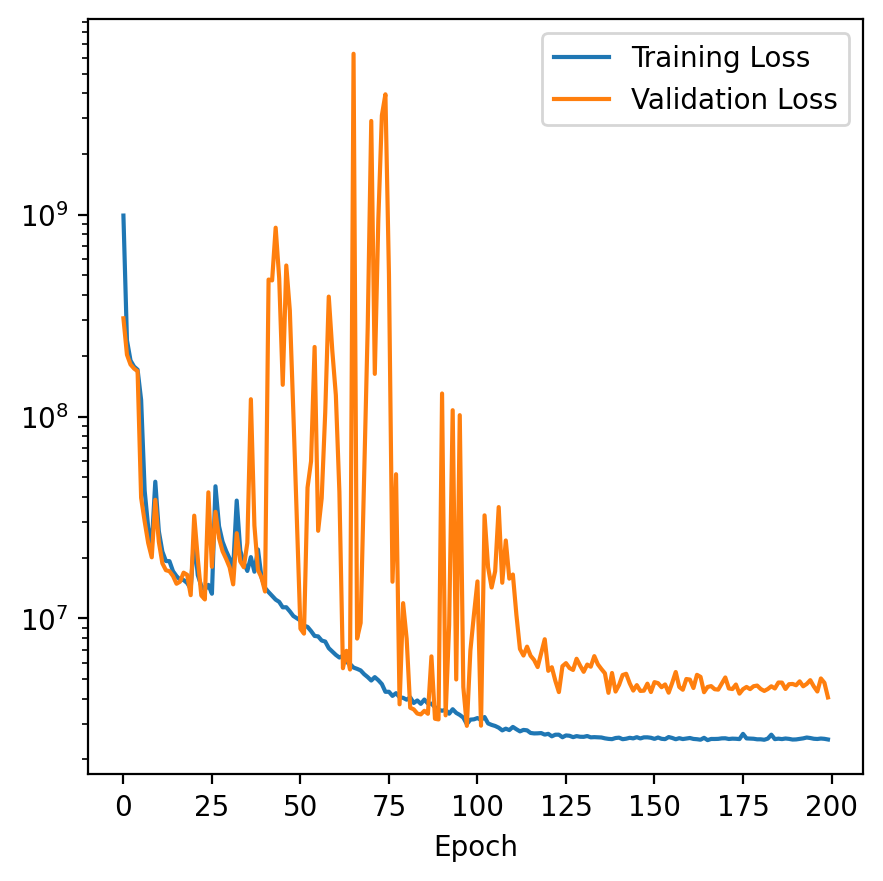

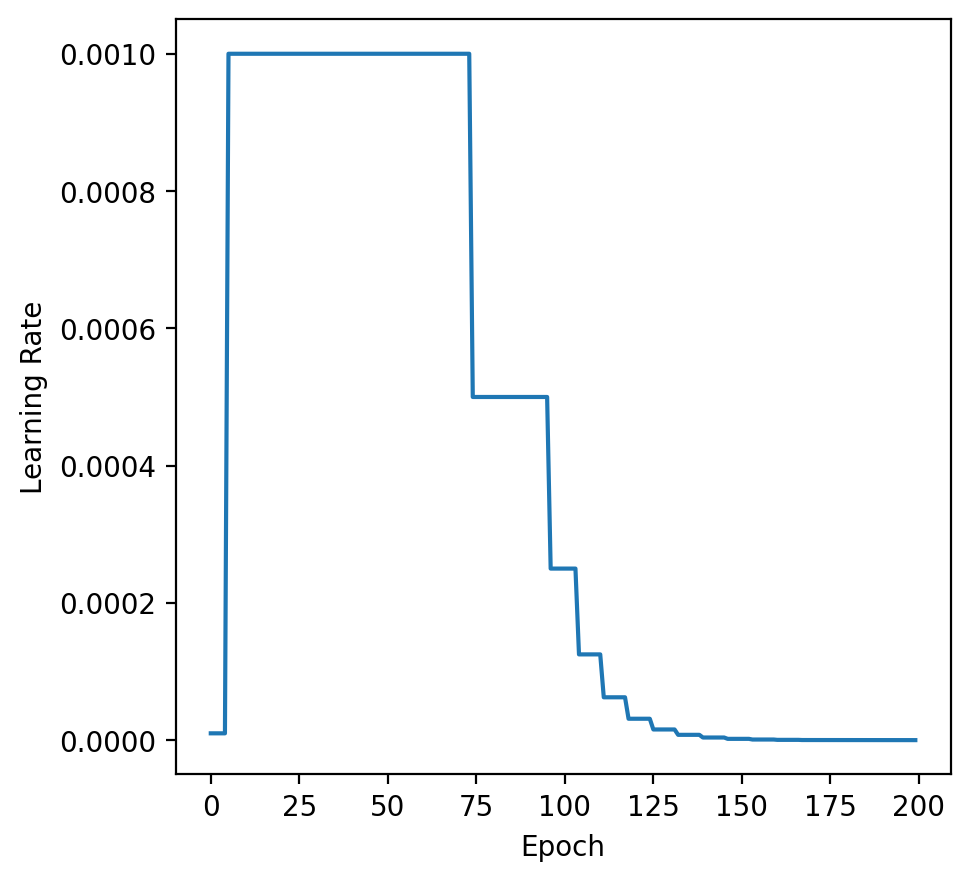

In [22]:
from matplotlib import pyplot as plt
my_dpi = 200
plt.figure(figsize=(5, 5), dpi=my_dpi)
plt.semilogy(range(0,scratch_model['epoch']), scratch_model['losses_tr'],label='Training Loss')
plt.semilogy(range(0,scratch_model['epoch']), scratch_model['losses_val'],label='Validation Loss')
# plt.plot(range(0,scratch_model['epoch']), scratch_model['losses_test'],label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
# plt.savefig(basedir + 'Fig_save/Unsupervised learning - Loss.png', dpi=200 * 10)
plt.show()


plt.figure(figsize=(5, 5), dpi=my_dpi)
plt.plot(range(0,scratch_model['epoch']), scratch_model['learning_rate'])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
# plt.savefig(basedir + 'Fig_save/Unsupervised learning - LR.png', dpi=200 * 10)
plt.show()

In [24]:
basedir = 'nets/ckpt_CAE_Fused_001/'
scratch_model = torch.load(basedir+'Pretrain_001_latest.pth.tar')
img_size = [80, 80, 80, 1]
num_clusters = 2
latent_channels = 512
model_name = 'CAE_Fused'
to_eval = model_name + "(img_size, latent_channels=latent_channels)"
model = eval(to_eval)
model.to(device)
model.load_state_dict(scratch_model['state_dict'])
model.eval()
print(model)

CAE_Fused(
  (encoder3d): Sequential(
    (conv3d1_1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu3d1_1): ReLU()
    (maxpool3d1_1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn3d1_1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3d2_1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu3d2_1): ReLU()
    (maxpool3d2_1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn3d2_1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3d3_1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu3d3_1): ReLU()
    (maxpool3d3_1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn3d3_1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3d4_1): Conv3d(64, 128, kernel_size=

In [25]:
from skimage import io
import skimage.transform
import scipy
import scipy.io as sio
from torch.utils.data.dataset import Dataset

class MyDataset_mat(Dataset):
    def __init__(self, ssc_paths, tm_paths, transforms_ssc=None, transforms_tm=None):
        self.paths_ssc = ssc_paths
        self.paths_tm = tm_paths
        self.transforms_ssc = transforms_ssc
        self.transforms_tm = transforms_tm
        
    def __getitem__(self, index):
        data_ssc = sio.loadmat(self.paths_ssc[index])['data']
        data_tm = sio.loadmat(self.paths_tm[index])['data']
        
        x_ssc = torch.from_numpy(data_ssc.astype(np.float32)/65535)
        x_ssc = x_ssc.unsqueeze(dim = 0)
        
        x_tm = torch.from_numpy(data_tm.astype(np.float32)/65535)
        x_tm = x_tm.unsqueeze(dim = 0)
        
        if 'Un' in self.paths_ssc[index]:
            label = int(1)
        else:
            label = int(0)
        if self.transforms_ssc:
            x_ssc = self.transforms_ssc(x_ssc)
        if self.transforms_tm:
            x_tm = self.transforms_ssc(x_tm)
        return (x_ssc, x_tm),label,index
    
    def __len__(self):
        return len(self.paths_ssc)

In [26]:
import pandas as pd

csv_path = './reports/PT_GroundTruthLabel&ClusterLabel.csv'

csv_data = pd.read_csv(csv_path)

sscpath = csv_data.name
tmpath = csv_data.tmname
cluster_label = csv_data.cluster
truth_label = csv_data.label

trainsscpath, traintmpath, valsscpath, valtmpath = [], [], [], []

train = list(range(1,len(sscpath)))
transtrain, transval = train_test_split(train, test_size=0.2, random_state=3)
for i in transtrain:
    trainsscpath.append(sscpath[i])
    traintmpath.append(tmpath[i])
for i in transval:
    valsscpath.append(sscpath[i])
    valtmpath.append(tmpath[i])

train_datasets = MyDataset_mat(trainsscpath, traintmpath)
val_datasets = MyDataset_mat(valsscpath, valtmpath)

batch_size = 64

dataloader_train = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
dataloader_val = torch.utils.data.DataLoader(val_datasets, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
dataloaders = [dataloader_train, dataloader_val]

Translocated data: 5700
UnTranslocated data: 3666


In [28]:
model.to(device)
model.eval()

with torch.no_grad():
    for i, data in enumerate(dataloader_train):
        inputs, label, index = data
        inputs_SSC, inputs_tm = inputs
        inputs_SSC = inputs_SSC.to(device)
        inputs_tm = inputs_tm.to(device)
        inputs = (inputs_SSC, inputs_tm)
        _, extra_out = model(inputs)
        x_out, x1_out = extra_out
        extra_out = torch.cat([x1_out, x_out], dim=1)
        extra_out = extra_out.cpu().clone().numpy()
        
        if i == 0:
            labellist = label
            latent_out = extra_out
            index_all = index
        else:
            latent_out = np.append(latent_out, extra_out, axis=0)
            labellist = np.append(labellist, label, axis=0)
            index_all = np.append(index_all, index, axis=0)

print('Label shape:', labellist.shape)
print('Latent Space shape:', latent_out.shape)
print('Index shape:', index_all.shape)

Label shape: (7488,)
Latent Space shape: (7488, 1024)
Index shape: (7488,)


In [29]:
import umap
dataset = latent_out
# dataset = X_2d_mix
trans = umap.UMAP(n_neighbors=20, random_state=45).fit(dataset)

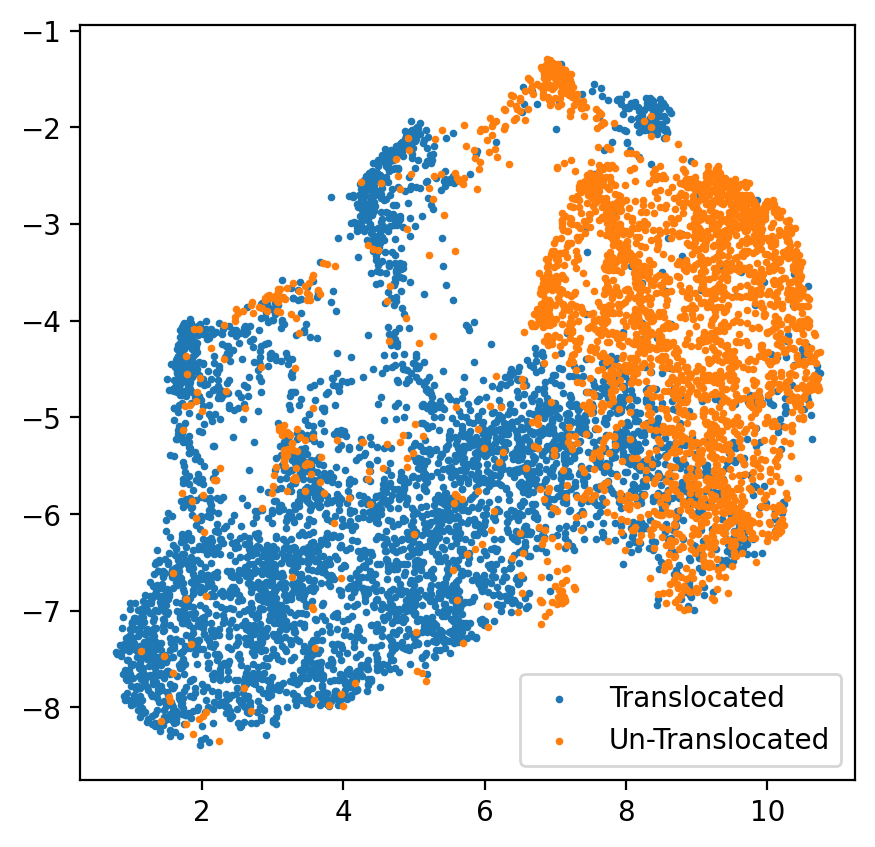

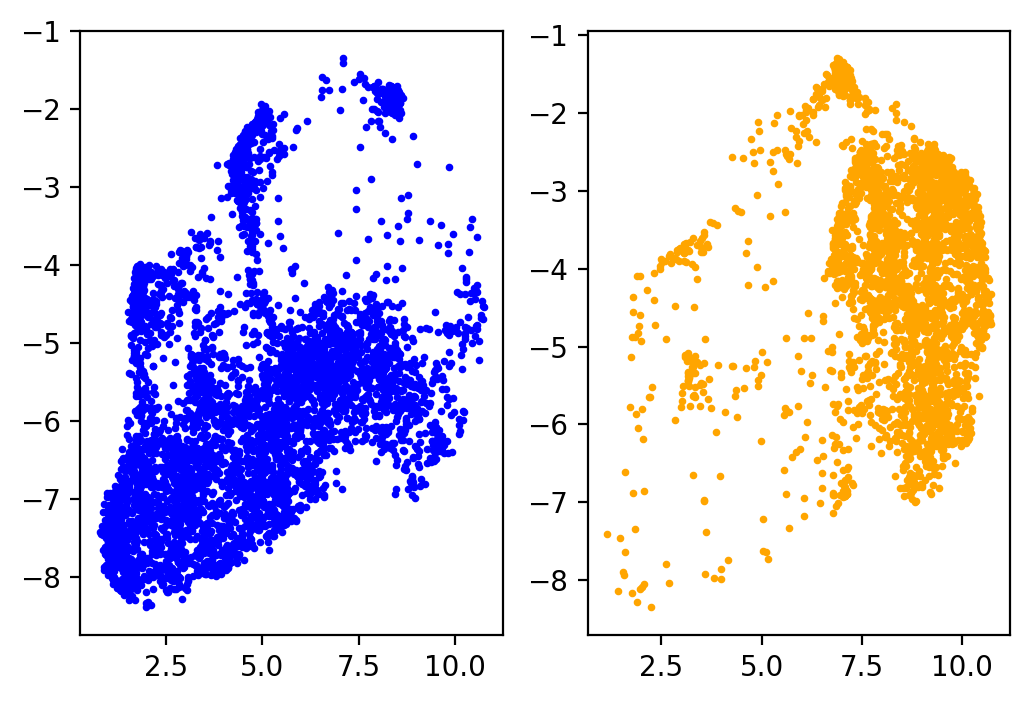

In [30]:
labellist_mix = labellist
plt.figure(figsize=(5,5), dpi=200)
plt.scatter(trans.embedding_[labellist_mix==0, 0], trans.embedding_[labellist_mix==0, 1], s= 3, label='Translocated')
plt.scatter(trans.embedding_[labellist_mix==1, 0], trans.embedding_[labellist_mix==1, 1], s= 3, label='Un-Translocated')
plt.legend()
# plt.savefig(basedir + 'Fig_save/UMAP-Visualization.jpg', dpi=200 * 10)
plt.show()
plt.figure(dpi=200)
plt.subplot(121)
plt.scatter(trans.embedding_[labellist_mix==0, 0], trans.embedding_[labellist_mix==0, 1], s= 3, c='blue')
plt.subplot(122)
plt.scatter(trans.embedding_[labellist_mix==1, 0], trans.embedding_[labellist_mix==1, 1], s= 3, c='orange')
plt.show()
# plt.title('Embedding of the training set by UMAP', fontsize=24);

In [31]:
from sklearn.manifold import TSNE
# import seaborn as sns
tsne = TSNE(n_components=2, random_state=5, verbose=1, perplexity=300, learning_rate=5e3, early_exaggeration=40, n_iter=1000)
X_2d = tsne.fit_transform(latent_out)

C:\Users\netzz\anaconda3\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 901 nearest neighbors...
[t-SNE] Indexed 7488 samples in 0.005s...
[t-SNE] Computed neighbors for 7488 samples in 1.618s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7488
[t-SNE] Computed conditional probabilities for sample 2000 / 7488
[t-SNE] Computed conditional probabilities for sample 3000 / 7488
[t-SNE] Computed conditional probabilities for sample 4000 / 7488
[t-SNE] Computed conditional probabilities for sample 5000 / 7488
[t-SNE] Computed conditional probabilities for sample 6000 / 7488
[t-SNE] Computed conditional probabilities for sample 7000 / 7488
[t-SNE] Computed conditional probabilities for sample 7488 / 7488
[t-SNE] Mean sigma: 843.799641
[t-SNE] KL divergence after 250 iterations with early exaggeration: 335.425598
[t-SNE] KL divergence after 1000 iterations: 1.866845


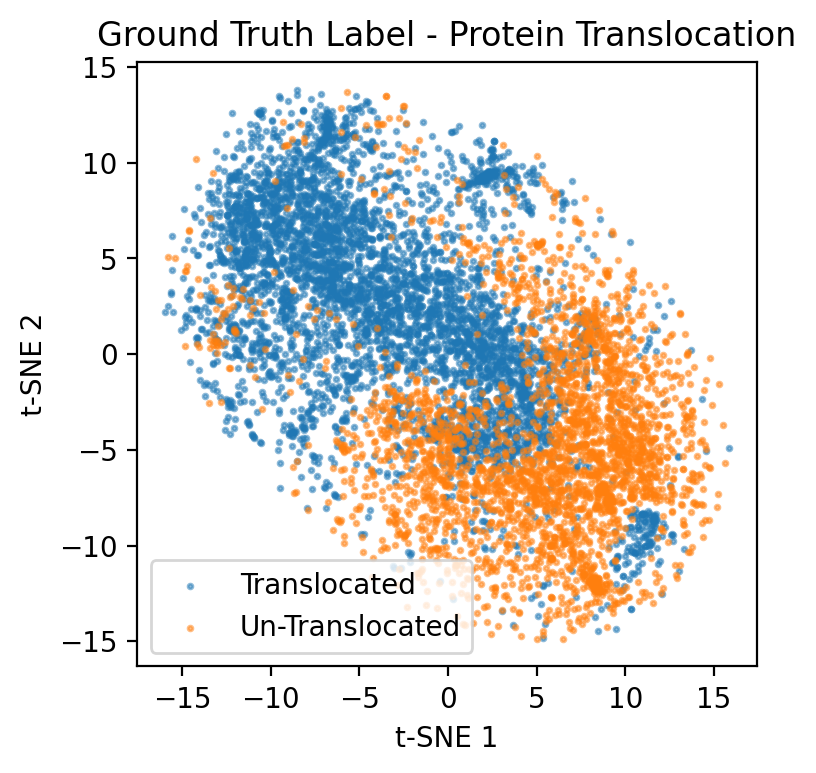

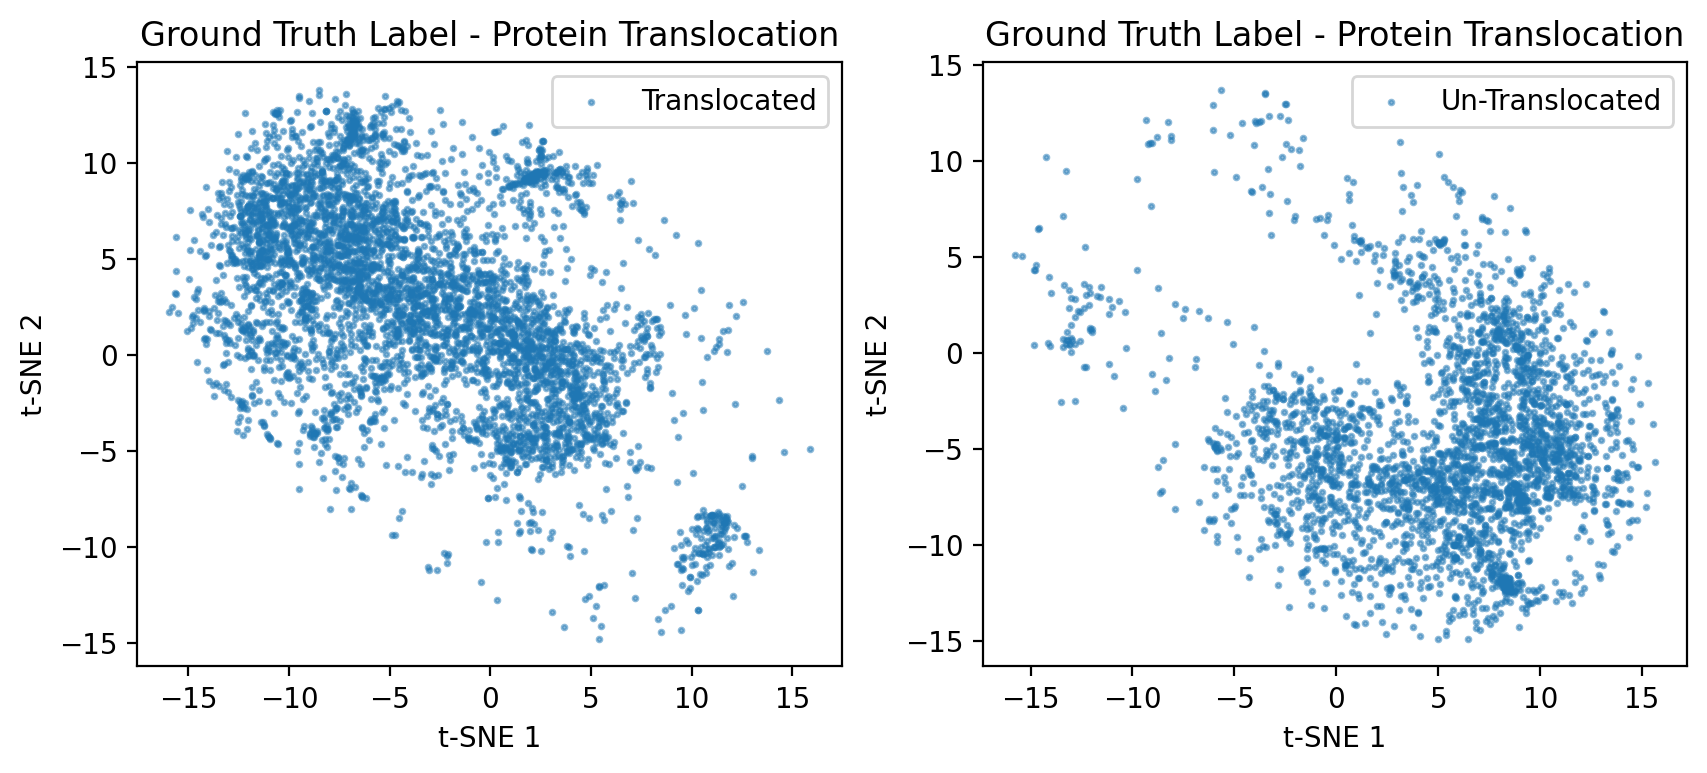

In [32]:
from matplotlib import pyplot as plt
plt.figure(figsize=(4,4), dpi = 200)
plt.scatter(X_2d[labellist==0, 0], X_2d[labellist==0, 1], s=3, alpha=0.5)
plt.scatter(X_2d[labellist==1, 0], X_2d[labellist==1, 1], s=3, alpha=0.5)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Ground Truth Label - Protein Translocation')
plt.legend(['Translocated', 'Un-Translocated'])
# plt.savefig(basedir + 'Fig_save/Ground Truth Visualization - PT - tsne.png', dpi=200 * 10)
plt.show()

from matplotlib import pyplot as plt
plt.figure(figsize=(10,4), dpi = 200)
plt.subplot(121)
plt.scatter(X_2d[labellist==0, 0], X_2d[labellist==0, 1], s=3, alpha=0.5, label='Translocated')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Ground Truth Label - Protein Translocation')
plt.legend()
plt.subplot(122)
plt.scatter(X_2d[labellist==1, 0], X_2d[labellist==1, 1], s=3, alpha=0.5, label='Un-Translocated')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Ground Truth Label - Protein Translocation')
plt.legend()

plt.show()

In [33]:
dataset = latent_out
dataset = trans.embedding_

num_clusters = 2
from sklearn.cluster import KMeans, Birch, MiniBatchKMeans, MeanShift, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
## MiniBatchKMeans
mbkmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=1, batch_size=512)
## KMeans
# mbkmeans = KMeans(n_clusters=num_clusters, random_state=10)
mbkmeans = Birch(n_clusters=num_clusters)
# mbkmeans = AgglomerativeClustering(n_clusters=num_clusters)
mbkmeans = GaussianMixture(n_components=num_clusters)
c_idx_mbk = mbkmeans.fit_predict(dataset)

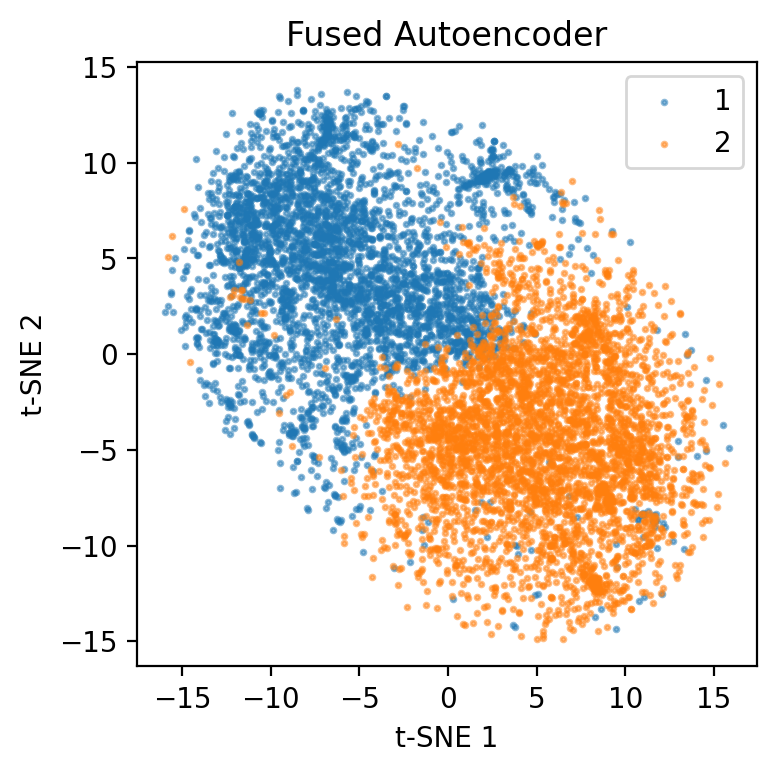

In [34]:
from matplotlib import pyplot as plt
plt.figure(figsize=(4,4), dpi=200)
plt.scatter(X_2d[c_idx_mbk==0, 0], X_2d[c_idx_mbk==0, 1], s=3, alpha=0.5)
plt.scatter(X_2d[c_idx_mbk==1, 0], X_2d[c_idx_mbk==1, 1], s=3, alpha=0.5)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Fused Autoencoder')
plt.legend(['1','2','3'])
plt.show()

In [35]:
idx_match = (c_idx_mbk)
for i,idx in enumerate(c_idx_mbk):
    if idx == 0:
        idx_match[i] = 0
    else:
        idx_match[i] = 1
idx_match = np.array(idx_match)
print(idx_match[:20])
print(labellist[:20])

[0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 0 1]
[0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 1]


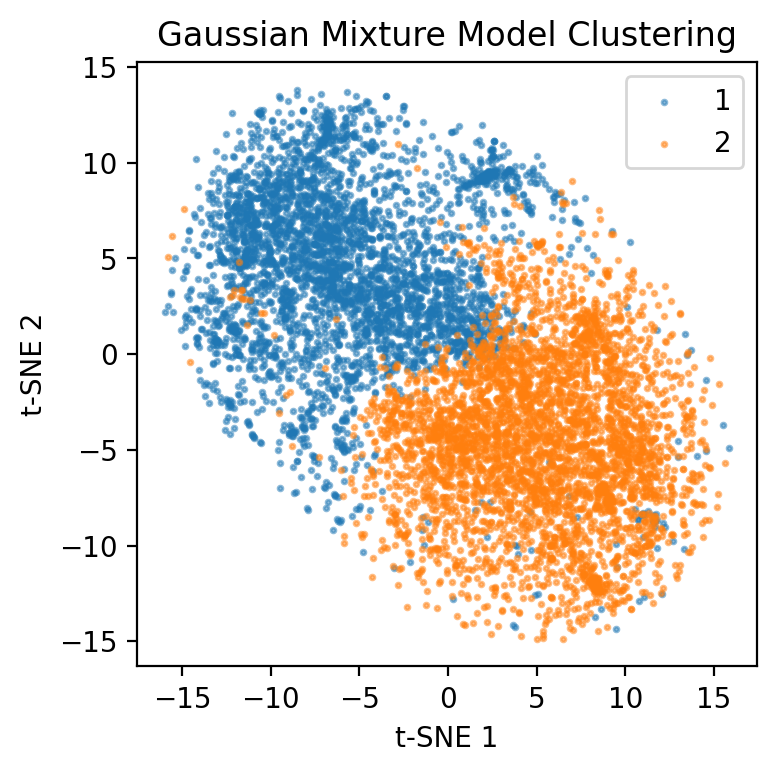

In [36]:
from matplotlib import pyplot as plt
plt.figure(figsize=(4,4), dpi=200)
plt.scatter(X_2d[idx_match==0, 0], X_2d[idx_match==0, 1], s=3, alpha=0.5)
plt.scatter(X_2d[idx_match==1, 0], X_2d[idx_match==1, 1], s=3, alpha=0.5)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Gaussian Mixture Model Clustering')
plt.legend(['1','2'])
# plt.savefig(basedir + 'Fig_save/GMM Clustering Result - WBC + Leu - matched.png', dpi=200 * 10)
plt.show()

[[3388 1171]
 [ 225 2704]]
              precision    recall  f1-score   support

           0       0.94      0.74      0.83      4559
           1       0.70      0.92      0.79      2929

    accuracy                           0.81      7488
   macro avg       0.82      0.83      0.81      7488
weighted avg       0.84      0.81      0.82      7488

0.8331636999991987


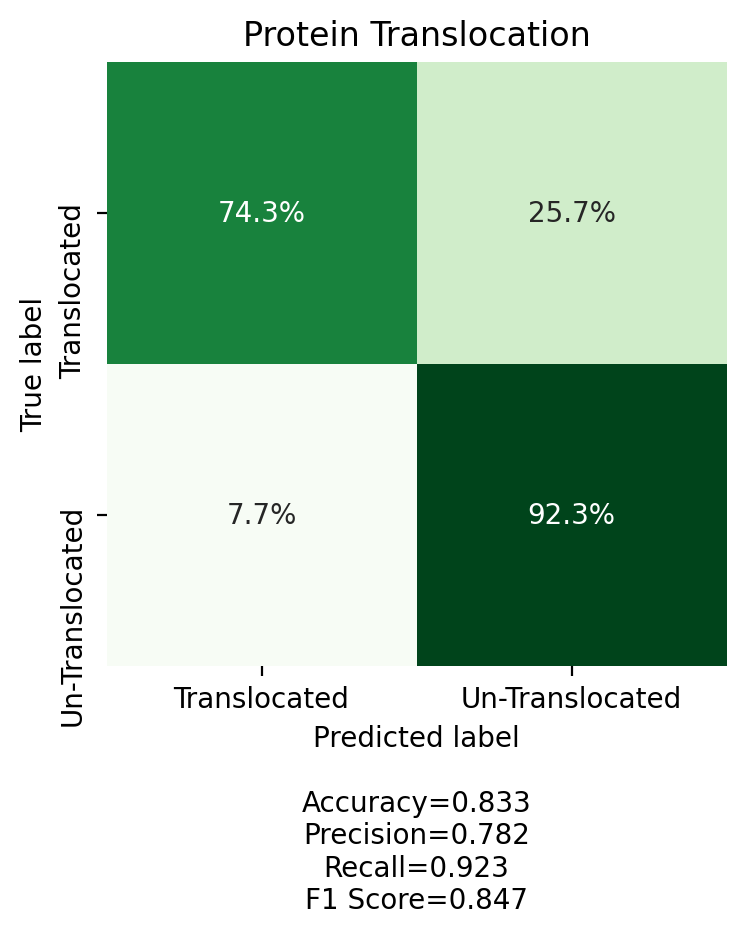

In [37]:
cm = confusion_matrix(labellist, idx_match, labels = [0,1])
cr = classification_report(labellist, idx_match, labels = [0,1])
bas = balanced_accuracy_score(labellist, idx_match)
print(cm)
print(cr)
print(bas)

confusionMat = np.asarray(cm)
sumconfusion = np.sum(confusionMat,axis = 1).T
summat = np.tile(sumconfusion,(2,1)).T
percentconfusion_val = np.divide(confusionMat,summat)

categories = ['Translocated','Un-Translocated']
make_confusion_matrix(percentconfusion_val, 
                      #group_names=labels,
                      categories=categories,
                      percent=False,
                      cbar=False,
                      figsize=(4 ,4),
                      cmap='Greens',my_dpi=200,title = 'Protein Translocation',
                      saved=False, save_name=basedir+'Fig_save/Unsupervised Learning - PT.jpg')

In [81]:
from datetime import datetime

basedir = 'reports/ckpt_CAE_Fused_001/'

dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%H_%M_%b%d%Y")

fname21 = basedir+"X_2d_train_bn001_"+timestampStr+".csv"
np.savetxt(fname21, X_2d , delimiter=",")
fname21 = basedir+"UMAP_train_bn001_"+timestampStr+".csv"
np.savetxt(fname21, trans.embedding_ , delimiter=",")

fname22 = basedir+"Labellist_train_bn001_"+timestampStr+".csv"
np.savetxt(fname22, labellist , delimiter=",")
fname23 = basedir+"Latent_out_train_bn001_"+timestampStr+".csv"
np.savetxt(fname23, latent_out , delimiter=",")

fname24 = basedir+"Index_bn001_"+timestampStr+".csv"
np.savetxt(fname24, index_all, delimiter=",")
fname25 = basedir+"Cluster_result_bn001_"+timestampStr+".csv"
np.savetxt(fname25, idx_match, delimiter=",")
fname26 = basedir+"TrainSSC_path_bn001_"+timestampStr+".csv"
np.savetxt(fname26, trainsscpath, fmt="%s", delimiter=",")
fname27 = basedir+"Traintm_path_bn001_"+timestampStr+".csv"
np.savetxt(fname27, traintmpath, fmt="%s", delimiter=",")